# Introduction
Graph attention networks (GATs) [Velickovic et al.](https://arxiv.org/abs/1710.10903) are a special kind of graph neural networks, which use learned attention weights to aggregate over a node's neighborhood. Since being introduced in 2018, GATs have achieved tremendous success and outperformed many other models on standard datasets. However, GATs have their limitations. For instance, it is not difficult to see that they can suffer from oversmoothing and oversquashing. The reason is that the underlying mechanism of GATs is aggregation over the 1-hop neighborhood, which is similar to standard GNNs. In this notebook,  we will slightly modify the aggregation mechanism of GATs and introduce a new model, designed to alleviate some limitations of GATs. Then, we will examine the performance and limitations of this model and compare it to GATs. To do so, we will perform experiments on two datasets - Cora and TreeNeighborsMatch. Our approach is inspired by the papers by [Abboud et al.](https://arxiv.org/abs/2206.01003) and [Alon and Yahav](https://arxiv.org/pdf/2006.05205.pdf). 

# Idea and Motivation

While GATs are a great way to aggregate using attention, it is natural to ask if this is the best way. One direction in which one could improve GATs would be to directly modify the way attention is computed. Several modifications to the attention mechanism of GATs have been proposed, such as GATv2 ([Brody et al.](https://arxiv.org/abs/2105.14491)), which have a bigger expressive power than GATs. The main idea is that GATv2 computes *dynamic* attention while GATs compute *static* attention. 

Another direction that one could consider is to look at *what* is being aggregated. In particular, GATs only compute attention for the $1$-hop neighborhood. One could imagine (or design) a node classification problem, where not only is the information from the $1$-hop neighborhood essential, but the correct label depends heavily on the properties of  particular nodes in the $k$-hop neighborhood with $k \geq 2$. In such a scenario, one would like to compute attention weights for nodes in the $k$-hop neighborhood as well. GATs do not compute such weights - the only way to tackle such a problem using GATs is by having atleast $k$ layers. However, this can be problematic, especially if $k$ is large. By introducing more layers, the size of the computational graph increases, information bottlenecks appear and information from nodes $k$-hops away is lost. Additionally, as we have explained in Q1, having many layers is likely to cause oversmoothing.  Perhaps we could design an aggregation mechanism that computes attention weights for nodes far away and doesn't suffer from oversquashing or ovesmoothing, thus resulting in better performance. 

This observation, and my idea, are strongly motivated by the paper by [Abboud et al](https://arxiv.org/abs/2206.01003). The authors propose a class of models called shortest path message passing neural networks (SPMPNNs). The idea of SPMPNNs is simple - instead of aggregating only through the direct neighborhood of a node, we can aggregate over $k$-hop neighborhoods and then combine. This ensures that each node can "communicate" directly with nodes in its $k$-hop neighborhoods, and the flow of information between nodes that are far away is much smoother. In their paper, the authors propose the following model, called a *shortest path network* (SPN):

$$
\begin{align}
h_{u}^{t+1} = MLP(h_{u}^t(1+ϵ) + \sum_{i=1}^{K} \alpha_i \sum_{v \in N_{i}(u)}h_{u}^t)
\end{align}
$$

where $N_{i}(u)$ denotes the $i$-hop neighborhood of $u$ and $\alpha_i$ are learned weights. Crucially, the $\alpha_i$ comes BEFORE the aggregation of the neighbors from the $i$-hop neighborhood. This means that there is only one weight learned for the entire neighborhood. A possible improvement would be the aggregation scheme: 
$$
\begin{align*}
h_{u}^{t+1} = MLP(h_{u}^t(1+ϵ) + \sum_{i=1}^{K}  \sum_{v \in N_{i}(u)} \alpha_{iv}^uh_{u}^t) 
\end{align*}
$$

where $\alpha_{iv}^u$ is the learned attention weight for $v \in N_{i}(u)$. In this case, we would get something like a GAT which aggregates each $k$-hop neighborhood separately. Building on this idea, I decided to explore the class of models given as:

$$
\begin{align*}
h_{u}^{t+1} = COM(h_{u}^t, GAT_1(N_{1}(u)),GAT_2(N_{2}(u)), \dots GAT_k(N_{k}(u))) 
\end{align*}
$$

where $GAT_i(N_{i}(u))$ denotes a graph attention layer aggregating over the $i$-hop neighborhood. 

I believe that one could write an entire thesis (or perhaps a paper) studying this class of models. For this reason, I decided to choose ONE model from this class and conduct a short study on its properties and performance. But which model should we choose? Recall that the driving idea behind this class of models is to achieve better information flow. Thus a good way to decide which model to use would be to test the models on a dataset which highlights information bottlenecks - like the TreeNeighboursMatch problem ([Alon and Yahav](https://arxiv.org/pdf/2006.05205.pdf)). I experimented with different architectures on this dataset and picked the model which performed the best. This was a model using the aggregation scheme:

$$
\begin{align*}
h_{u}^{t+1} = MLP(h_{u}^t \bigoplus GAT_1(N_{1}(u)) \bigoplus GAT_2(N_{2}(u)) \bigoplus \dots \bigoplus GAT_k(N_{k}(u))) 
\end{align*}
$$

where $\bigoplus$ denotes concatenation. The intuition behind this model is as follows: when we concatenate the outputs from different hops, the information is not mixed together (which is not the case if we sum). The MLP can then learn to identify the $k$-hop neighbourhoods which are important (in the TreeNeighboursMatch problem, only the last layer of the binary tree matters - this will be explained in detail later). 


The rest of this notebook is dedicated to experiments around this concatenation model which we will refer to as HopGAT. I have decided to not include the experiments that I did with other models from the class above, even though they took me a lot of time. The reason is that the notebook is already quite long and the experiments were not that interesting. However, it would be interesting to conduct a deeper study of the entire class of models and this is perhaps a possible direction for further research. 

# Experiments

This section includes experiments that I conducted as part of my study. It is divided into subsections where each step is carefully explained. If you want to run code in this notebook, feel free to do so. However, bear in mind that by doing so, you will erase my outputs. Furthermore, some experiments take a very long time - so be careful which cells you execute. 

We will perform experiments only on two datasets - Cora and TreeNeighborsMatch. Our first goal is to compare the performance of HopGAT vs GAT. Our second goal is to understand the limitations of both GAT and HopGAT and see if HopGAT alleviates any limitations of GATs. Namely, we would like to show that HopGAT is more resistant to oversquashing. Let's begin.  


## Cora

Before we do anything sophisticated, we must do a sanity check. Does our model achieve a reasonable performance on a standard dataset like, say, Cora? How does it compare to a standard GAT? In this section, we will implement a standard GAT, implement our model and compare their performance. We will also examine oversmoothing. 

### Data preparation

First we must prepare the data. We must download the Cora dataset but also we must figure out a way to compute the shortest path neighborhoods.

In [ ]:
#colab stuff

%%capture
%env TORCH=1.13.0+cu116
!pip install torch-scatter -f https://data.pyg.org/whl/torch-${TORCH}.html
!pip install torch-sparse -f https://data.pyg.org/whl/torch-${TORCH}.html
!pip install torch-geometric
!pip install common

In [ ]:
#download Cora
import torch
import torch_geometric
from torch_geometric.datasets import Planetoid
from torch_geometric.loader import DataLoader


device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu") 
print(device)
dataset = Planetoid("/tmp/Cora", name="Cora")

cuda


Processing...
Done!


Thanks to the amazing work of [Abboud et al](https://arxiv.org/abs/2206.01003ps://), we don't have to worry about computing shortest paths ourselves. Instead, we take a function they implemented, and use it for our experiments. The following code is copied from this [link](https://github.com/radoslav11/SP-MPNN/blob/main/src/utils/shortest_paths.py). 

In [ ]:
#this is not my code 

from scipy.sparse.csgraph import floyd_warshall
from torch_geometric.utils import to_dense_adj, to_undirected
from collections import deque



def compute_shortest_paths(N, K, adj__N_N):
    # Computest the hops / jumps tensor for distance < K
    sp__N_N = floyd_warshall(adj__N_N)
    jumps__K_N_N = torch.zeros(size=(K, N, N), dtype=torch.float)
    for d in range(K):
        jumps__K_N_N[d] = torch.tensor(sp__N_N == d, dtype=torch.float)

    return jumps__K_N_N


def transform_graph_sp_small(graph, max_distance=None):
    if hasattr(graph, "edge_attr") and graph.edge_attr is not None:
        original_edge_index, original_edge_attr = to_undirected(
            graph.edge_index, graph.edge_attr, reduce="max"
        )
    else:
        original_edge_index = to_undirected(graph.edge_index)

    adj_matrix = to_dense_adj(original_edge_index, max_num_nodes=graph.num_nodes)[0]
    shortest_paths = torch.tensor(floyd_warshall(adj_matrix), dtype=torch.long)
    edge_index = torch.zeros(
        size=(2, graph.num_nodes * graph.num_nodes), dtype=torch.long
    )
    edge_index[0, :] = torch.arange(graph.num_nodes).repeat(graph.num_nodes)
    edge_index[1, :] = torch.repeat_interleave(
        torch.arange(graph.num_nodes), graph.num_nodes
    )
    graph.edge_weights = shortest_paths.flatten()
    graph.edge_index = edge_index

    if max_distance:
        edge_mask_dist = graph.edge_weights <= max_distance
        graph.edge_weights = graph.edge_weights[edge_mask_dist]
        graph.edge_index = graph.edge_index[:, edge_mask_dist]

    if hasattr(graph, "edge_attr") and graph.edge_attr is not None:
        mask_dist_1 = graph.edge_weights == 1
        graph.edge_index[:, mask_dist_1] = original_edge_index
        if len(graph.edge_attr.shape) == 1:
            graph.edge_attr = torch.zeros(
                size=(graph.edge_index.shape[1],), dtype=torch.long
            )
            graph.edge_attr[mask_dist_1] = original_edge_attr
        elif len(graph.edge_attr.shape) == 2:
            graph.edge_attr = torch.zeros(
                size=(graph.edge_index.shape[1], graph.edge_attr.shape[1]),
                dtype=original_edge_attr.dtype,
            )
            graph.edge_attr[mask_dist_1, :] = original_edge_attr

    return graph


def to_adj_list(N, edge_index, edge_attr=None):
    ret = [set() for _ in range(N)]
    for i in range(edge_index.shape[1]):
        u, v = edge_index[:, i]
        w = 0 if edge_attr is None else edge_attr[i]
        ret[u].add((v, w))
        ret[v].add((u, w))

    return ret


def transform_graph_sp(graph, max_distance=None):
    N = graph.num_nodes
    if max_distance is None:
        max_distance = N

    if hasattr(graph, "edge_attr") and graph.edge_attr is not None:
        adj_list = to_adj_list(N, graph.edge_index, graph.edge_attr)
    else:
        adj_list = to_adj_list(N, graph.edge_index)

    edges = []
    weights = []
    edge_attr_new = []
    for src in range(N):
        # Create edges from src
        vis = set()
        vis.add(src)
        Q = deque([(src, 0)])
        while Q:
            u, d = Q.popleft()
            for v, w in adj_list[u]:
                if v not in vis:
                    vis.add(v)
                    edges.append([src, v])
                    weights.append(d + 1)
                    edge_attr_new.append(w)
                    if d + 1 < max_distance:
                        Q.append((v, d + 1))

    graph.edge_index = torch.tensor(edges, dtype=torch.long).T
    graph.edge_weights = torch.tensor(weights, dtype=torch.long)

    if hasattr(graph, "edge_attr") and graph.edge_attr is not None:
        graph.edge_attr = torch.tensor(edge_attr_new, dtype=torch.long)

    return graph


class ShortestPathTransform:
    def __init__(self, max_distance=None, threshold=8196):
        self.max_distance = max_distance
        self.threshold = threshold

    def transform(self, graph):
        if graph.x is None:
            # For ogbg-ppa
            graph.x = torch.zeros(graph.num_nodes, dtype=torch.long)

        if graph.num_nodes > self.threshold or graph.num_edges == 0:
            return transform_graph_sp(graph, self.max_distance)
        else:
            return transform_graph_sp_small(graph, self.max_distance)

Let us illustrate how this works. Let us generate a graph, plot it, then compute the 2 hop neighborhoods, and plot them. 

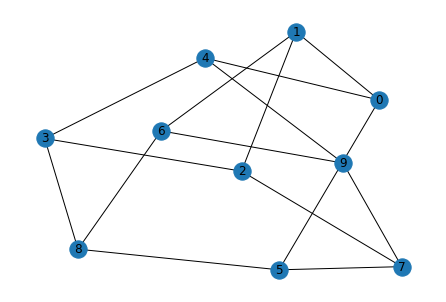

In [ ]:
#plot some graph

import networkx as nx
petersen=nx.petersen_graph()
nx.draw(petersen, with_labels = True) 

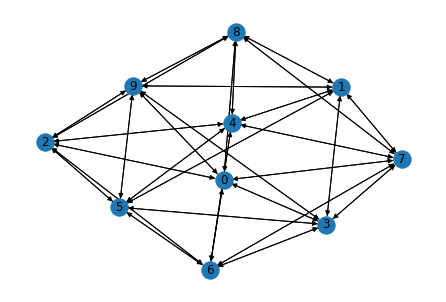

In [ ]:
# now plot its 2-hop neighbourhoods

petersen = torch_geometric.utils.convert.from_networkx(petersen)
spt = ShortestPathTransform(2)
spt.transform(petersen)
distance2 = petersen.edge_weights == 2
petersen.edge_index = petersen.edge_index[:,distance2]
petersen = torch_geometric.utils.convert.to_networkx(petersen)
nx.draw(petersen, with_labels = True) 

Cool!

Now we must modify the Cora dataset so that it contains the corresponding $k$-hop edge indices. We can do that as follows:

In [ ]:
def getHopNeighborhoods(depth,graph):
  '''Computes k-hop edge indices for k = 1, ... depth'''
  
  spt = ShortestPathTransform(depth)
  spt.transform(graph)
  dic = {}
  for i in range(1,depth+1):
    distance = graph.edge_weights == i
    dic[i] = graph.edge_index[:,distance]
  graph.hops = dic
  return graph
data = getHopNeighborhoods(10,dataset.data)

We store the $k$-hop edge indices in a dictionary called hops. To access the 3 hop edge index, we simply do:

In [ ]:
data.hops[3]

tensor([[  13,   24,  143,  ..., 2493, 2607, 2698],
        [   0,    0,    0,  ..., 2707, 2707, 2707]])

Now we are ready to implement both the standard GAT and HopGAT. 

### Implementation

In [ ]:
#Implementing a graph attention network 

from torch_geometric.nn import GATConv
from torch import nn
from torch.nn import functional as F

class GAT(nn.Module):
  def __init__(self,input_dim,hid_dim,n_heads,n_classes,n_layers,slope = 0.2,dropout = 0.6):
    super(GAT, self).__init__()
   
    self.device = "cuda" if torch.cuda.is_available() else "cpu"
    self.input_dim = input_dim
    self.hid_dim = hid_dim
    self.n_classes = n_classes
    self.n_layers = n_layers 
    self.num_layers = n_layers
    self.dropout = dropout
    
    if n_layers >= 1:
        self.layers = nn.ModuleList([GATConv(input_dim,hid_dim//n_heads,heads = n_heads,negative_slope = slope,dropout = dropout)] + 
                                  [GATConv(hid_dim,hid_dim//n_heads,heads = n_heads,negative_slope = slope,dropout = dropout) for i in range(0,n_layers-1)] + 
                                  [GATConv(hid_dim,n_classes,heads = n_heads,negative_slope = slope,dropout = dropout, concat = False)])
        
    else:
        raise ValueError('Error - need atleast 1 layer.')
    
  def forward(self,data) -> torch.Tensor:
    data = data.to(self.device)
    x = data.x
    edge_index = data.hops[1] #we only use 1-hops 

    x = F.dropout(x,self.dropout, training = self.training) 
    for i in range(len(self.layers)-1):
      x = self.layers[i](x,edge_index)
      x = F.dropout(x,self.dropout, training = self.training)
    
    x = self.layers[-1](x,edge_index) 
    return x

  def param_init(self):
      def _reset_module_parameters(module):
          for layer in module.children():
              if hasattr(layer, 'reset_parameters'):
                  layer.reset_parameters()
              elif hasattr(layer, 'children'):
                  for child_layer in layer.children():
                      _reset_module_parameters(child_layer)

      _reset_module_parameters(self) 

      

In [ ]:
#Implementing HopGAT
from torch import nn
from torch.nn import functional as F
from torch_geometric.nn import GATConv

class HopGAT(torch.nn.Module):
    def __init__(self, input_dim, hid_dim, out_dim, n_heads,n_layers):
        super(HopGAT, self).__init__()

        
        self.device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        self.n_layers = n_layers
        
        if n_layers >= 1:
          self.layers = nn.ModuleList([GATConv(input_dim,hid_dim//n_heads,heads = n_heads)]*n_layers)
        
        else:
          raise ValueError('Error - need atleast 1 layer.')
        
        self.mlp = nn.Linear(input_dim+hid_dim*n_layers,out_dim)
        
       

    def forward(self, data):
        x = data.x
  
        cat = x 
        for i in range(self.n_layers):
          cat = torch.cat((cat,self.layers[i](x,data.hops[i+1])),dim = 1)
      
        return self.mlp(cat)

    def param_init(self):
      def _reset_module_parameters(module):
          for layer in module.children():
              if hasattr(layer, 'reset_parameters'):
                  layer.reset_parameters()
              elif hasattr(layer, 'children'):
                  for child_layer in layer.children():
                      _reset_module_parameters(child_layer)

      _reset_module_parameters(self) 

In [ ]:
#train and evaluate functions

def evaluate(model,data,mask):
    model.eval()
    scores = model.forward(data)
    predicted_labels = torch.argmax(scores, dim = 1)[mask]
    accuracy = ((predicted_labels == data.y[mask]).float()).mean()
    return accuracy.item()
    
def train(
    params: dict,
    data
) -> torch.nn.Module:
  """
    This function trains a node classification model and returns the trained model object.
  """
  # set device
  device = "cuda" if torch.cuda.is_available() else "cpu"

  data = data.to(device)
  
  if params["model"] == "GAT":
    model = GAT(input_dim = params["num_features"],
                                hid_dim = params["hid_dim"],
                                n_heads = params["n_heads"],
                                n_classes = params["num_classes"],
                                n_layers = params["n_layers"]).to(device)
  elif params["model"] == "HopGAT":
    model = HopGAT(input_dim = params["num_features"],
                              hid_dim = params["hid_dim"],
                              n_heads = params["n_heads"],
                              out_dim = params["num_classes"],
                              n_layers = params["n_layers"]).to(device)
  
  if params["print"]:
    print(model)
  model.param_init()
  k = params['max_patience']
  
  optimizer = torch.optim.Adam(model.parameters(), lr = params["lr"], weight_decay = params["weight_decay"])
  criterion = torch.nn.CrossEntropyLoss()
  

  losses = []
  train_accuracies = []
  val_accuracies = []
  test_accuracies = []
  stop_count = 0
  
  for i in range(params["epochs"]):
      model.train()
      optimizer.zero_grad()
      
      out = model.forward(data)
      loss = criterion(out[data.train_mask],data.y[data.train_mask]) 
      
      
      train_acc = evaluate(model,data, data.train_mask)
      val_acc = evaluate(model,data, data.val_mask)
      test_acc = evaluate(model,data, data.test_mask)
      

      train_accuracies.append(train_acc)
      val_accuracies.append(val_acc)
      test_accuracies.append(test_acc)
      
      
      
      losses.append(loss.item())
     
     ##early stopping
      if i > k:
        if val_accuracies[-1] <= val_accuracies[-2]:
          stop_count += 1
        else:
          stop_count = 0

      if stop_count == k:
        print('Early stopped at epoch: ' + str(i))
       
        break
      
      else:
        loss.backward()
        optimizer.step()
  
  

  best_val_acc = max(val_accuracies)
  print("Best Val Accuracy: " + str(best_val_acc))
  print('Test acc: ' + str(test_accuracies[-1]))
  return model,test_accuracies


### Evaluation

In [ ]:
params = {
    "hid_dim": 64,
    "n_heads": 8,
    "n_layers": 1,
    "lr": 5e-4,
    "weight_decay": 5e-3,
    "epochs": 100,
    "dropout": 0.6,
    "alpha":0.2,
    "max_patience": 100,
    "num_classes": 7,
    "model": "GAT",
    "num_features": 1433,
    "print": True
}
gat_model_1,test_acc_1 = train(params, data)

GAT(
  (layers): ModuleList(
    (0): GATConv(1433, 8, heads=8)
    (1): GATConv(64, 7, heads=8)
  )
)
Best Val Accuracy: 0.7640000581741333
Test acc: 0.781000018119812


In [ ]:
params = {
    "hid_dim": 64,
    "n_heads": 8,
    "n_layers": 1, #we are only using 1 GAT layer, which isn't really the point of our model - hence the worse performance
    "lr": 5e-4,
    "weight_decay": 5e-3,
    "epochs": 100,
    "dropout": 0.6,
    "alpha":0.2,
    "max_patience": 100,
    "num_classes": 7,
    "model": "HopGAT",
    "num_features": 1433,
    "print": True
}
hop_gat_model_1,test_acc_hop_1 = train(params, data)

HopGAT(
  (layers): ModuleList(
    (0): GATConv(1433, 8, heads=8)
  )
  (mlp): Linear(in_features=1497, out_features=7, bias=True)
)
Best Val Accuracy: 0.7260000109672546
Test acc: 0.7380000352859497


We can see that our implementation of both models was succesful and that both models achieve a reasonably good performance. Observe that we only used 1 layer in HopGAT, which doesn't really make sense for this model - we would just use a 1-layer GAT if we wanted to aggregate over the 1-hop neighborhood. Let's try to increase the number of layers (in both models) to see what happens. 


Best Val Accuracy: 0.7660000324249268
Test acc: 0.7780000567436218
Best Val Accuracy: 0.7500000596046448
Test acc: 0.7490000128746033
Best Val Accuracy: 0.7680000066757202
Test acc: 0.7590000629425049
Best Val Accuracy: 0.4780000150203705
Test acc: 0.48900002241134644
Best Val Accuracy: 0.41600000858306885
Test acc: 0.3710000216960907
Best Val Accuracy: 0.17800000309944153
Test acc: 0.15600000321865082
Best Val Accuracy: 0.12200000882148743
Test acc: 0.06200000271201134
Best Val Accuracy: 0.2939999997615814
Test acc: 0.2930000126361847
Best Val Accuracy: 0.1720000058412552
Test acc: 0.14500001072883606
Best Val Accuracy: 0.20600001513957977
Test acc: 0.06200000271201134


Text(0.5, 1.0, 'Accuracy vs Number of Layers in a GAT')

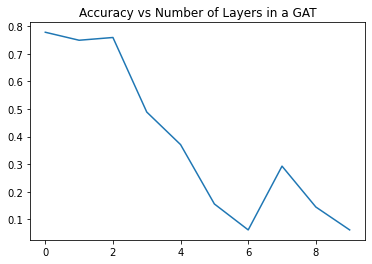

In [ ]:
import matplotlib.pyplot as plt

params["model"] = "GAT"
params["print"] = False
test_acc = []
for i in range(1,11):
  params["n_layers"] = i
  model,acc = train(params,data)
  test_acc.append(acc[-1])

plt.plot(test_acc)
plt.title("Accuracy vs Number of Layers in a GAT")

Best Val Accuracy: 0.7320000529289246
Test acc: 0.7390000224113464
Best Val Accuracy: 0.7680000066757202
Test acc: 0.7940000295639038
Best Val Accuracy: 0.7720000147819519
Test acc: 0.7850000262260437
Best Val Accuracy: 0.7740000486373901
Test acc: 0.7890000343322754
Best Val Accuracy: 0.7760000228881836
Test acc: 0.7930000424385071
Best Val Accuracy: 0.7640000581741333
Test acc: 0.7850000262260437
Best Val Accuracy: 0.7760000228881836
Test acc: 0.784000039100647
Best Val Accuracy: 0.7600000500679016
Test acc: 0.784000039100647
Best Val Accuracy: 0.7720000147819519
Test acc: 0.7830000519752502
Best Val Accuracy: 0.7620000243186951
Test acc: 0.7770000100135803


Text(0.5, 1.0, 'Accuracy vs Number of Layers in a HopGAT')

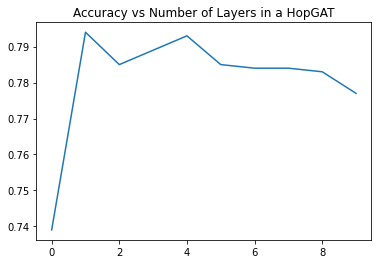

In [ ]:

params["model"] = "HopGAT"
params["print"] = False
test_acc = []
for i in range(1,11):
  params["n_layers"] = i
  model,acc = train(params,data)
  test_acc.append(acc[-1])

plt.plot(test_acc)
plt.title("Accuracy vs Number of Layers in a HopGAT")

Firstly, note that the best HopGAT model achieved a test accuracy of 79.4%, which is comparable with test accuracies achieved by GATs (these usually ranged between 78 and 81 in my experiments). Secondly, observe that the performance of the GAT decreases as we increase the number of layers while the performance of the HopGAT stays more or less constant. This means that GATs are susceptible to oversmoothing, while HopGATs are much more resistant. This is already an interesting result on its own. Perhaps for tasks where long-range dependencies are important, it is better to use HopGATs. 

Our primary motivation behind the HopGAT was to tackle oversquashing, not oversmoothing. However, it makes perfect sense that HopGAT is resistant to oversmoothing. The reason is that our concatenation is similar to Jumping Knowledge Connections. By remembering the initial features of each node (by concatenating it), we prevent oversmoothing from occuring. This is also another reason why concatenation is a good approach. 

Finally, a remark. I spent a significant amount of time trying to tweak the architecture of HopGAT to achieve a higher performance on Cora. For example, I tried using more layers (this is not the same as hops), different choices of nonlinearities and other aggregation schemes (e.g sum) but in the end the accuracy was always around 80%. Most of these models performed significantly worse on the following dataset, so I decided to not include them. 

## Implementing TreeNeighborsMatch

Now that we've implemented our model, saw that it performs reasonably well on Cora and is resistant to oversmoothing, it is time to test how well it tackles oversquashing, which is what it was designed for in the first place. To do this, we must turn to a dataset which is created to highlight oversquashing. A good candidate is the TreeNeighborsMatch problem from [Alon and Yahav](https://arxiv.org/pdf/2006.05205.pdf). 

First, we will download the dataset and understand and explain how it works. Then we will try to reimplement some results from the paper, to see if we understand what is going on. Finally, we will implement HopGAT on this dataset and see how it performs. Hopefully, we will observe that it is more resistant to oversquashing than a standard GAT. 



### Data preparation

To generate the dataset, we use the code from the paper. This can be found [here](https://github.com/tech-srl/bottleneck/). 

In [ ]:
#this is not my code

import torch
import torch_geometric

from torch_geometric.data import Data
from torch.nn import functional as F
from sklearn.model_selection import train_test_split
import numpy as np
import itertools
import random
import math

import common


class TreeDataset(object):
    def __init__(self, depth):
        super(TreeDataset, self).__init__()
        self.depth = depth
        self.num_nodes, self.edges, self.leaf_indices = self._create_blank_tree()
        self.criterion = F.cross_entropy

    def add_child_edges(self, cur_node, max_node):
        edges = []
        leaf_indices = []
        stack = [(cur_node, max_node)]
        while len(stack) > 0:
            cur_node, max_node = stack.pop()
            if cur_node == max_node:
                leaf_indices.append(cur_node)
                continue
            left_child = cur_node + 1
            right_child = cur_node + 1 + ((max_node - cur_node) // 2)
            edges.append([left_child, cur_node])
            edges.append([right_child, cur_node])
            stack.append((right_child, max_node))
            stack.append((left_child, right_child - 1))
        return edges, leaf_indices

    def _create_blank_tree(self):
        max_node_id = 2 ** (self.depth + 1) - 2
        edges, leaf_indices = self.add_child_edges(cur_node=0, max_node=max_node_id)
        return max_node_id + 1, edges, leaf_indices

    def create_blank_tree(self, add_self_loops=True):
        edge_index = torch.tensor(self.edges).t()
        if add_self_loops:
            edge_index, _ = torch_geometric.utils.add_remaining_self_loops(edge_index=edge_index, )
        return edge_index

    def generate_data(self, train_fraction):
        data_list = []

        for comb in self.get_combinations():
            edge_index = self.create_blank_tree(add_self_loops=True)
            nodes = torch.tensor(self.get_nodes_features(comb), dtype=torch.long)
            root_mask = torch.tensor([True] + [False] * (len(nodes) - 1))
            label = self.label(comb)
            data_list.append(Data(x=nodes, edge_index=edge_index, root_mask=root_mask, y=label))

        dim0, out_dim = self.get_dims()
        X_train, X_test = train_test_split(
            data_list, train_size=train_fraction, shuffle=True, stratify=[data.y for data in data_list])


        return X_train, X_test, dim0, out_dim, self.criterion


    def get_combinations(self):
        raise NotImplementedError

    def get_nodes_features(self, combination):
        raise NotImplementedError

    def label(self, combination):
        raise NotImplementedError

    def get_dims(self):
        raise NotImplementedError

class DictionaryLookupDataset(TreeDataset):
    def __init__(self, depth):
        super(DictionaryLookupDataset, self).__init__(depth)

    def get_combinations(self):
        # returns: an iterable of [key, permutation(leaves)]
        # number of combinations: (num_leaves!)*num_choices
        num_leaves = len(self.leaf_indices)
        num_permutations = 1000
        max_examples = 32000

        if self.depth > 3:
            per_depth_num_permutations = min(num_permutations, math.factorial(num_leaves), max_examples // num_leaves)
            permutations = [np.random.permutation(range(1, num_leaves + 1)) for _ in
                            range(per_depth_num_permutations)]
        else:
            permutations = random.sample(list(itertools.permutations(range(1, num_leaves + 1))),
                                         min(num_permutations, math.factorial(num_leaves)))

        return itertools.chain.from_iterable(

            zip(range(1, num_leaves + 1), itertools.repeat(perm))
            for perm in permutations)

    def get_nodes_features(self, combination):
        # combination: a list of indices
        # Each leaf contains a one-hot encoding of a key, and a one-hot encoding of the value
        # Every other node is empty, for now
        selected_key, values = combination

        # The root is [one-hot selected key] + [0 ... 0]
        nodes = [ (selected_key, 0) ]

        for i in range(1, self.num_nodes):
            if i in self.leaf_indices:
                leaf_num = self.leaf_indices.index(i)
                node = (leaf_num+1, values[leaf_num])
            else:
                node = (0, 0)
            nodes.append(node)
        return nodes

    def label(self, combination):
        selected_key, values = combination
        return int(values[selected_key - 1])

    def get_dims(self):
        # get input and output dims
        in_dim = len(self.leaf_indices)
        out_dim = len(self.leaf_indices)
        return in_dim, out_dim

In [ ]:
d = DictionaryLookupDataset(2)
X_train,X_test, dim0, out_dim, criterion = d.generate_data(0.8) #dim0,out_dim is always number of leaves (2^d)

Let's visualize one graph from the dataset:

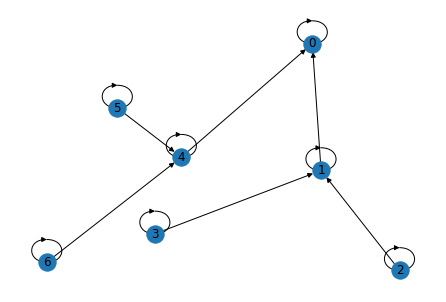

In [ ]:
import networkx as nx
import matplotlib.pyplot as plt
graph = torch_geometric.utils.to_networkx(X_train[0])
nx.draw(graph, with_labels = True)

Each datapoint is a binary tree with root 0 and all edges directed towards the root. Each vertex has a label and a number of "blue" neighbours, stored as node features. Don't be confused - by "blue" we mean what the authors call "blue" in the paper. In the picture above, unfortunately, all nodes have the color blue, but this is not the same thing.  To confuse the reader even further, the "blue" nodes are NOT SHOWN, but are only stored as the node features of each vertex above.

The classification task, is to predict the label of the root. The correct answer, is the label of the LEAF, which has the same number of "blue" neighbours as the root. Each leaf has a unique label ranging from 1 to $2^{depth}$.
In the paper, the "green nodes" are the leaves. It took me a long time to figure out what the paper is saying about this dataset and I think it is easiest to illustrate it on an example:

In [ ]:
print('Target label is: '+ str(X_train[0].y))
print('This is because node 0 has 2 blue neighbors and so does the green node labeled 3. This can be seen here:')
X_train[0].x

Target label is: 3
This is because node 0 has 2 blue neighbors and so does the green node labeled 3. This can be seen here:


tensor([[2, 0],
        [0, 0],
        [1, 2],
        [2, 3],
        [0, 0],
        [3, 4],
        [4, 1]])

Observe that there are $2^{depth}$ labels. This means that the classification task gets "exponentially harder" as the depth grows. This is even before we consider oversquashing, which will have a very significant impact. Since we are dealing with trees, the receptive field of the root node grows exponentially. We can therefore expect that the problem will get very hard very quickly (which is also reported in the paper) as we increase the depth. 

### Implementation of GAT

Let us first try to replicate the results in the paper for classic GATs. This is to make sure that we understand how to work with the dataset, so that we can later implement our model. In everything that follows, I have used the exact same parameters and training set up as in the paper. The architecture used by the authors is one embedding layer, $depth + 1$ GAT layers, $depth + 1$ layer normalization layers, and a final linear layer. In particular, the GATs we will use will always have 4 heads and a hidden dimension of 8 (note that 4*8 = 32).


The code below is more or less copied from their [github repo](hhttps://github.com/tech-srl/bottleneckttps://). I modified some stuff so that in runs in colab, but I tried to make as little change as possible so that nothing breaks. Even though this looks simple, it was not an easy task to figure out what is going on in the github repo, and took me a significant amount of time. 

In [ ]:
from torch import nn
from torch.nn import functional as F
from torch_geometric.nn import GATConv

class GAT(torch.nn.Module):
    def __init__(self,num_layers, dim0, h_dim, out_dim, n_heads,layer_norm = True):
        super(GAT, self).__init__()
    
        self.device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        
        self.num_layers = num_layers
        self.layer0_keys = nn.Embedding(num_embeddings=dim0 + 1, embedding_dim=h_dim)
        self.layer0_values = nn.Embedding(num_embeddings=dim0 + 1, embedding_dim=h_dim)
        self.layers = nn.ModuleList()
        self.layer_norm = layer_norm
        
        if layer_norm:
          self.layer_norms = nn.ModuleList()
          for i in range(num_layers):
            self.layer_norms.append(nn.LayerNorm(h_dim))
       
        self.out_dim = out_dim  
        for i in range(num_layers):
          self.layers.append(GATConv(h_dim,h_dim//n_heads,heads = n_heads))
          
        self.out_layer = nn.Linear(in_features=h_dim, out_features=out_dim + 1, bias=False)

    def forward(self, data):
        x, edge_index, batch, roots = data.x, data.edge_index, data.batch, data.root_mask

        x_key, x_val = x[:, 0], x[:, 1]
        x_key_embed = self.layer0_keys(x_key)
        x_val_embed = self.layer0_values(x_val)
        x = x_key_embed + x_val_embed
        
        for i in range(self.num_layers):
            layer = self.layers[i]
            
            new_x = x
            new_x = layer(new_x, edge_index)  
            x = x + new_x #residual
            if self.layer_norm == True:
              x = self.layer_norms[i](x)
            
        
        root_nodes = x[roots]
        logits = self.out_layer(root_nodes)
        return logits

### Implementation of training

Now we implement the training function (again, this is almost identical to what is on their github). 

In [ ]:
from torch_geometric.data import DataLoader
import numpy as np
import random
from torch.optim.lr_scheduler import ReduceLROnPlateau
from tqdm import tqdm

class Experiment():
    def __init__(self, depth,dim,n_heads,train_fraction,max_epochs,batch_size,eval_every,loader_workers, layer_norm = True):
        
        self.depth = depth
        num_layers = self.depth + 1
        self.dim = dim
       
        self.train_fraction = train_fraction
        self.max_epochs = max_epochs
        self.batch_size = batch_size
        
        self.eval_every = eval_every
        self.loader_workers = loader_workers
        self.device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        

        seed = 11
        torch.manual_seed(seed)
        np.random.seed(seed)
        random.seed(seed)
       

        self.X_train, self.X_test, dim0, out_dim, self.criterion = DictionaryLookupDataset(depth).generate_data(train_fraction)

        
        self.model = GAT(num_layers=num_layers, dim0=dim0, h_dim=self.dim, out_dim=out_dim,n_heads = n_heads, layer_norm = layer_norm).to(self.device)

        print(f'Starting experiment')
        
        print(f'Training examples: {len(self.X_train)}, test examples: {len(self.X_test)}')


    def run(self):
        optimizer = torch.optim.Adam(self.model.parameters(), lr=0.001)
        scheduler = ReduceLROnPlateau(optimizer, mode='max', threshold_mode='abs', factor=0.5, patience=10)
        train_accuracies = []
        test_accuracies = []
        losses = []
        
        for epoch in tqdm(range(1, (self.max_epochs // self.eval_every) + 1)):
            self.model.train()
            loader = DataLoader(self.X_train * self.eval_every, batch_size=self.batch_size, shuffle=True,
                                pin_memory=True, num_workers=self.loader_workers)

            
            total_loss = 0
            total_num_examples = 0
            train_correct = 0
            optimizer.zero_grad()
            for i, batch in enumerate(loader):
                batch = batch.to(self.device)
                out = self.model(batch)
                loss = self.criterion(input=out, target=batch.y)
                total_num_examples += batch.num_graphs
                total_loss += (loss.item() * batch.num_graphs)
                _, train_pred = out.max(dim=1)
                train_correct += train_pred.eq(batch.y).sum().item()

            
                loss.backward()
                
                optimizer.step()
                optimizer.zero_grad()

            avg_training_loss = total_loss / total_num_examples
            train_acc = train_correct / total_num_examples
            print("Training Accuracy:" + str(train_acc))
            print("Loss:" + str(loss.item()))
            scheduler.step(train_acc)

            test_acc = self.eval()
            print("Test Accuracy:" + str(test_acc))
            losses.append(loss.item())
            train_accuracies.append(train_acc)
            test_accuracies.append(test_acc)
            if train_acc >= 0.99:
              break
        return train_accuracies, test_accuracies,losses

    def eval(self):
        self.model.eval()
        with torch.no_grad():
            loader = DataLoader(self.X_test, batch_size=self.batch_size, shuffle=False,
                                pin_memory=True, num_workers=self.loader_workers)

            total_correct = 0
            total_examples = 0
            for batch in loader:
                batch = batch.to(self.device)
                _, pred = self.model(batch).max(dim=1)
                total_correct += pred.eq(batch.y).sum().item()
                total_examples += batch.y.size(0)
            acc = total_correct / total_examples
            return acc

###Evaluation

Let's first see what happens for $depth = 2$:

In [ ]:
e = Experiment(depth = 2, dim = 32,n_heads = 4, train_fraction = 0.8, max_epochs = 50000, batch_size = 64, eval_every = 100,loader_workers = 7)

Starting experiment
Training examples: 76, test examples: 20


In [ ]:
e.model

GAT(
  (layer0_keys): Embedding(5, 32)
  (layer0_values): Embedding(5, 32)
  (layers): ModuleList(
    (0): GATConv(32, 8, heads=4)
    (1): GATConv(32, 8, heads=4)
    (2): GATConv(32, 8, heads=4)
  )
  (layer_norms): ModuleList(
    (0): LayerNorm((32,), eps=1e-05, elementwise_affine=True)
    (1): LayerNorm((32,), eps=1e-05, elementwise_affine=True)
    (2): LayerNorm((32,), eps=1e-05, elementwise_affine=True)
  )
  (out_layer): Linear(in_features=32, out_features=5, bias=False)
)

In [ ]:
train_acc,test_acc,losses = e.run()

  0%|          | 0/500 [00:00<?, ?it/s]/usr/local/lib/python3.8/dist-packages/torch_geometric/deprecation.py:12: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Training Accuracy:0.3030263157894737
Loss:1.2649099826812744


  0%|          | 1/500 [00:02<17:49,  2.14s/it]

Test Accuracy:0.1
Training Accuracy:0.4706578947368421
Loss:0.9371171593666077


  0%|          | 2/500 [00:04<18:05,  2.18s/it]

Test Accuracy:0.2
Training Accuracy:0.7477631578947368
Loss:0.5349785685539246


  1%|          | 3/500 [00:06<18:20,  2.21s/it]

Test Accuracy:0.35
Training Accuracy:0.8913157894736842
Loss:0.24793986976146698


  1%|          | 4/500 [00:08<18:01,  2.18s/it]

Test Accuracy:0.45
Training Accuracy:0.9855263157894737
Loss:0.08617740124464035


  1%|          | 5/500 [00:10<18:03,  2.19s/it]

Test Accuracy:0.65
Training Accuracy:1.0
Loss:0.027241872623562813


  1%|          | 5/500 [00:13<21:34,  2.62s/it]

Test Accuracy:0.7


We quickly overfit the training data - this agrees with what is reported in the paper. 

Let's now look at depth = 3. 

In [ ]:
e = Experiment(depth = 3, dim = 32,n_heads = 4, train_fraction = 0.8, max_epochs = 2000, batch_size = 64, eval_every = 10,loader_workers = 7)

Starting experiment
Training examples: 6400, test examples: 1600


In [ ]:
train_acc,test_acc,losses = e.run()

  0%|          | 0/200 [00:00<?, ?it/s]/usr/local/lib/python3.8/dist-packages/torch_geometric/deprecation.py:12: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Training Accuracy:0.13209375
Loss:2.0677380561828613


  0%|          | 1/200 [00:14<46:51, 14.13s/it]

Test Accuracy:0.14125
Training Accuracy:0.2555
Loss:1.6500310897827148


  1%|          | 2/200 [00:28<46:29, 14.09s/it]

Test Accuracy:0.319375
Training Accuracy:0.364765625
Loss:1.4654383659362793


  2%|▏         | 3/200 [00:42<46:13, 14.08s/it]

Test Accuracy:0.353125
Training Accuracy:0.37996875
Loss:1.1417409181594849


  2%|▏         | 4/200 [00:56<46:07, 14.12s/it]

Test Accuracy:0.3575
Training Accuracy:0.380546875
Loss:1.3417816162109375


  2%|▎         | 5/200 [01:10<45:50, 14.10s/it]

Test Accuracy:0.358125
Training Accuracy:0.3858125
Loss:1.5152791738510132


  3%|▎         | 6/200 [01:24<45:33, 14.09s/it]

Test Accuracy:0.36625
Training Accuracy:0.3831875
Loss:1.4495552778244019


  4%|▎         | 7/200 [01:38<45:02, 14.00s/it]

Test Accuracy:0.350625
Training Accuracy:0.3854375
Loss:1.2997198104858398


  4%|▍         | 8/200 [01:52<44:52, 14.02s/it]

Test Accuracy:0.36
Training Accuracy:0.387125
Loss:1.479285717010498


  4%|▍         | 9/200 [02:06<44:39, 14.03s/it]

Test Accuracy:0.35375
Training Accuracy:0.390453125
Loss:1.4155123233795166


  5%|▌         | 10/200 [02:20<44:38, 14.10s/it]

Test Accuracy:0.36
Training Accuracy:0.3893125
Loss:1.3432388305664062


  6%|▌         | 11/200 [02:34<44:31, 14.14s/it]

Test Accuracy:0.3525
Training Accuracy:0.39171875
Loss:1.2236113548278809


  6%|▌         | 12/200 [02:49<44:27, 14.19s/it]

Test Accuracy:0.359375
Training Accuracy:0.393265625
Loss:1.2143579721450806


  6%|▋         | 13/200 [03:03<44:02, 14.13s/it]

Test Accuracy:0.3425
Training Accuracy:0.3935625
Loss:1.3947727680206299


  7%|▋         | 14/200 [03:17<43:45, 14.12s/it]

Test Accuracy:0.3475
Training Accuracy:0.398453125
Loss:1.4001151323318481


  8%|▊         | 15/200 [03:31<43:37, 14.15s/it]

Test Accuracy:0.3475
Training Accuracy:0.40159375
Loss:1.448595404624939


  8%|▊         | 16/200 [03:45<43:33, 14.20s/it]

Test Accuracy:0.344375
Training Accuracy:0.416796875
Loss:1.2851505279541016


  8%|▊         | 17/200 [04:00<43:25, 14.24s/it]

Test Accuracy:0.36375
Training Accuracy:0.432765625
Loss:1.3316237926483154


  9%|▉         | 18/200 [04:14<43:00, 14.18s/it]

Test Accuracy:0.37625
Training Accuracy:0.4570625
Loss:1.0312789678573608


 10%|▉         | 19/200 [04:28<42:47, 14.19s/it]

Test Accuracy:0.41625
Training Accuracy:0.494109375
Loss:1.0259915590286255


 10%|█         | 20/200 [04:42<42:29, 14.16s/it]

Test Accuracy:0.449375
Training Accuracy:0.524265625
Loss:1.0771427154541016


 10%|█         | 21/200 [04:56<42:02, 14.09s/it]

Test Accuracy:0.461875
Training Accuracy:0.53975
Loss:1.0642752647399902


 11%|█         | 22/200 [05:10<41:45, 14.07s/it]

Test Accuracy:0.491875
Training Accuracy:0.553921875
Loss:0.9213026165962219


 12%|█▏        | 23/200 [05:24<41:40, 14.13s/it]

Test Accuracy:0.506875
Training Accuracy:0.576796875
Loss:0.9694521427154541


 12%|█▏        | 24/200 [05:38<41:18, 14.08s/it]

Test Accuracy:0.53375
Training Accuracy:0.600046875
Loss:0.9606292247772217


 12%|█▎        | 25/200 [05:52<41:06, 14.09s/it]

Test Accuracy:0.549375
Training Accuracy:0.6218125
Loss:0.9187757968902588


 13%|█▎        | 26/200 [06:07<40:54, 14.10s/it]

Test Accuracy:0.575
Training Accuracy:0.637609375
Loss:0.8158190250396729


 14%|█▎        | 27/200 [06:21<40:35, 14.08s/it]

Test Accuracy:0.573125
Training Accuracy:0.65709375
Loss:0.9152523279190063


 14%|█▍        | 28/200 [06:35<40:32, 14.14s/it]

Test Accuracy:0.5875
Training Accuracy:0.681203125
Loss:0.8249585032463074


 14%|█▍        | 29/200 [06:49<40:07, 14.08s/it]

Test Accuracy:0.64125
Training Accuracy:0.718453125
Loss:0.7321566939353943


 15%|█▌        | 30/200 [07:03<39:44, 14.03s/it]

Test Accuracy:0.67625
Training Accuracy:0.7625625
Loss:0.4073779582977295


 16%|█▌        | 31/200 [07:17<39:33, 14.05s/it]

Test Accuracy:0.733125
Training Accuracy:0.806921875
Loss:0.3171360492706299


 16%|█▌        | 32/200 [07:31<39:34, 14.13s/it]

Test Accuracy:0.7725
Training Accuracy:0.854875
Loss:0.3351384997367859


 16%|█▋        | 33/200 [07:45<39:19, 14.13s/it]

Test Accuracy:0.815
Training Accuracy:0.895625
Loss:0.38014712929725647


 17%|█▋        | 34/200 [07:59<39:09, 14.15s/it]

Test Accuracy:0.849375
Training Accuracy:0.92028125
Loss:0.2630748748779297


 18%|█▊        | 35/200 [08:14<38:52, 14.13s/it]

Test Accuracy:0.8825
Training Accuracy:0.936453125
Loss:0.1812926083803177


 18%|█▊        | 36/200 [08:28<38:38, 14.14s/it]

Test Accuracy:0.9025
Training Accuracy:0.953453125
Loss:0.08498814702033997


 18%|█▊        | 37/200 [08:42<38:18, 14.10s/it]

Test Accuracy:0.918125
Training Accuracy:0.964375
Loss:0.061289653182029724


 19%|█▉        | 38/200 [08:56<38:08, 14.13s/it]

Test Accuracy:0.913125
Training Accuracy:0.972078125
Loss:0.06562401354312897


 20%|█▉        | 39/200 [09:10<38:10, 14.22s/it]

Test Accuracy:0.945625
Training Accuracy:0.978265625
Loss:0.0653771460056305


 20%|██        | 40/200 [09:25<37:53, 14.21s/it]

Test Accuracy:0.93875
Training Accuracy:0.984140625
Loss:0.05558532476425171


 20%|██        | 41/200 [09:39<37:32, 14.17s/it]

Test Accuracy:0.95625
Training Accuracy:0.986859375
Loss:0.02216114103794098


 21%|██        | 42/200 [09:53<37:09, 14.11s/it]

Test Accuracy:0.96125
Training Accuracy:0.98734375
Loss:0.019127903506159782


 22%|██▏       | 43/200 [10:07<36:55, 14.11s/it]

Test Accuracy:0.948125
Training Accuracy:0.98821875
Loss:0.06564347445964813


 22%|██▏       | 44/200 [10:21<36:48, 14.16s/it]

Test Accuracy:0.93875
Training Accuracy:0.9906875
Loss:0.021490752696990967


 22%|██▏       | 44/200 [10:35<37:33, 14.45s/it]

Test Accuracy:0.9725


We managed to overfit the data and thus we have succesfully reimplemented the results from the paper for a GAT and depths 2 and 3. We will not try bigger depths (for now), because it's very computationally expensive. Instead, let's implement HopGAT. 

### Implementing HopGAT on TreeNeighborsMatch

Now we would like to evaluate the performance of HopGAT on this dataset. There are two things that we would like to achieve. The first is, that we would like to match the performance of GATs as is reported in the paper, for $depths = 1,2,3,4$. This means that HopGAT should achieve a training accuracy of $1$ (it should overfit the training set). The second is, that we would like to achieve a training accuracy of more than $41\%$ for $depth = 5$. This is the accuracy achieved by GATs that is reported in the paper. By doing so, we would show that HopGAT is more resistant to oversquashing, which would match our intuition. 

Before we begin, one observation. In this dataset, the only relevant information is coming from the leaves of the tree, and everything else is completely irrelevant. This means that in fact, if we wanted to achieve a high accuracy, we should aggregate ONLY over the $depth$-hop neighborhood. Our setup allows us to treat the neighborhoods over which we aggregate as a hyperparameter and we can easily do this. I have decided to include these experiments in the appendix in the section "HopGAT with one attention layer". There you will find that this performs exceptionally well (please do check it out). In a standard GAT, you cannot do this without introducing more layers - in order to receive information from the leaves, you need at least $depth$ number of layers and this will be problematic because of oversquashing. This is another strenght of our model. 

However, in practice, we seldom know which neighborhood we should aggregate over and which to ignore. For this reason, it is important that we experiment with HopGAT which aggregates over all neighborhoods. Thus, in the following experiments, HopGAT will aggregate over all neighborhoods up to $depth$. This means that our model will have an initial embedding layer, a $depth$ number of GAT layers (aggregating over different neighborhoods), a layer normalization layer, an MLP and a final linear layer. If we don't count the layer normalization layers, our model has the same amount of layers as the standard GAT model. However, it does have more parameters, because our final MLP is larger that the final GAT layer (in the previous model), because of the concatenation.  



### Data preparation. 

In order to implement our model, we need to compute the desired $k$ neighborhoods. Now, there is a catch. We cannot just naively use the function provided by [Abboud et al](https://arxiv.org/abs/2206.01003ps://), because it converts the input graph into an undirected graph. The graphs in TreeNeighborsMatch are directed, which makes a difference. To illustrate this, let's naively use the function and plot:


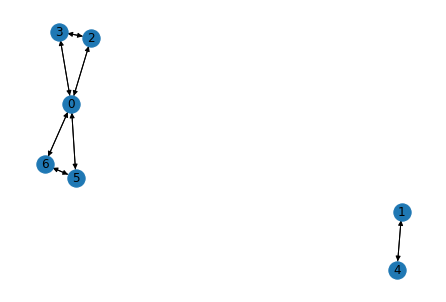

In [ ]:
d = DictionaryLookupDataset(2)

X_train,X_test,dim0, out_dim, criterion = d.generate_data(0.8)
spt = ShortestPathTransform(2)
spt.transform(X_train[0])

#for plotting
import networkx as nx
distance2 = X_train[0].edge_weights == 2
X_train[0].edge_index = X_train[0].edge_index[:,distance2]
graph = torch_geometric.utils.to_networkx(X_train[0])
nx.draw(graph, with_labels = True)

And this is not good. Luckily, we can just take what we need from the aforementioned function. Namely, we need the Floyd Warshall algorithm.

In [ ]:
from scipy.sparse.csgraph import floyd_warshall
from torch_geometric.utils import to_dense_adj

def directed_transform(graph,depth):
  #This is the ugly implementation - instead of storing the edge indices for hop neighborhoods in a dictionary, we store it in separate variables

  adj_matrix = to_dense_adj(graph.edge_index, max_num_nodes=graph.num_nodes)[0]
  shortest_paths = torch.tensor(floyd_warshall(adj_matrix, directed = True), dtype=torch.long)

  edge_index0 = ((shortest_paths == 0).nonzero()).T #dont forget self loops
  edge_index1 = ((shortest_paths == 1).nonzero()).T
  edge_index2 = ((shortest_paths == 2).nonzero()).T
  graph.edge_index1 = torch.cat((edge_index0,edge_index1), dim = 1)
  graph.edge_index2 = edge_index2
  
  if depth >= 3:
    edge_index3 = ((shortest_paths == 3).nonzero()).T
    graph.edge_index3 = edge_index3
  
  if depth >= 4:
    edge_index4 = ((shortest_paths == 4).nonzero()).T
    graph.edge_index4 = edge_index4
  
  if depth >= 5:
    edge_index5 = ((shortest_paths == 5).nonzero()).T
    graph.edge_index5 = edge_index5
  
  return graph 


Let us plot the case $depth = 3$:

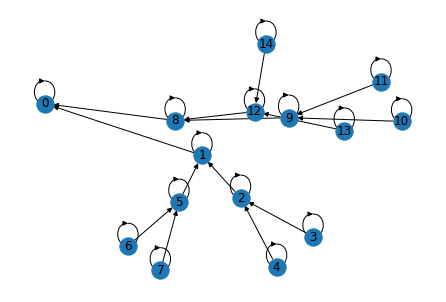

In [ ]:
d = DictionaryLookupDataset(3)
X_train,X_test,dim0, out_dim, criterion = d.generate_data(0.8)
import networkx as nx
graph = X_train[0]
graph = torch_geometric.utils.to_networkx(graph)
nx.draw(graph, with_labels = True)

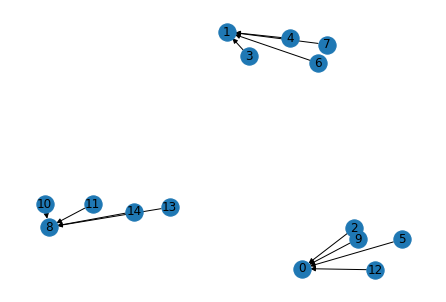

In [ ]:
#let's plot 2 -hop neighborhood
graph = directed_transform(X_train[0],3)

#for plotting
import networkx as nx
graph.edge_index = graph.edge_index2
graph = torch_geometric.utils.to_networkx(graph)
nx.draw(graph, with_labels = True)

Now we need a function to convert each graph in the dataset:

In [ ]:
def generateHopData(depth):
  d = DictionaryLookupDataset(depth)
  X_train,X_test, dim0, out_dim, criterion = d.generate_data(0.8)
  
  for graph in X_train:
    directed_transform(graph,depth)
      
  for graph in X_test:
    directed_transform(graph,depth)
      
  return X_train,X_test,dim0, out_dim, criterion

Now we are ready to implement our models. 

Remark. 

I ran into some difficulties when storing the hop neighborhoods in a dictionary (like before), so I've decided to use a more ugly solution. It is exactly the same idea, it works, but it is not clean. I think the problem was that the dictionaries were not batched together correctly during training, but I am not sure. Furthermore, we will not conduct experiments for $depth > 5$ (due to insufficient computational resources), and our model is implemented with this in mind (which is why it is "ugly").  

### Implementation

Now we prepare our model, HopGAT. The implementation is a bit ugly, but it works. 

In [ ]:
from torch import nn
from torch.nn import functional as F
from torch_geometric.nn import GATConv

class HopGAT(torch.nn.Module):
    def __init__(self, depth, dim0, h_dim, out_dim, n_heads, layer_norm = True):
        super(HopGAT, self).__init__()
  
        self.device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

        self.layer0_keys = nn.Embedding(num_embeddings=dim0 + 1, embedding_dim=h_dim)
        self.layer0_values = nn.Embedding(num_embeddings=dim0 + 1, embedding_dim=h_dim)
        self.depth = depth
        self.out_dim = out_dim
       
        self.gat1 = GATConv(h_dim,h_dim//n_heads,heads = n_heads)
        self.gat2 = GATConv(h_dim,h_dim//n_heads,heads = n_heads)
        
        if depth >= 3:
          self.gat3 = GATConv(h_dim,h_dim//n_heads,heads = n_heads)
        
        if depth >= 4:
          self.gat4 = GATConv(h_dim,h_dim//n_heads,heads = n_heads)
        
        if depth >= 5:
          self.gat5 = GATConv(h_dim,h_dim//n_heads,heads = n_heads)
        
        self.mlp = nn.Linear(h_dim*(depth+1),h_dim)
        self.layer_norm = layer_norm
        if layer_norm:
          self.layer_norms = nn.LayerNorm(h_dim)
        self.out_layer = nn.Linear(in_features=h_dim, out_features=out_dim + 1, bias=False)

    def forward(self, data):
        x, edge_index1, batch, roots,edge_index2 = data.x, data.edge_index1, data.batch, data.root_mask,data.edge_index2

      
        x_key, x_val = x[:, 0], x[:, 1]
        x_key_embed = self.layer0_keys(x_key)
        x_val_embed = self.layer0_values(x_val)
        x = x_key_embed + x_val_embed
        
        if self.depth == 2:
          x = torch.cat((x,self.gat1(x,edge_index1),self.gat2(x,edge_index2)),dim = 1)
        elif self.depth == 3:
          x = torch.cat((x,self.gat1(x,edge_index1),self.gat2(x,edge_index2),self.gat3(x,data.edge_index3)),dim = 1)
        elif self.depth == 4:
          x = torch.cat((x,self.gat1(x,edge_index1),self.gat2(x,edge_index2),self.gat3(x,data.edge_index3),self.gat4(x,data.edge_index4)),dim = 1)
        elif self.depth == 5:
          x = torch.cat((x,self.gat1(x,edge_index1),self.gat2(x,edge_index2),self.gat3(x,data.edge_index3), self.gat4(x,data.edge_index4), self.gat5(x,data.edge_index5)),dim = 1)
        
        x = self.mlp(x)
        if self.layer_norm:
          x = self.layer_norms(x)
            

        root_nodes = x[roots]
        logits = self.out_layer(root_nodes)
        return logits

In [ ]:
from torch_geometric.data import DataLoader
import numpy as np
import random
from torch.optim.lr_scheduler import ReduceLROnPlateau
from tqdm import tqdm

class HopExperiment():
    def __init__(self,depth,dim,n_heads,train_fraction,max_epochs,batch_size,eval_every,loader_workers, layer_norm = True):
        self.dim = dim
       
        self.train_fraction = train_fraction
        self.max_epochs = max_epochs
        self.batch_size = batch_size
        
        self.eval_every = eval_every
        self.loader_workers = loader_workers
        self.device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        

        seed = 11
        torch.manual_seed(seed)
        np.random.seed(seed)
        random.seed(seed)
       
        
        self.X_train, self.X_test, dim0, out_dim, self.criterion = generateHopData(depth)
        self.model = HopGAT(depth,dim0=dim0, h_dim=self.dim, out_dim=out_dim,n_heads = n_heads, layer_norm = layer_norm).to(self.device)
        
        print(f'Starting experiment')
        
        print(f'Training examples: {len(self.X_train)}, test examples: {len(self.X_test)}')


    def run(self):
        optimizer = torch.optim.Adam(self.model.parameters(), lr=0.001)
        scheduler = ReduceLROnPlateau(optimizer, mode='max', threshold_mode='abs', factor=0.5, patience=10)
        train_accuracies = []
        test_accuracies = []
        losses = []
        
        for epoch in tqdm(range(1, (self.max_epochs // self.eval_every) + 1)):
            self.model.train()
            loader = DataLoader(self.X_train * self.eval_every, batch_size=self.batch_size, shuffle=True,
                                pin_memory=True, num_workers=self.loader_workers)

            
            total_loss = 0
            total_num_examples = 0
            train_correct = 0
            optimizer.zero_grad()
            for i, batch in enumerate(loader):
                batch = batch.to(self.device)
                out = self.model(batch)
                loss = self.criterion(input=out, target=batch.y)
                total_num_examples += batch.num_graphs
                total_loss += (loss.item() * batch.num_graphs)
                _, train_pred = out.max(dim=1)
                train_correct += train_pred.eq(batch.y).sum().item()

            
                loss.backward()
                
                optimizer.step()
                optimizer.zero_grad()

            avg_training_loss = total_loss / total_num_examples
            train_acc = train_correct / total_num_examples
            print("Training Accuracy:" + str(train_acc))
            print("Loss:" + str(loss.item()))
            scheduler.step(train_acc)

            test_acc = self.eval()
            print("Test Accuracy:" + str(test_acc))
            losses.append(loss.item())
            train_accuracies.append(train_acc)
            test_accuracies.append(test_acc)

            if train_acc >= 0.99:
              break

        return train_accuracies, test_accuracies,losses,self.model

    def eval(self):
        self.model.eval()
        with torch.no_grad():
            loader = DataLoader(self.X_test, batch_size=self.batch_size, shuffle=False,
                                pin_memory=True, num_workers=self.loader_workers)

            total_correct = 0
            total_examples = 0
            for batch in loader:
                batch = batch.to(self.device)
                _, pred = self.model(batch).max(dim=1)
                total_correct += pred.eq(batch.y).sum().item()
                total_examples += batch.y.size(0)
            acc = total_correct / total_examples
            return acc

### Evaluation 

Let us train our model on the dataset for $depth = 2$:

In [ ]:
e = HopExperiment(depth = 2,dim = 32,n_heads = 4, train_fraction = 0.8, max_epochs = 50000, batch_size = 64, eval_every = 100,loader_workers = 7)

Starting experiment
Training examples: 76, test examples: 20


In [ ]:
e.model

HopGAT(
  (layer0_keys): Embedding(5, 32)
  (layer0_values): Embedding(5, 32)
  (gat1): GATConv(32, 8, heads=4)
  (gat2): GATConv(32, 8, heads=4)
  (mlp): Linear(in_features=96, out_features=32, bias=True)
  (layer_norm): LayerNorm((32,), eps=1e-05, elementwise_affine=True)
  (out_layer): Linear(in_features=32, out_features=5, bias=False)
)

In [ ]:
train_acc,test_acc,loss,TwoHopModel = e.run()

  0%|          | 0/500 [00:00<?, ?it/s]/usr/local/lib/python3.8/dist-packages/torch_geometric/deprecation.py:12: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Training Accuracy:0.41
Loss:0.7453638911247253


  0%|          | 1/500 [00:05<42:50,  5.15s/it]

Test Accuracy:0.35
Training Accuracy:0.8421052631578947
Loss:0.27823829650878906


  0%|          | 2/500 [00:07<27:43,  3.34s/it]

Test Accuracy:0.6
Training Accuracy:0.9582894736842106
Loss:0.22952772676944733


  1%|          | 3/500 [00:09<22:59,  2.78s/it]

Test Accuracy:0.65
Training Accuracy:0.9852631578947368
Loss:0.029837550595402718


  1%|          | 4/500 [00:11<20:32,  2.49s/it]

Test Accuracy:0.65
Training Accuracy:0.9977631578947368
Loss:0.046467553824186325


  1%|          | 4/500 [00:13<27:53,  3.37s/it]

Test Accuracy:0.6


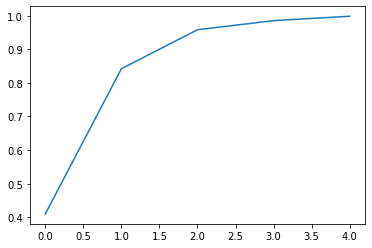

In [ ]:
import matplotlib.pyplot as plt
plt.plot(train_acc)

We overfit the dataset very quickly, similarly as in the case of a three layer GAT. Now $depth = 3$:

In [ ]:
e = HopExperiment(depth = 3,dim = 32,n_heads = 4, train_fraction = 0.8, max_epochs = 1200, batch_size = 64, eval_every = 10,loader_workers = 2)

Starting experiment
Training examples: 6400, test examples: 1600


In [ ]:
e.model

HopGAT(
  (layer0_keys): Embedding(9, 32)
  (layer0_values): Embedding(9, 32)
  (gat1): GATConv(32, 8, heads=4)
  (gat2): GATConv(32, 8, heads=4)
  (gat3): GATConv(32, 8, heads=4)
  (mlp): Linear(in_features=128, out_features=32, bias=True)
  (layer_norm): LayerNorm((32,), eps=1e-05, elementwise_affine=True)
  (out_layer): Linear(in_features=32, out_features=9, bias=False)
)

In [ ]:
train_acc,test_acc,loss,ThreeHopModel = e.run()

  0%|          | 0/120 [00:00<?, ?it/s]/usr/local/lib/python3.8/dist-packages/torch_geometric/deprecation.py:12: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Training Accuracy:0.260109375
Loss:1.6725132465362549


  1%|          | 1/120 [00:16<33:19, 16.80s/it]

Test Accuracy:0.338125
Training Accuracy:0.43290625
Loss:1.3135507106781006


  2%|▏         | 2/120 [00:33<33:00, 16.79s/it]

Test Accuracy:0.449375
Training Accuracy:0.533609375
Loss:1.0136282444000244


  2%|▎         | 3/120 [00:50<32:29, 16.66s/it]

Test Accuracy:0.545
Training Accuracy:0.6963125
Loss:0.42185842990875244


  3%|▎         | 4/120 [01:06<32:16, 16.69s/it]

Test Accuracy:0.76375
Training Accuracy:0.90728125
Loss:0.1793455183506012


  4%|▍         | 5/120 [01:23<31:56, 16.66s/it]

Test Accuracy:0.969375
Training Accuracy:0.974078125
Loss:0.050118912011384964


  5%|▌         | 6/120 [01:40<31:40, 16.67s/it]

Test Accuracy:0.990625
Training Accuracy:0.98659375
Loss:0.03713541477918625


  6%|▌         | 7/120 [01:56<31:25, 16.69s/it]

Test Accuracy:0.998125
Training Accuracy:0.990109375
Loss:0.023159224539995193


  6%|▌         | 7/120 [02:13<35:50, 19.04s/it]

Test Accuracy:0.9975


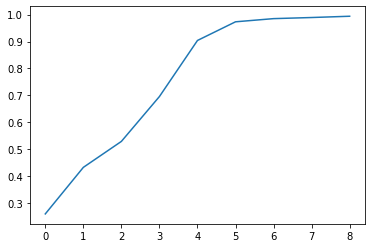

In [ ]:
plt.plot(train_acc)

We managed to overfit the dataset and achieve a very high test accuracy. Furthermore, the model converged much faster than the four layer GAT implemented previously. This could mean that our model is more suited for this dataset (which is what we expect), but we need to bear in mind that our model does have more parameters, because of the concatenation and MLP. 

Due to the fast convergence of our model, let us try $depth = 4$. To do so, we will use the same training settings as the authors did in the paper. This will mean that training will most likely take a long time, but if we wish to explore the case $depth = 5$, we first better do $depth = 4$ properly. 

In [ ]:
e = HopExperiment(depth = 4,dim = 32,n_heads = 4, train_fraction = 0.8, max_epochs = 50000, batch_size = 1024, eval_every = 100,loader_workers = 7)

Starting experiment
Training examples: 12800, test examples: 3200


In [ ]:
e.model

HopGAT(
  (layer0_keys): Embedding(17, 32)
  (layer0_values): Embedding(17, 32)
  (gat1): GATConv(32, 8, heads=4)
  (gat2): GATConv(32, 8, heads=4)
  (gat3): GATConv(32, 8, heads=4)
  (gat4): GATConv(32, 8, heads=4)
  (mlp): Linear(in_features=160, out_features=32, bias=True)
  (layer_norms): LayerNorm((32,), eps=1e-05, elementwise_affine=True)
  (out_layer): Linear(in_features=32, out_features=17, bias=False)
)

In [ ]:
sum(p.numel() for p in e.model.parameters())

11328

In [ ]:
train_acc,test_acc,loss,FourHopModel = e.run()

  0%|          | 0/500 [00:00<?, ?it/s]/usr/local/lib/python3.8/dist-packages/torch_geometric/deprecation.py:12: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Training Accuracy:0.1812140625
Loss:2.2679429054260254


  0%|          | 1/500 [00:32<4:28:42, 32.31s/it]

Test Accuracy:0.2284375
Training Accuracy:0.31337578125
Loss:1.9182343482971191


  0%|          | 2/500 [01:05<4:30:39, 32.61s/it]

Test Accuracy:0.32125
Training Accuracy:0.35901171875
Loss:1.8481417894363403


  1%|          | 3/500 [01:37<4:29:21, 32.52s/it]

Test Accuracy:0.341875
Training Accuracy:0.401728125
Loss:1.6339060068130493


  1%|          | 4/500 [02:10<4:30:45, 32.75s/it]

Test Accuracy:0.4084375
Training Accuracy:0.4392125
Loss:1.569912075996399


  1%|          | 5/500 [02:43<4:29:01, 32.61s/it]

Test Accuracy:0.4290625
Training Accuracy:0.4629640625
Loss:1.4957228899002075


  1%|          | 6/500 [03:15<4:27:53, 32.54s/it]

Test Accuracy:0.4659375
Training Accuracy:0.5049921875
Loss:1.376282811164856


  1%|▏         | 7/500 [03:48<4:29:16, 32.77s/it]

Test Accuracy:0.5046875
Training Accuracy:0.54778203125
Loss:1.176908254623413


  2%|▏         | 8/500 [04:21<4:29:02, 32.81s/it]

Test Accuracy:0.55875
Training Accuracy:0.58825703125
Loss:1.1505711078643799


  2%|▏         | 9/500 [04:54<4:29:08, 32.89s/it]

Test Accuracy:0.579375
Training Accuracy:0.60312109375
Loss:1.0422556400299072


  2%|▏         | 10/500 [05:28<4:30:10, 33.08s/it]

Test Accuracy:0.59375
Training Accuracy:0.6143953125
Loss:0.9732475876808167


  2%|▏         | 11/500 [06:00<4:28:53, 32.99s/it]

Test Accuracy:0.6084375
Training Accuracy:0.62165078125
Loss:1.0059946775436401


  2%|▏         | 12/500 [06:34<4:30:37, 33.27s/it]

Test Accuracy:0.6171875
Training Accuracy:0.6250984375
Loss:0.9864656329154968


  3%|▎         | 13/500 [07:08<4:30:51, 33.37s/it]

Test Accuracy:0.6153125
Training Accuracy:0.624259375
Loss:0.9517157077789307


  3%|▎         | 14/500 [07:41<4:30:05, 33.34s/it]

Test Accuracy:0.6146875
Training Accuracy:0.61939140625
Loss:0.9674901962280273


  3%|▎         | 15/500 [08:14<4:27:22, 33.08s/it]

Test Accuracy:0.6140625
Training Accuracy:0.63015625
Loss:1.051153302192688


  3%|▎         | 16/500 [08:47<4:26:39, 33.06s/it]

Test Accuracy:0.5828125
Training Accuracy:0.6301125
Loss:0.9043712615966797


  3%|▎         | 17/500 [09:20<4:25:56, 33.04s/it]

Test Accuracy:0.6228125
Training Accuracy:0.634925
Loss:0.9897181987762451


  4%|▎         | 18/500 [09:53<4:25:02, 32.99s/it]

Test Accuracy:0.624375
Training Accuracy:0.63018359375
Loss:0.9108412265777588


  4%|▍         | 19/500 [10:26<4:24:43, 33.02s/it]

Test Accuracy:0.6234375
Training Accuracy:0.63804140625
Loss:0.8440123200416565


  4%|▍         | 20/500 [10:59<4:24:23, 33.05s/it]

Test Accuracy:0.6184375
Training Accuracy:0.64112265625
Loss:0.8905049562454224


  4%|▍         | 21/500 [11:31<4:22:47, 32.92s/it]

Test Accuracy:0.6309375
Training Accuracy:0.6424828125
Loss:0.8916734457015991


  4%|▍         | 22/500 [12:05<4:24:44, 33.23s/it]

Test Accuracy:0.6203125
Training Accuracy:0.6389875
Loss:0.9843016862869263


  5%|▍         | 23/500 [12:38<4:22:48, 33.06s/it]

Test Accuracy:0.6215625
Training Accuracy:0.6436296875
Loss:0.866924524307251


  5%|▍         | 24/500 [13:12<4:23:43, 33.24s/it]

Test Accuracy:0.6228125
Training Accuracy:0.64574296875
Loss:0.895488440990448


  5%|▌         | 25/500 [13:45<4:22:34, 33.17s/it]

Test Accuracy:0.63875
Training Accuracy:0.6463515625
Loss:0.9482425451278687


  5%|▌         | 26/500 [14:19<4:23:43, 33.38s/it]

Test Accuracy:0.6315625
Training Accuracy:0.64957734375
Loss:0.901479959487915


  5%|▌         | 27/500 [14:52<4:23:02, 33.37s/it]

Test Accuracy:0.6353125
Training Accuracy:0.6430625
Loss:0.8525658249855042


  6%|▌         | 28/500 [15:25<4:21:40, 33.26s/it]

Test Accuracy:0.6315625
Training Accuracy:0.65083359375
Loss:1.3877512216567993


  6%|▌         | 29/500 [15:59<4:22:04, 33.39s/it]

Test Accuracy:0.59125
Training Accuracy:0.6512203125
Loss:0.930452287197113


  6%|▌         | 30/500 [16:32<4:20:55, 33.31s/it]

Test Accuracy:0.6421875
Training Accuracy:0.6545171875
Loss:0.8493182063102722


  6%|▌         | 31/500 [17:04<4:18:47, 33.11s/it]

Test Accuracy:0.6415625
Training Accuracy:0.65553046875
Loss:0.8768190145492554


  6%|▋         | 32/500 [17:38<4:19:14, 33.24s/it]

Test Accuracy:0.6446875
Training Accuracy:0.65710859375
Loss:0.9570980072021484


  7%|▋         | 33/500 [18:11<4:18:05, 33.16s/it]

Test Accuracy:0.633125
Training Accuracy:0.65591015625
Loss:0.8057040572166443


  7%|▋         | 34/500 [18:44<4:18:32, 33.29s/it]

Test Accuracy:0.6415625
Training Accuracy:0.65708359375
Loss:0.8460528254508972


  7%|▋         | 35/500 [19:18<4:17:34, 33.24s/it]

Test Accuracy:0.6415625
Training Accuracy:0.658946875
Loss:0.9094069600105286


  7%|▋         | 36/500 [19:50<4:15:54, 33.09s/it]

Test Accuracy:0.6478125
Training Accuracy:0.6655171875
Loss:0.8897343277931213


  7%|▋         | 37/500 [20:23<4:14:23, 32.97s/it]

Test Accuracy:0.65125
Training Accuracy:0.66680546875
Loss:0.8254570960998535


  8%|▊         | 38/500 [20:56<4:14:11, 33.01s/it]

Test Accuracy:0.6503125
Training Accuracy:0.6722203125
Loss:0.9110193252563477


  8%|▊         | 39/500 [21:29<4:13:58, 33.06s/it]

Test Accuracy:0.645625
Training Accuracy:0.6711546875
Loss:0.8571058511734009


  8%|▊         | 40/500 [22:02<4:13:48, 33.11s/it]

Test Accuracy:0.6490625
Training Accuracy:0.6744359375
Loss:0.7672392725944519


  8%|▊         | 41/500 [22:36<4:13:11, 33.10s/it]

Test Accuracy:0.66375
Training Accuracy:0.6759375
Loss:0.8373052477836609


  8%|▊         | 42/500 [23:09<4:13:07, 33.16s/it]

Test Accuracy:0.663125
Training Accuracy:0.67919765625
Loss:0.8504107594490051


  9%|▊         | 43/500 [23:42<4:12:53, 33.20s/it]

Test Accuracy:0.664375
Training Accuracy:0.67834296875
Loss:0.7883958220481873


  9%|▉         | 44/500 [24:16<4:13:13, 33.32s/it]

Test Accuracy:0.6615625
Training Accuracy:0.6804859375
Loss:0.7774575352668762


  9%|▉         | 45/500 [24:49<4:12:12, 33.26s/it]

Test Accuracy:0.661875
Training Accuracy:0.682040625
Loss:0.958646833896637


  9%|▉         | 46/500 [25:22<4:10:52, 33.16s/it]

Test Accuracy:0.6465625
Training Accuracy:0.68512421875
Loss:0.7884064316749573


  9%|▉         | 47/500 [25:54<4:09:01, 32.98s/it]

Test Accuracy:0.66625
Training Accuracy:0.68588359375
Loss:0.8561486005783081


 10%|▉         | 48/500 [26:28<4:09:11, 33.08s/it]

Test Accuracy:0.6678125
Training Accuracy:0.6889296875
Loss:0.7714627385139465


 10%|▉         | 49/500 [27:01<4:08:36, 33.07s/it]

Test Accuracy:0.6734375
Training Accuracy:0.68416328125
Loss:0.7456932663917542


 10%|█         | 50/500 [27:34<4:08:01, 33.07s/it]

Test Accuracy:0.6775
Training Accuracy:0.69140234375
Loss:0.7797964215278625


 10%|█         | 51/500 [28:07<4:07:23, 33.06s/it]

Test Accuracy:0.6721875
Training Accuracy:0.69326484375
Loss:0.77764493227005


 10%|█         | 52/500 [28:39<4:05:36, 32.89s/it]

Test Accuracy:0.6771875
Training Accuracy:0.6917
Loss:0.7420260906219482


 11%|█         | 53/500 [29:11<4:03:12, 32.65s/it]

Test Accuracy:0.680625
Training Accuracy:0.69572265625
Loss:0.7828013896942139


 11%|█         | 54/500 [29:44<4:02:41, 32.65s/it]

Test Accuracy:0.676875
Training Accuracy:0.69514140625
Loss:0.7062178254127502


 11%|█         | 55/500 [30:17<4:02:52, 32.75s/it]

Test Accuracy:0.6878125
Training Accuracy:0.69628984375
Loss:0.6831279993057251


 11%|█         | 56/500 [30:52<4:06:27, 33.30s/it]

Test Accuracy:0.68875
Training Accuracy:0.69876328125
Loss:0.7962037324905396


 11%|█▏        | 57/500 [31:25<4:06:13, 33.35s/it]

Test Accuracy:0.681875
Training Accuracy:0.69863828125
Loss:0.7279213070869446


 12%|█▏        | 58/500 [31:59<4:07:03, 33.54s/it]

Test Accuracy:0.68375
Training Accuracy:0.70123359375
Loss:0.7148534059524536


 12%|█▏        | 59/500 [32:33<4:06:37, 33.55s/it]

Test Accuracy:0.6878125
Training Accuracy:0.70086328125
Loss:0.7184721231460571


 12%|█▏        | 60/500 [33:07<4:08:05, 33.83s/it]

Test Accuracy:0.685
Training Accuracy:0.70280234375
Loss:2.020866632461548


 12%|█▏        | 61/500 [33:41<4:08:29, 33.96s/it]

Test Accuracy:0.6034375
Training Accuracy:0.70239375
Loss:0.7311447858810425


 12%|█▏        | 62/500 [34:16<4:08:15, 34.01s/it]

Test Accuracy:0.6953125
Training Accuracy:0.70258828125
Loss:0.7043666839599609


 13%|█▎        | 63/500 [34:49<4:06:59, 33.91s/it]

Test Accuracy:0.6978125
Training Accuracy:0.7055859375
Loss:0.6815489530563354


 13%|█▎        | 64/500 [35:23<4:05:35, 33.80s/it]

Test Accuracy:0.6975
Training Accuracy:0.7044
Loss:0.6391801834106445


 13%|█▎        | 65/500 [35:56<4:04:34, 33.73s/it]

Test Accuracy:0.691875
Training Accuracy:0.7028484375
Loss:0.6704010963439941


 13%|█▎        | 66/500 [36:30<4:03:50, 33.71s/it]

Test Accuracy:0.695625
Training Accuracy:0.7062875
Loss:0.6787133812904358


 13%|█▎        | 67/500 [37:03<4:01:14, 33.43s/it]

Test Accuracy:0.6896875
Training Accuracy:0.700809375
Loss:0.7337050437927246


 14%|█▎        | 68/500 [37:37<4:01:28, 33.54s/it]

Test Accuracy:0.671875
Training Accuracy:0.70706171875
Loss:0.6825273633003235


 14%|█▍        | 69/500 [38:10<4:00:47, 33.52s/it]

Test Accuracy:0.695
Training Accuracy:0.70596015625
Loss:0.6310837268829346


 14%|█▍        | 70/500 [38:43<3:59:27, 33.41s/it]

Test Accuracy:0.699375
Training Accuracy:0.70707265625
Loss:0.6797354817390442


 14%|█▍        | 71/500 [39:16<3:58:35, 33.37s/it]

Test Accuracy:0.69625
Training Accuracy:0.70681484375
Loss:0.6564921736717224


 14%|█▍        | 72/500 [39:51<3:59:49, 33.62s/it]

Test Accuracy:0.6925
Training Accuracy:0.70669609375
Loss:0.6752825975418091


 15%|█▍        | 73/500 [40:24<3:59:09, 33.61s/it]

Test Accuracy:0.6971875
Training Accuracy:0.70775234375
Loss:0.7035309076309204


 15%|█▍        | 74/500 [40:58<3:58:15, 33.56s/it]

Test Accuracy:0.69125
Training Accuracy:0.70873828125
Loss:0.6355517506599426


 15%|█▌        | 75/500 [41:31<3:56:21, 33.37s/it]

Test Accuracy:0.69375
Training Accuracy:0.70860625
Loss:0.626035749912262


 15%|█▌        | 76/500 [42:04<3:54:59, 33.25s/it]

Test Accuracy:0.6940625
Training Accuracy:0.70896484375
Loss:0.6944440603256226


 15%|█▌        | 77/500 [42:36<3:53:28, 33.12s/it]

Test Accuracy:0.7
Training Accuracy:0.7101
Loss:0.6151452660560608


 16%|█▌        | 78/500 [43:09<3:51:36, 32.93s/it]

Test Accuracy:0.6953125
Training Accuracy:0.71024140625
Loss:0.6847092509269714


 16%|█▌        | 79/500 [43:42<3:52:16, 33.10s/it]

Test Accuracy:0.7053125
Training Accuracy:0.70693046875
Loss:0.7086899280548096


 16%|█▌        | 80/500 [44:16<3:52:06, 33.16s/it]

Test Accuracy:0.696875
Training Accuracy:0.71123203125
Loss:1.2632839679718018


 16%|█▌        | 81/500 [44:48<3:49:26, 32.86s/it]

Test Accuracy:0.5715625
Training Accuracy:0.71016484375
Loss:0.6379689574241638


 16%|█▋        | 82/500 [45:21<3:48:35, 32.81s/it]

Test Accuracy:0.7025
Training Accuracy:0.71116328125
Loss:0.69377601146698


 17%|█▋        | 83/500 [45:54<3:48:28, 32.87s/it]

Test Accuracy:0.6971875
Training Accuracy:0.71196953125
Loss:0.7161679267883301


 17%|█▋        | 84/500 [46:27<3:49:20, 33.08s/it]

Test Accuracy:0.688125
Training Accuracy:0.7112171875
Loss:0.6205490827560425


 17%|█▋        | 85/500 [47:00<3:48:31, 33.04s/it]

Test Accuracy:0.699375
Training Accuracy:0.7123671875
Loss:0.663723349571228


 17%|█▋        | 86/500 [47:34<3:49:19, 33.23s/it]

Test Accuracy:0.7
Training Accuracy:0.71349609375
Loss:0.5936393737792969


 17%|█▋        | 87/500 [48:07<3:49:10, 33.29s/it]

Test Accuracy:0.7009375
Training Accuracy:0.71235625
Loss:0.693078875541687


 18%|█▊        | 88/500 [48:40<3:48:03, 33.21s/it]

Test Accuracy:0.7040625
Training Accuracy:0.71312421875
Loss:0.6866102814674377


 18%|█▊        | 89/500 [49:13<3:47:31, 33.22s/it]

Test Accuracy:0.699375
Training Accuracy:0.71203046875
Loss:0.7225830554962158


 18%|█▊        | 90/500 [49:47<3:48:36, 33.46s/it]

Test Accuracy:0.698125
Training Accuracy:0.7150734375
Loss:0.6529017686843872


 18%|█▊        | 91/500 [50:21<3:47:58, 33.44s/it]

Test Accuracy:0.705
Training Accuracy:0.71243359375
Loss:0.6820367574691772


 18%|█▊        | 92/500 [50:54<3:47:42, 33.49s/it]

Test Accuracy:0.7053125
Training Accuracy:0.71353046875
Loss:0.6119827628135681


 19%|█▊        | 93/500 [51:28<3:46:24, 33.38s/it]

Test Accuracy:0.7028125
Training Accuracy:0.7129484375
Loss:0.6650078892707825


 19%|█▉        | 94/500 [52:01<3:45:04, 33.26s/it]

Test Accuracy:0.7
Training Accuracy:0.7146890625
Loss:0.6622811555862427


 19%|█▉        | 95/500 [52:33<3:43:39, 33.13s/it]

Test Accuracy:0.7025
Training Accuracy:0.71346953125
Loss:0.7461655735969543


 19%|█▉        | 96/500 [53:07<3:43:15, 33.16s/it]

Test Accuracy:0.701875
Training Accuracy:0.714684375
Loss:0.6651971340179443


 19%|█▉        | 97/500 [53:40<3:42:15, 33.09s/it]

Test Accuracy:0.7028125
Training Accuracy:0.7132671875
Loss:0.6334384679794312


 20%|█▉        | 98/500 [54:12<3:41:10, 33.01s/it]

Test Accuracy:0.7003125
Training Accuracy:0.71475078125
Loss:0.6630948185920715


 20%|█▉        | 99/500 [54:46<3:42:50, 33.34s/it]

Test Accuracy:0.703125
Training Accuracy:0.71596328125
Loss:0.6599699258804321


 20%|██        | 100/500 [55:21<3:44:11, 33.63s/it]

Test Accuracy:0.7025
Training Accuracy:0.717415625
Loss:0.666926383972168


 20%|██        | 101/500 [55:53<3:41:37, 33.33s/it]

Test Accuracy:0.703125
Training Accuracy:0.7136
Loss:0.6633003354072571


 20%|██        | 102/500 [56:26<3:40:35, 33.25s/it]

Test Accuracy:0.7084375
Training Accuracy:0.715821875
Loss:0.6429771780967712


 21%|██        | 103/500 [57:00<3:39:54, 33.23s/it]

Test Accuracy:0.7
Training Accuracy:0.71550703125
Loss:0.6217657327651978


 21%|██        | 104/500 [57:33<3:39:38, 33.28s/it]

Test Accuracy:0.705625
Training Accuracy:0.7188328125
Loss:0.628548800945282


 21%|██        | 105/500 [58:07<3:39:59, 33.42s/it]

Test Accuracy:0.7028125
Training Accuracy:0.71858125
Loss:0.6462756991386414


 21%|██        | 106/500 [58:40<3:38:25, 33.26s/it]

Test Accuracy:0.7028125
Training Accuracy:0.71530390625
Loss:0.6177418231964111


 21%|██▏       | 107/500 [59:13<3:38:10, 33.31s/it]

Test Accuracy:0.70375
Training Accuracy:0.718928125
Loss:0.6498222351074219


 22%|██▏       | 108/500 [59:46<3:36:33, 33.15s/it]

Test Accuracy:0.7034375
Training Accuracy:0.71752109375
Loss:0.640125572681427


 22%|██▏       | 109/500 [1:00:19<3:36:45, 33.26s/it]

Test Accuracy:0.7015625
Training Accuracy:0.71917578125
Loss:0.6527941226959229


 22%|██▏       | 110/500 [1:00:54<3:38:23, 33.60s/it]

Test Accuracy:0.6971875
Training Accuracy:0.71742890625
Loss:0.6875696778297424


 22%|██▏       | 111/500 [1:01:27<3:37:49, 33.60s/it]

Test Accuracy:0.704375
Training Accuracy:0.718640625
Loss:0.6237817406654358


 22%|██▏       | 112/500 [1:02:01<3:37:17, 33.60s/it]

Test Accuracy:0.7
Training Accuracy:0.71968125
Loss:0.6853148341178894


 23%|██▎       | 113/500 [1:02:35<3:37:16, 33.69s/it]

Test Accuracy:0.7059375
Training Accuracy:0.721071875
Loss:0.6044625639915466


 23%|██▎       | 114/500 [1:03:09<3:37:35, 33.82s/it]

Test Accuracy:0.7059375
Training Accuracy:0.7197359375
Loss:0.6546567678451538


 23%|██▎       | 115/500 [1:03:43<3:36:49, 33.79s/it]

Test Accuracy:0.7040625
Training Accuracy:0.72244453125
Loss:0.6413964629173279


 23%|██▎       | 116/500 [1:04:18<3:38:39, 34.16s/it]

Test Accuracy:0.709375
Training Accuracy:0.7214875
Loss:0.6472906470298767


 23%|██▎       | 117/500 [1:04:51<3:36:32, 33.92s/it]

Test Accuracy:0.698125
Training Accuracy:0.72119765625
Loss:0.5876544117927551


 24%|██▎       | 118/500 [1:05:25<3:35:15, 33.81s/it]

Test Accuracy:0.70625
Training Accuracy:0.724709375
Loss:0.6012872457504272


 24%|██▍       | 119/500 [1:05:58<3:33:26, 33.61s/it]

Test Accuracy:0.709375
Training Accuracy:0.72200390625
Loss:0.9123603701591492


 24%|██▍       | 120/500 [1:06:31<3:31:25, 33.38s/it]

Test Accuracy:0.6378125
Training Accuracy:0.72278359375
Loss:0.6468470096588135


 24%|██▍       | 121/500 [1:07:04<3:30:32, 33.33s/it]

Test Accuracy:0.7090625
Training Accuracy:0.724215625
Loss:0.6154780387878418


 24%|██▍       | 122/500 [1:07:38<3:30:36, 33.43s/it]

Test Accuracy:0.7090625
Training Accuracy:0.72626328125
Loss:0.6689385175704956


 25%|██▍       | 123/500 [1:08:12<3:31:18, 33.63s/it]

Test Accuracy:0.7103125
Training Accuracy:0.72406796875
Loss:0.583465576171875


 25%|██▍       | 124/500 [1:08:45<3:29:49, 33.48s/it]

Test Accuracy:0.7109375
Training Accuracy:0.7277625
Loss:0.672599196434021


 25%|██▌       | 125/500 [1:09:17<3:27:28, 33.20s/it]

Test Accuracy:0.7140625
Training Accuracy:0.72705625
Loss:0.5960650444030762


 25%|██▌       | 126/500 [1:09:50<3:26:49, 33.18s/it]

Test Accuracy:0.715
Training Accuracy:0.72640078125
Loss:0.6100271940231323


 25%|██▌       | 127/500 [1:10:24<3:26:47, 33.27s/it]

Test Accuracy:0.715
Training Accuracy:0.72802265625
Loss:0.6223520040512085


 26%|██▌       | 128/500 [1:10:56<3:24:29, 32.98s/it]

Test Accuracy:0.714375
Training Accuracy:0.72766171875
Loss:0.66348797082901


 26%|██▌       | 129/500 [1:11:29<3:23:07, 32.85s/it]

Test Accuracy:0.715
Training Accuracy:0.7305203125
Loss:0.6208019256591797


 26%|██▌       | 130/500 [1:12:01<3:21:35, 32.69s/it]

Test Accuracy:0.7171875
Training Accuracy:0.72775078125
Loss:0.6457095146179199


 26%|██▌       | 131/500 [1:12:34<3:20:47, 32.65s/it]

Test Accuracy:0.7103125
Training Accuracy:0.73015625
Loss:0.6307446360588074


 26%|██▋       | 132/500 [1:13:07<3:21:35, 32.87s/it]

Test Accuracy:0.7121875
Training Accuracy:0.72973046875
Loss:0.6153530478477478


 27%|██▋       | 133/500 [1:13:40<3:21:12, 32.89s/it]

Test Accuracy:0.7165625
Training Accuracy:0.73165859375
Loss:0.6126680970191956


 27%|██▋       | 134/500 [1:14:13<3:21:36, 33.05s/it]

Test Accuracy:0.714375
Training Accuracy:0.73218984375
Loss:0.5767456293106079


 27%|██▋       | 135/500 [1:14:46<3:20:51, 33.02s/it]

Test Accuracy:0.7165625
Training Accuracy:0.734534375
Loss:0.6612526178359985


 27%|██▋       | 136/500 [1:15:20<3:21:30, 33.22s/it]

Test Accuracy:0.715625
Training Accuracy:0.73266484375
Loss:0.6012638211250305


 27%|██▋       | 137/500 [1:15:53<3:21:01, 33.23s/it]

Test Accuracy:0.718125
Training Accuracy:0.73515234375
Loss:0.6255563497543335


 28%|██▊       | 138/500 [1:16:26<3:20:08, 33.17s/it]

Test Accuracy:0.721875
Training Accuracy:0.734921875
Loss:0.6225700974464417


 28%|██▊       | 139/500 [1:17:01<3:22:12, 33.61s/it]

Test Accuracy:0.720625
Training Accuracy:0.73766953125
Loss:0.6039020419120789


 28%|██▊       | 140/500 [1:17:35<3:23:15, 33.88s/it]

Test Accuracy:0.7221875
Training Accuracy:0.740496875
Loss:0.6217020153999329


 28%|██▊       | 141/500 [1:18:08<3:20:57, 33.59s/it]

Test Accuracy:0.7140625
Training Accuracy:0.74108984375
Loss:0.5957228541374207


 28%|██▊       | 142/500 [1:18:42<3:20:45, 33.65s/it]

Test Accuracy:0.7228125
Training Accuracy:0.74228203125
Loss:0.5501571297645569


 29%|██▊       | 143/500 [1:19:15<3:18:52, 33.42s/it]

Test Accuracy:0.7284375
Training Accuracy:0.74412421875
Loss:0.6526066064834595


 29%|██▉       | 144/500 [1:19:49<3:18:55, 33.53s/it]

Test Accuracy:0.72375
Training Accuracy:0.75020234375
Loss:0.9435737729072571


 29%|██▉       | 145/500 [1:20:23<3:19:42, 33.75s/it]

Test Accuracy:0.5540625
Training Accuracy:0.74828671875
Loss:0.5737142562866211


 29%|██▉       | 146/500 [1:20:57<3:19:50, 33.87s/it]

Test Accuracy:0.734375
Training Accuracy:0.754415625
Loss:0.5990197658538818


 29%|██▉       | 147/500 [1:21:31<3:19:25, 33.90s/it]

Test Accuracy:0.73
Training Accuracy:0.7526625
Loss:0.5838999152183533


 30%|██▉       | 148/500 [1:22:05<3:18:05, 33.77s/it]

Test Accuracy:0.731875
Training Accuracy:0.75553125
Loss:0.5882661938667297


 30%|██▉       | 149/500 [1:22:38<3:17:17, 33.72s/it]

Test Accuracy:0.736875
Training Accuracy:0.76028515625
Loss:0.5130864381790161


 30%|███       | 150/500 [1:23:13<3:18:06, 33.96s/it]

Test Accuracy:0.73875
Training Accuracy:0.75665234375
Loss:0.5747023224830627


 30%|███       | 151/500 [1:23:47<3:18:42, 34.16s/it]

Test Accuracy:0.7384375
Training Accuracy:0.76097578125
Loss:0.5162427425384521


 30%|███       | 152/500 [1:24:22<3:18:55, 34.30s/it]

Test Accuracy:0.7415625
Training Accuracy:0.7599953125
Loss:0.5523340106010437


 31%|███       | 153/500 [1:24:57<3:19:12, 34.45s/it]

Test Accuracy:0.739375
Training Accuracy:0.76366484375
Loss:0.9319778680801392


 31%|███       | 154/500 [1:25:30<3:16:25, 34.06s/it]

Test Accuracy:0.7275
Training Accuracy:0.762796875
Loss:0.5396141409873962


 31%|███       | 155/500 [1:26:04<3:15:46, 34.05s/it]

Test Accuracy:0.7446875
Training Accuracy:0.7643609375
Loss:0.5261316299438477


 31%|███       | 156/500 [1:26:37<3:13:26, 33.74s/it]

Test Accuracy:0.7484375
Training Accuracy:0.76121875
Loss:0.5247134566307068


 31%|███▏      | 157/500 [1:27:11<3:12:54, 33.74s/it]

Test Accuracy:0.7478125
Training Accuracy:0.76575078125
Loss:0.46531954407691956


 32%|███▏      | 158/500 [1:27:43<3:09:46, 33.29s/it]

Test Accuracy:0.74375
Training Accuracy:0.7663875
Loss:0.539880633354187


 32%|███▏      | 159/500 [1:28:16<3:09:26, 33.33s/it]

Test Accuracy:0.7371875
Training Accuracy:0.76376171875
Loss:0.49596652388572693


 32%|███▏      | 160/500 [1:28:50<3:09:37, 33.46s/it]

Test Accuracy:0.7475
Training Accuracy:0.766890625
Loss:0.4952153265476227


 32%|███▏      | 161/500 [1:29:24<3:09:07, 33.47s/it]

Test Accuracy:0.7471875
Training Accuracy:0.76794765625
Loss:0.5262631773948669


 32%|███▏      | 162/500 [1:29:58<3:09:12, 33.59s/it]

Test Accuracy:0.746875
Training Accuracy:0.76537734375
Loss:0.494571328163147


 33%|███▎      | 163/500 [1:30:31<3:08:36, 33.58s/it]

Test Accuracy:0.7453125
Training Accuracy:0.76701171875
Loss:0.5230057239532471


 33%|███▎      | 164/500 [1:31:04<3:07:18, 33.45s/it]

Test Accuracy:0.7471875
Training Accuracy:0.76782578125
Loss:0.5261113047599792


 33%|███▎      | 165/500 [1:31:37<3:06:13, 33.35s/it]

Test Accuracy:0.74375
Training Accuracy:0.7688375
Loss:0.5285962820053101


 33%|███▎      | 166/500 [1:32:11<3:06:20, 33.47s/it]

Test Accuracy:0.751875
Training Accuracy:0.76534609375
Loss:0.5095557570457458


 33%|███▎      | 167/500 [1:32:45<3:06:09, 33.54s/it]

Test Accuracy:0.74625
Training Accuracy:0.769659375
Loss:0.5286896228790283


 34%|███▎      | 168/500 [1:33:18<3:05:23, 33.50s/it]

Test Accuracy:0.7496875
Training Accuracy:0.76673046875
Loss:0.5199909210205078


 34%|███▍      | 169/500 [1:33:52<3:05:29, 33.63s/it]

Test Accuracy:0.746875
Training Accuracy:0.76993515625
Loss:0.514028012752533


 34%|███▍      | 170/500 [1:34:25<3:04:09, 33.48s/it]

Test Accuracy:0.7484375
Training Accuracy:0.76950703125
Loss:0.48746398091316223


 34%|███▍      | 171/500 [1:34:58<3:02:57, 33.37s/it]

Test Accuracy:0.7496875
Training Accuracy:0.76795859375
Loss:0.5363336205482483


 34%|███▍      | 172/500 [1:35:33<3:04:02, 33.67s/it]

Test Accuracy:0.7496875
Training Accuracy:0.769115625
Loss:0.516201376914978


 35%|███▍      | 173/500 [1:36:08<3:05:20, 34.01s/it]

Test Accuracy:0.7478125
Training Accuracy:0.7680515625
Loss:0.5070062279701233


 35%|███▍      | 174/500 [1:36:44<3:08:45, 34.74s/it]

Test Accuracy:0.7525
Training Accuracy:0.76987890625
Loss:0.46222424507141113


 35%|███▌      | 175/500 [1:37:19<3:09:04, 34.91s/it]

Test Accuracy:0.7496875
Training Accuracy:0.7699703125
Loss:0.5142893195152283


 35%|███▌      | 176/500 [1:37:54<3:08:22, 34.88s/it]

Test Accuracy:0.755
Training Accuracy:0.77063828125
Loss:0.5331341028213501


 35%|███▌      | 177/500 [1:38:29<3:08:02, 34.93s/it]

Test Accuracy:0.75125
Training Accuracy:0.77071328125
Loss:0.47949618101119995


 36%|███▌      | 178/500 [1:39:04<3:07:21, 34.91s/it]

Test Accuracy:0.75
Training Accuracy:0.770590625
Loss:0.5126227736473083


 36%|███▌      | 179/500 [1:39:39<3:06:56, 34.94s/it]

Test Accuracy:0.74875
Training Accuracy:0.76870625
Loss:0.486498087644577


 36%|███▌      | 180/500 [1:40:14<3:06:59, 35.06s/it]

Test Accuracy:0.746875
Training Accuracy:0.7711796875
Loss:0.5057643055915833


 36%|███▌      | 181/500 [1:40:48<3:04:23, 34.68s/it]

Test Accuracy:0.7540625
Training Accuracy:0.771590625
Loss:0.4937078356742859


 36%|███▋      | 182/500 [1:41:21<3:00:52, 34.13s/it]

Test Accuracy:0.75375
Training Accuracy:0.7703234375
Loss:0.46465831995010376


 37%|███▋      | 183/500 [1:41:54<2:59:08, 33.91s/it]

Test Accuracy:0.755
Training Accuracy:0.77184375
Loss:0.5021201372146606


 37%|███▋      | 184/500 [1:42:27<2:56:56, 33.60s/it]

Test Accuracy:0.753125
Training Accuracy:0.774025
Loss:0.48316413164138794


 37%|███▋      | 185/500 [1:43:00<2:55:01, 33.34s/it]

Test Accuracy:0.7565625
Training Accuracy:0.7730453125
Loss:0.4695764482021332


 37%|███▋      | 186/500 [1:43:33<2:54:18, 33.31s/it]

Test Accuracy:0.7534375
Training Accuracy:0.7696203125
Loss:0.4801490008831024


 37%|███▋      | 187/500 [1:44:06<2:53:30, 33.26s/it]

Test Accuracy:0.754375
Training Accuracy:0.772734375
Loss:0.43115705251693726


 38%|███▊      | 188/500 [1:44:40<2:53:21, 33.34s/it]

Test Accuracy:0.7534375
Training Accuracy:0.77507265625
Loss:0.485283762216568


 38%|███▊      | 189/500 [1:45:13<2:51:50, 33.15s/it]

Test Accuracy:0.7565625
Training Accuracy:0.7738515625
Loss:0.5360224843025208


 38%|███▊      | 190/500 [1:45:46<2:52:03, 33.30s/it]

Test Accuracy:0.753125
Training Accuracy:0.77183125
Loss:0.4842427670955658


 38%|███▊      | 191/500 [1:46:20<2:52:40, 33.53s/it]

Test Accuracy:0.755625
Training Accuracy:0.7758203125
Loss:0.48634660243988037


 38%|███▊      | 192/500 [1:46:54<2:52:03, 33.52s/it]

Test Accuracy:0.7559375
Training Accuracy:0.77236875
Loss:0.472817987203598


 39%|███▊      | 193/500 [1:47:27<2:51:23, 33.50s/it]

Test Accuracy:0.7534375
Training Accuracy:0.77504453125
Loss:0.4506932199001312


 39%|███▉      | 194/500 [1:48:01<2:50:46, 33.49s/it]

Test Accuracy:0.75875
Training Accuracy:0.7748390625
Loss:0.5306474566459656


 39%|███▉      | 195/500 [1:48:34<2:49:49, 33.41s/it]

Test Accuracy:0.755
Training Accuracy:0.77396171875
Loss:0.4746078550815582


 39%|███▉      | 196/500 [1:49:08<2:50:31, 33.66s/it]

Test Accuracy:0.755
Training Accuracy:0.77502421875
Loss:0.5069997310638428


 39%|███▉      | 197/500 [1:49:42<2:49:22, 33.54s/it]

Test Accuracy:0.758125
Training Accuracy:0.77267109375
Loss:0.5451058149337769


 40%|███▉      | 198/500 [1:50:16<2:49:55, 33.76s/it]

Test Accuracy:0.7546875
Training Accuracy:0.77526875
Loss:0.4852665960788727


 40%|███▉      | 199/500 [1:50:49<2:49:06, 33.71s/it]

Test Accuracy:0.75375
Training Accuracy:0.775053125
Loss:0.5476482510566711


 40%|████      | 200/500 [1:51:23<2:48:19, 33.66s/it]

Test Accuracy:0.721875
Training Accuracy:0.77496875
Loss:0.49913159012794495


 40%|████      | 201/500 [1:51:57<2:48:05, 33.73s/it]

Test Accuracy:0.759375
Training Accuracy:0.77263984375
Loss:0.5097411274909973


 40%|████      | 202/500 [1:52:30<2:46:30, 33.53s/it]

Test Accuracy:0.7509375
Training Accuracy:0.7801296875
Loss:0.5035362243652344


 41%|████      | 203/500 [1:53:03<2:45:33, 33.45s/it]

Test Accuracy:0.755
Training Accuracy:0.7725453125
Loss:0.4947437345981598


 41%|████      | 204/500 [1:53:36<2:44:35, 33.36s/it]

Test Accuracy:0.75625
Training Accuracy:0.77625078125
Loss:0.49736908078193665


 41%|████      | 205/500 [1:54:09<2:42:51, 33.12s/it]

Test Accuracy:0.7471875
Training Accuracy:0.7773875
Loss:0.5001588463783264


 41%|████      | 206/500 [1:54:42<2:42:10, 33.10s/it]

Test Accuracy:0.7546875
Training Accuracy:0.7755625
Loss:0.49820366501808167


 41%|████▏     | 207/500 [1:55:15<2:41:48, 33.14s/it]

Test Accuracy:0.75875
Training Accuracy:0.777803125
Loss:0.48237672448158264


 42%|████▏     | 208/500 [1:55:48<2:40:21, 32.95s/it]

Test Accuracy:0.75625
Training Accuracy:0.775990625
Loss:0.4769884943962097


 42%|████▏     | 209/500 [1:56:21<2:39:47, 32.95s/it]

Test Accuracy:0.7575
Training Accuracy:0.773690625
Loss:0.5632379651069641


 42%|████▏     | 210/500 [1:56:53<2:38:57, 32.89s/it]

Test Accuracy:0.7525
Training Accuracy:0.777434375
Loss:0.6538987159729004


 42%|████▏     | 211/500 [1:57:26<2:38:14, 32.85s/it]

Test Accuracy:0.728125
Training Accuracy:0.77744375
Loss:0.5254035592079163


 42%|████▏     | 212/500 [1:57:59<2:38:18, 32.98s/it]

Test Accuracy:0.76
Training Accuracy:0.77523984375
Loss:0.5408609509468079


 43%|████▎     | 213/500 [1:58:32<2:36:59, 32.82s/it]

Test Accuracy:0.7396875
Training Accuracy:0.7768578125
Loss:0.5217970609664917


 43%|████▎     | 214/500 [1:59:05<2:37:34, 33.06s/it]

Test Accuracy:0.7609375
Training Accuracy:0.783153125
Loss:0.47278356552124023


 43%|████▎     | 215/500 [1:59:38<2:36:47, 33.01s/it]

Test Accuracy:0.7575
Training Accuracy:0.781475
Loss:0.4800195097923279


 43%|████▎     | 216/500 [2:00:12<2:37:27, 33.27s/it]

Test Accuracy:0.7615625
Training Accuracy:0.78369921875
Loss:0.49503692984580994


 43%|████▎     | 217/500 [2:00:46<2:37:15, 33.34s/it]

Test Accuracy:0.759375
Training Accuracy:0.78206953125
Loss:0.4526158273220062


 44%|████▎     | 218/500 [2:01:19<2:36:21, 33.27s/it]

Test Accuracy:0.7615625
Training Accuracy:0.78286875
Loss:0.487150102853775


 44%|████▍     | 219/500 [2:01:52<2:35:32, 33.21s/it]

Test Accuracy:0.758125
Training Accuracy:0.78185
Loss:0.491985559463501


 44%|████▍     | 220/500 [2:02:25<2:34:51, 33.18s/it]

Test Accuracy:0.76
Training Accuracy:0.7838953125
Loss:0.4552540183067322


 44%|████▍     | 221/500 [2:02:59<2:34:46, 33.29s/it]

Test Accuracy:0.7596875
Training Accuracy:0.783925
Loss:0.4719353914260864


 44%|████▍     | 222/500 [2:03:32<2:33:58, 33.23s/it]

Test Accuracy:0.7590625
Training Accuracy:0.78296953125
Loss:0.49090251326560974


 45%|████▍     | 223/500 [2:04:06<2:34:26, 33.45s/it]

Test Accuracy:0.758125
Training Accuracy:0.78353125
Loss:0.46560394763946533


 45%|████▍     | 224/500 [2:04:39<2:33:55, 33.46s/it]

Test Accuracy:0.7584375
Training Accuracy:0.7823859375
Loss:0.454340398311615


 45%|████▌     | 225/500 [2:05:12<2:32:08, 33.19s/it]

Test Accuracy:0.7621875
Training Accuracy:0.785809375
Loss:0.4985397160053253


 45%|████▌     | 226/500 [2:05:45<2:31:10, 33.10s/it]

Test Accuracy:0.763125
Training Accuracy:0.7830515625
Loss:0.5186412930488586


 45%|████▌     | 227/500 [2:06:17<2:29:55, 32.95s/it]

Test Accuracy:0.760625
Training Accuracy:0.786515625
Loss:0.4867612421512604


 46%|████▌     | 228/500 [2:06:50<2:29:07, 32.90s/it]

Test Accuracy:0.7584375
Training Accuracy:0.785153125
Loss:0.4677702784538269


 46%|████▌     | 229/500 [2:07:23<2:28:28, 32.87s/it]

Test Accuracy:0.759375
Training Accuracy:0.7850625
Loss:0.4624214470386505


 46%|████▌     | 230/500 [2:07:55<2:27:27, 32.77s/it]

Test Accuracy:0.7565625
Training Accuracy:0.78558828125
Loss:0.46554532647132874


 46%|████▌     | 231/500 [2:08:28<2:26:32, 32.69s/it]

Test Accuracy:0.7553125
Training Accuracy:0.78516328125
Loss:0.4833862781524658


 46%|████▋     | 232/500 [2:09:00<2:25:32, 32.58s/it]

Test Accuracy:0.7625
Training Accuracy:0.78546328125
Loss:0.4305335581302643


 47%|████▋     | 233/500 [2:09:33<2:25:10, 32.62s/it]

Test Accuracy:0.765
Training Accuracy:0.78741484375
Loss:0.4612501859664917


 47%|████▋     | 234/500 [2:10:05<2:24:01, 32.49s/it]

Test Accuracy:0.761875
Training Accuracy:0.7874140625
Loss:0.4981124699115753


 47%|████▋     | 235/500 [2:10:38<2:23:36, 32.52s/it]

Test Accuracy:0.7584375
Training Accuracy:0.78701484375
Loss:0.4853803813457489


 47%|████▋     | 236/500 [2:11:10<2:23:29, 32.61s/it]

Test Accuracy:0.7615625
Training Accuracy:0.78779296875
Loss:0.47279107570648193


 47%|████▋     | 237/500 [2:11:43<2:22:35, 32.53s/it]

Test Accuracy:0.7546875
Training Accuracy:0.78868515625
Loss:0.4436657130718231


 48%|████▊     | 238/500 [2:12:16<2:22:29, 32.63s/it]

Test Accuracy:0.7653125
Training Accuracy:0.78928828125
Loss:0.48150840401649475


 48%|████▊     | 239/500 [2:12:49<2:23:18, 32.95s/it]

Test Accuracy:0.7609375
Training Accuracy:0.78864453125
Loss:0.4500371515750885


 48%|████▊     | 240/500 [2:13:24<2:24:52, 33.43s/it]

Test Accuracy:0.76375
Training Accuracy:0.7896515625
Loss:0.4518713355064392


 48%|████▊     | 241/500 [2:13:58<2:24:50, 33.55s/it]

Test Accuracy:0.7684375
Training Accuracy:0.789846875
Loss:0.5042988061904907


 48%|████▊     | 242/500 [2:14:32<2:25:19, 33.80s/it]

Test Accuracy:0.764375
Training Accuracy:0.79220546875
Loss:0.47409507632255554


 49%|████▊     | 243/500 [2:15:07<2:25:55, 34.07s/it]

Test Accuracy:0.76625
Training Accuracy:0.79116484375
Loss:0.7004147171974182


 49%|████▉     | 244/500 [2:15:40<2:24:45, 33.93s/it]

Test Accuracy:0.74
Training Accuracy:0.7925828125
Loss:0.7132687568664551


 49%|████▉     | 245/500 [2:16:17<2:27:05, 34.61s/it]

Test Accuracy:0.7309375
Training Accuracy:0.79120078125
Loss:0.4433649182319641


 49%|████▉     | 246/500 [2:16:51<2:26:26, 34.59s/it]

Test Accuracy:0.7625
Training Accuracy:0.79293828125
Loss:0.4785242974758148


 49%|████▉     | 247/500 [2:17:25<2:25:22, 34.47s/it]

Test Accuracy:0.76
Training Accuracy:0.79415703125
Loss:0.5431751012802124


 50%|████▉     | 248/500 [2:17:58<2:22:43, 33.98s/it]

Test Accuracy:0.765625
Training Accuracy:0.79640703125
Loss:0.48247528076171875


 50%|████▉     | 249/500 [2:18:33<2:23:22, 34.27s/it]

Test Accuracy:0.7665625
Training Accuracy:0.79589921875
Loss:0.4286823272705078


 50%|█████     | 250/500 [2:19:08<2:24:08, 34.59s/it]

Test Accuracy:0.7725
Training Accuracy:0.7957625
Loss:0.4456044137477875


 50%|█████     | 251/500 [2:19:42<2:22:30, 34.34s/it]

Test Accuracy:0.7715625
Training Accuracy:0.79962578125
Loss:0.463683158159256


 50%|█████     | 252/500 [2:20:16<2:21:16, 34.18s/it]

Test Accuracy:0.7728125
Training Accuracy:0.79747421875
Loss:0.4936356544494629


 51%|█████     | 253/500 [2:20:51<2:21:28, 34.36s/it]

Test Accuracy:0.7696875
Training Accuracy:0.7987046875
Loss:0.4668719172477722


 51%|█████     | 254/500 [2:21:26<2:22:16, 34.70s/it]

Test Accuracy:0.766875
Training Accuracy:0.798590625
Loss:0.44352012872695923


 51%|█████     | 255/500 [2:22:02<2:22:27, 34.89s/it]

Test Accuracy:0.7725
Training Accuracy:0.80020625
Loss:0.47156983613967896


 51%|█████     | 256/500 [2:22:37<2:21:51, 34.88s/it]

Test Accuracy:0.7703125
Training Accuracy:0.8008
Loss:0.5140939950942993


 51%|█████▏    | 257/500 [2:23:11<2:21:22, 34.91s/it]

Test Accuracy:0.761875
Training Accuracy:0.801053125
Loss:0.4317837357521057


 52%|█████▏    | 258/500 [2:23:47<2:21:01, 34.97s/it]

Test Accuracy:0.773125
Training Accuracy:0.80201015625
Loss:0.4439272880554199


 52%|█████▏    | 259/500 [2:24:21<2:19:39, 34.77s/it]

Test Accuracy:0.7734375
Training Accuracy:0.8018296875
Loss:0.4479127526283264


 52%|█████▏    | 260/500 [2:24:55<2:18:28, 34.62s/it]

Test Accuracy:0.7715625
Training Accuracy:0.80115625
Loss:0.4244209825992584


 52%|█████▏    | 261/500 [2:25:30<2:18:34, 34.79s/it]

Test Accuracy:0.7753125
Training Accuracy:0.80212578125
Loss:0.40837424993515015


 52%|█████▏    | 262/500 [2:26:06<2:18:30, 34.92s/it]

Test Accuracy:0.7796875
Training Accuracy:0.80378203125
Loss:0.46471938490867615


 53%|█████▎    | 263/500 [2:26:40<2:17:02, 34.69s/it]

Test Accuracy:0.7721875
Training Accuracy:0.803315625
Loss:0.49113452434539795


 53%|█████▎    | 264/500 [2:27:14<2:16:31, 34.71s/it]

Test Accuracy:0.7696875
Training Accuracy:0.80272734375
Loss:0.4152129292488098


 53%|█████▎    | 265/500 [2:27:48<2:14:16, 34.28s/it]

Test Accuracy:0.774375
Training Accuracy:0.8033578125
Loss:0.4226180613040924


 53%|█████▎    | 266/500 [2:28:21<2:11:57, 33.84s/it]

Test Accuracy:0.778125
Training Accuracy:0.80286484375
Loss:0.38579121232032776


 53%|█████▎    | 267/500 [2:28:55<2:11:33, 33.88s/it]

Test Accuracy:0.7765625
Training Accuracy:0.80529375
Loss:0.4135971963405609


 54%|█████▎    | 268/500 [2:29:28<2:10:36, 33.78s/it]

Test Accuracy:0.7759375
Training Accuracy:0.804253125
Loss:0.42550697922706604


 54%|█████▍    | 269/500 [2:30:01<2:09:22, 33.60s/it]

Test Accuracy:0.7803125
Training Accuracy:0.80637265625
Loss:0.43459296226501465


 54%|█████▍    | 270/500 [2:30:35<2:09:08, 33.69s/it]

Test Accuracy:0.7796875
Training Accuracy:0.8054375
Loss:0.40871137380599976


 54%|█████▍    | 271/500 [2:31:08<2:08:03, 33.55s/it]

Test Accuracy:0.7740625
Training Accuracy:0.80431796875
Loss:0.41117963194847107


 54%|█████▍    | 272/500 [2:31:41<2:06:48, 33.37s/it]

Test Accuracy:0.78125
Training Accuracy:0.8061453125
Loss:0.6483457088470459


 55%|█████▍    | 273/500 [2:32:14<2:05:25, 33.15s/it]

Test Accuracy:0.7653125
Training Accuracy:0.806721875
Loss:0.43107134103775024


 55%|█████▍    | 274/500 [2:32:48<2:05:45, 33.39s/it]

Test Accuracy:0.7765625
Training Accuracy:0.8058578125
Loss:0.45117104053497314


 55%|█████▌    | 275/500 [2:33:22<2:06:22, 33.70s/it]

Test Accuracy:0.784375
Training Accuracy:0.80538203125
Loss:0.44919121265411377


 55%|█████▌    | 276/500 [2:33:57<2:06:39, 33.93s/it]

Test Accuracy:0.7771875
Training Accuracy:0.80572578125
Loss:0.42521655559539795


 55%|█████▌    | 277/500 [2:34:31<2:06:28, 34.03s/it]

Test Accuracy:0.7803125
Training Accuracy:0.80834453125
Loss:0.39665549993515015


 56%|█████▌    | 278/500 [2:35:05<2:05:23, 33.89s/it]

Test Accuracy:0.778125
Training Accuracy:0.80593125
Loss:0.4037606716156006


 56%|█████▌    | 279/500 [2:35:38<2:04:09, 33.71s/it]

Test Accuracy:0.7753125
Training Accuracy:0.80732421875
Loss:0.3843272626399994


 56%|█████▌    | 280/500 [2:36:12<2:03:59, 33.82s/it]

Test Accuracy:0.785
Training Accuracy:0.80798359375
Loss:0.4040887951850891


 56%|█████▌    | 281/500 [2:36:46<2:03:37, 33.87s/it]

Test Accuracy:0.7765625
Training Accuracy:0.80720625
Loss:0.40439432859420776


 56%|█████▋    | 282/500 [2:37:19<2:02:20, 33.67s/it]

Test Accuracy:0.7790625
Training Accuracy:0.80683046875
Loss:0.371425598859787


 57%|█████▋    | 283/500 [2:37:53<2:01:34, 33.61s/it]

Test Accuracy:0.785
Training Accuracy:0.8075234375
Loss:0.3976704180240631


 57%|█████▋    | 284/500 [2:38:26<2:01:14, 33.68s/it]

Test Accuracy:0.7790625
Training Accuracy:0.80785546875
Loss:0.38934922218322754


 57%|█████▋    | 285/500 [2:38:59<1:59:49, 33.44s/it]

Test Accuracy:0.7778125
Training Accuracy:0.80894140625
Loss:0.4074684679508209


 57%|█████▋    | 286/500 [2:39:33<1:58:55, 33.35s/it]

Test Accuracy:0.7728125
Training Accuracy:0.80751015625
Loss:0.3669288754463196


 57%|█████▋    | 287/500 [2:40:05<1:57:40, 33.15s/it]

Test Accuracy:0.778125
Training Accuracy:0.806740625
Loss:0.44772136211395264


 58%|█████▊    | 288/500 [2:40:38<1:56:36, 33.00s/it]

Test Accuracy:0.77625
Training Accuracy:0.8079765625
Loss:0.43176165223121643


 58%|█████▊    | 289/500 [2:41:11<1:56:09, 33.03s/it]

Test Accuracy:0.769375
Training Accuracy:0.810015625
Loss:0.4118189811706543


 58%|█████▊    | 290/500 [2:41:45<1:56:55, 33.41s/it]

Test Accuracy:0.7753125
Training Accuracy:0.80920390625
Loss:0.40406152606010437


 58%|█████▊    | 291/500 [2:42:20<1:57:34, 33.75s/it]

Test Accuracy:0.773125
Training Accuracy:0.8086984375
Loss:0.39306989312171936


 58%|█████▊    | 292/500 [2:42:52<1:55:54, 33.44s/it]

Test Accuracy:0.7809375
Training Accuracy:0.81021953125
Loss:0.5055157542228699


 59%|█████▊    | 293/500 [2:43:26<1:54:59, 33.33s/it]

Test Accuracy:0.7571875
Training Accuracy:0.80903671875
Loss:0.40381133556365967


 59%|█████▉    | 294/500 [2:43:59<1:54:16, 33.28s/it]

Test Accuracy:0.775625
Training Accuracy:0.80943671875
Loss:0.4277966320514679


 59%|█████▉    | 295/500 [2:44:31<1:52:38, 32.97s/it]

Test Accuracy:0.778125
Training Accuracy:0.80787890625
Loss:0.5669209957122803


 59%|█████▉    | 296/500 [2:45:04<1:52:06, 32.97s/it]

Test Accuracy:0.7384375
Training Accuracy:0.81033828125
Loss:0.4233510494232178


 59%|█████▉    | 297/500 [2:45:37<1:51:29, 32.95s/it]

Test Accuracy:0.7790625
Training Accuracy:0.8091546875
Loss:0.41290727257728577


 60%|█████▉    | 298/500 [2:46:10<1:51:04, 32.99s/it]

Test Accuracy:0.7771875
Training Accuracy:0.8086625
Loss:0.41716668009757996


 60%|█████▉    | 299/500 [2:46:43<1:50:43, 33.05s/it]

Test Accuracy:0.7796875
Training Accuracy:0.8101921875
Loss:0.39006149768829346


 60%|██████    | 300/500 [2:47:16<1:50:06, 33.03s/it]

Test Accuracy:0.78125
Training Accuracy:0.80940546875
Loss:0.3633729815483093


 60%|██████    | 301/500 [2:47:49<1:49:37, 33.05s/it]

Test Accuracy:0.7815625
Training Accuracy:0.80878515625
Loss:0.3961227238178253


 60%|██████    | 302/500 [2:48:22<1:48:18, 32.82s/it]

Test Accuracy:0.7796875
Training Accuracy:0.80892109375
Loss:0.4107140302658081


 61%|██████    | 303/500 [2:48:54<1:47:44, 32.82s/it]

Test Accuracy:0.778125
Training Accuracy:0.81167265625
Loss:0.40882670879364014


 61%|██████    | 304/500 [2:49:27<1:47:11, 32.81s/it]

Test Accuracy:0.7796875
Training Accuracy:0.809590625
Loss:0.4176366329193115


 61%|██████    | 305/500 [2:50:02<1:48:12, 33.29s/it]

Test Accuracy:0.78125
Training Accuracy:0.8104453125
Loss:0.350243479013443


 61%|██████    | 306/500 [2:50:36<1:48:37, 33.59s/it]

Test Accuracy:0.7821875
Training Accuracy:0.809784375
Loss:0.41857969760894775


 61%|██████▏   | 307/500 [2:51:09<1:47:39, 33.47s/it]

Test Accuracy:0.778125
Training Accuracy:0.80962109375
Loss:0.46340203285217285


 62%|██████▏   | 308/500 [2:51:43<1:47:14, 33.51s/it]

Test Accuracy:0.7653125
Training Accuracy:0.8119453125
Loss:0.42170068621635437


 62%|██████▏   | 309/500 [2:52:18<1:48:12, 33.99s/it]

Test Accuracy:0.778125
Training Accuracy:0.80912109375
Loss:0.38994500041007996


 62%|██████▏   | 310/500 [2:52:53<1:49:02, 34.43s/it]

Test Accuracy:0.7784375
Training Accuracy:0.8112390625
Loss:0.37010252475738525


 62%|██████▏   | 311/500 [2:53:28<1:48:54, 34.57s/it]

Test Accuracy:0.78
Training Accuracy:0.8088734375
Loss:0.41024622321128845


 62%|██████▏   | 312/500 [2:54:01<1:46:52, 34.11s/it]

Test Accuracy:0.7828125
Training Accuracy:0.80993125
Loss:0.7731238007545471


 63%|██████▎   | 313/500 [2:54:35<1:46:02, 34.02s/it]

Test Accuracy:0.7340625
Training Accuracy:0.8132484375
Loss:0.4124529957771301


 63%|██████▎   | 314/500 [2:55:08<1:44:43, 33.78s/it]

Test Accuracy:0.7771875
Training Accuracy:0.8104046875
Loss:0.4565812945365906


 63%|██████▎   | 315/500 [2:55:42<1:44:08, 33.78s/it]

Test Accuracy:0.7709375
Training Accuracy:0.8107546875
Loss:0.4235433042049408


 63%|██████▎   | 316/500 [2:56:16<1:44:05, 33.95s/it]

Test Accuracy:0.7778125
Training Accuracy:0.81076015625
Loss:0.4167868196964264


 63%|██████▎   | 317/500 [2:56:50<1:43:20, 33.88s/it]

Test Accuracy:0.771875
Training Accuracy:0.810034375
Loss:0.3791184425354004


 64%|██████▎   | 318/500 [2:57:24<1:42:53, 33.92s/it]

Test Accuracy:0.7740625
Training Accuracy:0.81045625
Loss:0.39206159114837646


 64%|██████▍   | 319/500 [2:57:58<1:42:08, 33.86s/it]

Test Accuracy:0.7821875
Training Accuracy:0.81169609375
Loss:0.4266273081302643


 64%|██████▍   | 320/500 [2:58:31<1:41:24, 33.80s/it]

Test Accuracy:0.7765625
Training Accuracy:0.8104390625
Loss:0.4090960919857025


 64%|██████▍   | 321/500 [2:59:06<1:41:24, 33.99s/it]

Test Accuracy:0.7778125
Training Accuracy:0.81077421875
Loss:0.3824138045310974


 64%|██████▍   | 322/500 [2:59:40<1:40:36, 33.91s/it]

Test Accuracy:0.774375
Training Accuracy:0.8089171875
Loss:0.391452431678772


 65%|██████▍   | 323/500 [3:00:14<1:40:25, 34.04s/it]

Test Accuracy:0.783125
Training Accuracy:0.81203984375
Loss:0.4362807273864746


 65%|██████▍   | 324/500 [3:00:48<1:40:13, 34.17s/it]

Test Accuracy:0.7834375
Training Accuracy:0.811259375
Loss:0.4408728778362274


 65%|██████▌   | 325/500 [3:01:23<1:40:19, 34.40s/it]

Test Accuracy:0.7834375
Training Accuracy:0.81640625
Loss:0.42010003328323364


 65%|██████▌   | 326/500 [3:01:57<1:39:11, 34.20s/it]

Test Accuracy:0.78
Training Accuracy:0.81566640625
Loss:0.43696799874305725


 65%|██████▌   | 327/500 [3:02:32<1:38:50, 34.28s/it]

Test Accuracy:0.783125
Training Accuracy:0.81438046875
Loss:0.3769835829734802


 66%|██████▌   | 328/500 [3:03:06<1:38:03, 34.21s/it]

Test Accuracy:0.78125
Training Accuracy:0.815571875
Loss:0.415584921836853


 66%|██████▌   | 329/500 [3:03:38<1:36:08, 33.74s/it]

Test Accuracy:0.76125
Training Accuracy:0.81551015625
Loss:0.43133115768432617


 66%|██████▌   | 330/500 [3:04:12<1:35:16, 33.63s/it]

Test Accuracy:0.78
Training Accuracy:0.81532578125
Loss:0.38736221194267273


 66%|██████▌   | 331/500 [3:04:44<1:33:58, 33.36s/it]

Test Accuracy:0.7784375
Training Accuracy:0.81593203125
Loss:0.3887927532196045


 66%|██████▋   | 332/500 [3:05:17<1:32:41, 33.11s/it]

Test Accuracy:0.7746875
Training Accuracy:0.81528984375
Loss:0.3990026116371155


 67%|██████▋   | 333/500 [3:05:49<1:31:44, 32.96s/it]

Test Accuracy:0.783125
Training Accuracy:0.81605390625
Loss:0.40357211232185364


 67%|██████▋   | 334/500 [3:06:22<1:30:29, 32.71s/it]

Test Accuracy:0.780625
Training Accuracy:0.8155265625
Loss:0.4286186993122101


 67%|██████▋   | 335/500 [3:06:54<1:29:53, 32.68s/it]

Test Accuracy:0.776875
Training Accuracy:0.81611484375
Loss:0.418767511844635


 67%|██████▋   | 336/500 [3:07:28<1:30:05, 32.96s/it]

Test Accuracy:0.78375
Training Accuracy:0.81588515625
Loss:0.39521467685699463


 67%|██████▋   | 337/500 [3:08:03<1:31:24, 33.65s/it]

Test Accuracy:0.781875
Training Accuracy:0.81892578125
Loss:0.37006720900535583


 68%|██████▊   | 338/500 [3:08:37<1:30:54, 33.67s/it]

Test Accuracy:0.7809375
Training Accuracy:0.81809609375
Loss:0.36617884039878845


 68%|██████▊   | 339/500 [3:09:10<1:30:07, 33.59s/it]

Test Accuracy:0.7796875
Training Accuracy:0.81855078125
Loss:0.3809937536716461


 68%|██████▊   | 340/500 [3:09:46<1:31:44, 34.40s/it]

Test Accuracy:0.78
Training Accuracy:0.81838671875
Loss:0.36083918809890747


 68%|██████▊   | 341/500 [3:10:21<1:31:18, 34.46s/it]

Test Accuracy:0.7821875
Training Accuracy:0.81847734375
Loss:0.40929698944091797


 68%|██████▊   | 342/500 [3:10:56<1:31:17, 34.67s/it]

Test Accuracy:0.7825
Training Accuracy:0.81884140625
Loss:0.3995930850505829


 69%|██████▊   | 343/500 [3:11:31<1:30:55, 34.75s/it]

Test Accuracy:0.7803125
Training Accuracy:0.81838125
Loss:0.39782142639160156


 69%|██████▉   | 344/500 [3:12:06<1:30:32, 34.82s/it]

Test Accuracy:0.7796875
Training Accuracy:0.819134375
Loss:0.424774706363678


 69%|██████▉   | 345/500 [3:12:41<1:30:01, 34.85s/it]

Test Accuracy:0.779375
Training Accuracy:0.81892578125
Loss:0.35993632674217224


 69%|██████▉   | 346/500 [3:13:16<1:29:38, 34.92s/it]

Test Accuracy:0.78625
Training Accuracy:0.8194234375
Loss:0.3661940097808838


 69%|██████▉   | 347/500 [3:13:50<1:28:23, 34.67s/it]

Test Accuracy:0.7878125
Training Accuracy:0.819153125
Loss:0.36898550391197205


 70%|██████▉   | 348/500 [3:14:24<1:27:21, 34.49s/it]

Test Accuracy:0.788125
Training Accuracy:0.81979765625
Loss:0.37810802459716797


 70%|██████▉   | 349/500 [3:14:57<1:25:48, 34.09s/it]

Test Accuracy:0.784375
Training Accuracy:0.81929921875
Loss:0.3583553433418274


 70%|███████   | 350/500 [3:15:31<1:24:28, 33.79s/it]

Test Accuracy:0.7865625
Training Accuracy:0.81941171875
Loss:0.3390103578567505


 70%|███████   | 351/500 [3:16:03<1:23:10, 33.49s/it]

Test Accuracy:0.7846875
Training Accuracy:0.81988125
Loss:0.36412128806114197


 70%|███████   | 352/500 [3:16:37<1:23:00, 33.65s/it]

Test Accuracy:0.785625
Training Accuracy:0.81923125
Loss:0.37305471301078796


 71%|███████   | 353/500 [3:17:11<1:22:23, 33.63s/it]

Test Accuracy:0.7853125
Training Accuracy:0.82039453125
Loss:0.37329480051994324


 71%|███████   | 354/500 [3:17:44<1:21:34, 33.53s/it]

Test Accuracy:0.78375
Training Accuracy:0.81972265625
Loss:0.3618223965167999


 71%|███████   | 355/500 [3:18:17<1:20:19, 33.23s/it]

Test Accuracy:0.78375
Training Accuracy:0.82053515625
Loss:0.3546868860721588


 71%|███████   | 356/500 [3:18:51<1:20:16, 33.45s/it]

Test Accuracy:0.7853125
Training Accuracy:0.82015859375
Loss:0.37760844826698303


 71%|███████▏  | 357/500 [3:19:24<1:19:26, 33.33s/it]

Test Accuracy:0.7803125
Training Accuracy:0.82009375
Loss:0.36657124757766724


 72%|███████▏  | 358/500 [3:19:57<1:18:56, 33.35s/it]

Test Accuracy:0.7821875
Training Accuracy:0.82019765625
Loss:0.3750733733177185


 72%|███████▏  | 359/500 [3:20:31<1:18:31, 33.42s/it]

Test Accuracy:0.785625
Training Accuracy:0.82082109375
Loss:0.391484797000885


 72%|███████▏  | 360/500 [3:21:04<1:17:44, 33.32s/it]

Test Accuracy:0.7828125
Training Accuracy:0.820315625
Loss:0.38095495104789734


 72%|███████▏  | 361/500 [3:21:37<1:17:20, 33.38s/it]

Test Accuracy:0.7828125
Training Accuracy:0.8200265625
Loss:0.3804355561733246


 72%|███████▏  | 362/500 [3:22:10<1:16:21, 33.20s/it]

Test Accuracy:0.7853125
Training Accuracy:0.82064140625
Loss:0.3328718841075897


 73%|███████▎  | 363/500 [3:22:43<1:15:37, 33.12s/it]

Test Accuracy:0.7865625
Training Accuracy:0.82071796875
Loss:0.35354679822921753


 73%|███████▎  | 364/500 [3:23:16<1:15:01, 33.10s/it]

Test Accuracy:0.785
Training Accuracy:0.8206203125
Loss:0.37000328302383423


 73%|███████▎  | 365/500 [3:23:49<1:14:23, 33.06s/it]

Test Accuracy:0.78625
Training Accuracy:0.82022265625
Loss:0.3527255654335022


 73%|███████▎  | 366/500 [3:24:23<1:14:08, 33.20s/it]

Test Accuracy:0.788125
Training Accuracy:0.8210421875
Loss:0.37820619344711304


 73%|███████▎  | 367/500 [3:24:56<1:13:33, 33.18s/it]

Test Accuracy:0.7875
Training Accuracy:0.8207859375
Loss:0.3578045964241028


 74%|███████▎  | 368/500 [3:25:29<1:13:10, 33.26s/it]

Test Accuracy:0.7834375
Training Accuracy:0.82053828125
Loss:0.3837660253047943


 74%|███████▍  | 369/500 [3:26:04<1:13:53, 33.85s/it]

Test Accuracy:0.7865625
Training Accuracy:0.82151875
Loss:0.39407533407211304


 74%|███████▍  | 370/500 [3:26:38<1:13:27, 33.91s/it]

Test Accuracy:0.78125
Training Accuracy:0.82093671875
Loss:0.3536304831504822


 74%|███████▍  | 371/500 [3:27:12<1:12:35, 33.76s/it]

Test Accuracy:0.7834375
Training Accuracy:0.82081015625
Loss:0.3761529326438904


 74%|███████▍  | 372/500 [3:27:46<1:12:24, 33.94s/it]

Test Accuracy:0.786875
Training Accuracy:0.8213625
Loss:0.3628283441066742


 75%|███████▍  | 373/500 [3:28:20<1:11:40, 33.86s/it]

Test Accuracy:0.780625
Training Accuracy:0.82024296875
Loss:0.3739091455936432


 75%|███████▍  | 374/500 [3:28:54<1:11:02, 33.83s/it]

Test Accuracy:0.785625
Training Accuracy:0.82184140625
Loss:0.3847423493862152


 75%|███████▌  | 375/500 [3:29:27<1:10:06, 33.65s/it]

Test Accuracy:0.78875
Training Accuracy:0.82055390625
Loss:0.4012749493122101


 75%|███████▌  | 376/500 [3:30:02<1:10:22, 34.05s/it]

Test Accuracy:0.7884375
Training Accuracy:0.82174921875
Loss:0.34932801127433777


 75%|███████▌  | 377/500 [3:30:35<1:09:06, 33.71s/it]

Test Accuracy:0.7825
Training Accuracy:0.82097109375
Loss:0.3527700901031494


 76%|███████▌  | 378/500 [3:31:08<1:08:18, 33.59s/it]

Test Accuracy:0.7853125
Training Accuracy:0.82094140625
Loss:0.3775515556335449


 76%|███████▌  | 379/500 [3:31:42<1:07:49, 33.63s/it]

Test Accuracy:0.7884375
Training Accuracy:0.821140625
Loss:0.3816501498222351


 76%|███████▌  | 380/500 [3:32:15<1:06:57, 33.48s/it]

Test Accuracy:0.786875
Training Accuracy:0.8221625
Loss:0.3649768531322479


 76%|███████▌  | 381/500 [3:32:48<1:06:21, 33.46s/it]

Test Accuracy:0.788125
Training Accuracy:0.82105625
Loss:0.3639262914657593


 76%|███████▋  | 382/500 [3:33:21<1:05:19, 33.21s/it]

Test Accuracy:0.788125
Training Accuracy:0.82162890625
Loss:0.36279404163360596


 77%|███████▋  | 383/500 [3:33:54<1:04:42, 33.18s/it]

Test Accuracy:0.78375
Training Accuracy:0.82181328125
Loss:0.35484543442726135


 77%|███████▋  | 384/500 [3:34:27<1:04:01, 33.12s/it]

Test Accuracy:0.781875
Training Accuracy:0.82098984375
Loss:0.3829268217086792


 77%|███████▋  | 385/500 [3:35:00<1:03:10, 32.96s/it]

Test Accuracy:0.78875
Training Accuracy:0.82190546875
Loss:0.364656001329422


 77%|███████▋  | 386/500 [3:35:33<1:02:40, 32.99s/it]

Test Accuracy:0.7834375
Training Accuracy:0.82126875
Loss:0.3668617904186249


 77%|███████▋  | 387/500 [3:36:05<1:01:44, 32.78s/it]

Test Accuracy:0.78625
Training Accuracy:0.822234375
Loss:0.34036925435066223


 78%|███████▊  | 388/500 [3:36:38<1:01:15, 32.82s/it]

Test Accuracy:0.788125
Training Accuracy:0.821021875
Loss:0.3236050605773926


 78%|███████▊  | 389/500 [3:37:11<1:00:37, 32.77s/it]

Test Accuracy:0.7890625
Training Accuracy:0.8222140625
Loss:0.4032050669193268


 78%|███████▊  | 390/500 [3:37:43<59:52, 32.66s/it]  

Test Accuracy:0.7859375
Training Accuracy:0.82169765625
Loss:0.3366714119911194


 78%|███████▊  | 391/500 [3:38:16<59:21, 32.67s/it]

Test Accuracy:0.7871875
Training Accuracy:0.82187265625
Loss:0.3986571729183197


 78%|███████▊  | 392/500 [3:38:49<59:01, 32.79s/it]

Test Accuracy:0.779375
Training Accuracy:0.8229171875
Loss:0.37759244441986084


 79%|███████▊  | 393/500 [3:39:22<58:31, 32.81s/it]

Test Accuracy:0.784375
Training Accuracy:0.82299375
Loss:0.3634602427482605


 79%|███████▉  | 394/500 [3:39:55<57:59, 32.82s/it]

Test Accuracy:0.78375
Training Accuracy:0.82275703125
Loss:0.374403178691864


 79%|███████▉  | 395/500 [3:40:27<57:12, 32.69s/it]

Test Accuracy:0.7840625
Training Accuracy:0.822709375
Loss:0.33203113079071045


 79%|███████▉  | 396/500 [3:41:00<56:39, 32.69s/it]

Test Accuracy:0.7865625
Training Accuracy:0.82286640625
Loss:0.3672462999820709


 79%|███████▉  | 397/500 [3:41:32<56:07, 32.69s/it]

Test Accuracy:0.7871875
Training Accuracy:0.8228578125
Loss:0.33347055315971375


 80%|███████▉  | 398/500 [3:42:05<55:31, 32.66s/it]

Test Accuracy:0.7859375
Training Accuracy:0.823175
Loss:0.35899388790130615


 80%|███████▉  | 399/500 [3:42:38<55:08, 32.75s/it]

Test Accuracy:0.7859375
Training Accuracy:0.8232703125
Loss:0.3692690432071686


 80%|████████  | 400/500 [3:43:10<54:21, 32.62s/it]

Test Accuracy:0.785
Training Accuracy:0.8227078125
Loss:0.3592342734336853


 80%|████████  | 401/500 [3:43:43<54:02, 32.75s/it]

Test Accuracy:0.7853125
Training Accuracy:0.8234328125
Loss:0.34125766158103943


 80%|████████  | 402/500 [3:44:16<53:30, 32.76s/it]

Test Accuracy:0.7846875
Training Accuracy:0.823396875
Loss:0.3456793427467346


 81%|████████  | 403/500 [3:44:49<53:00, 32.79s/it]

Test Accuracy:0.785
Training Accuracy:0.82264296875
Loss:0.34689149260520935


 81%|████████  | 404/500 [3:45:22<52:27, 32.79s/it]

Test Accuracy:0.7846875
Training Accuracy:0.82333984375
Loss:0.3447568416595459


 81%|████████  | 405/500 [3:45:54<51:36, 32.59s/it]

Test Accuracy:0.7834375
Training Accuracy:0.82352421875
Loss:0.3952997922897339


 81%|████████  | 406/500 [3:46:27<51:21, 32.79s/it]

Test Accuracy:0.786875
Training Accuracy:0.82325859375
Loss:0.3534238040447235


 81%|████████▏ | 407/500 [3:47:00<50:58, 32.89s/it]

Test Accuracy:0.7834375
Training Accuracy:0.8232296875
Loss:0.36787962913513184


 82%|████████▏ | 408/500 [3:47:33<50:17, 32.80s/it]

Test Accuracy:0.7828125
Training Accuracy:0.82333671875
Loss:0.3613347113132477


 82%|████████▏ | 409/500 [3:48:05<49:42, 32.77s/it]

Test Accuracy:0.783125
Training Accuracy:0.8235296875
Loss:0.3446683883666992


 82%|████████▏ | 410/500 [3:48:39<49:21, 32.91s/it]

Test Accuracy:0.784375
Training Accuracy:0.8232125
Loss:0.356698602437973


 82%|████████▏ | 411/500 [3:49:11<48:31, 32.71s/it]

Test Accuracy:0.784375
Training Accuracy:0.823171875
Loss:0.3511255383491516


 82%|████████▏ | 412/500 [3:49:44<48:18, 32.93s/it]

Test Accuracy:0.785625
Training Accuracy:0.82374453125
Loss:0.35268735885620117


 83%|████████▎ | 413/500 [3:50:17<47:35, 32.83s/it]

Test Accuracy:0.785625
Training Accuracy:0.82332578125
Loss:0.39333224296569824


 83%|████████▎ | 414/500 [3:50:50<47:02, 32.82s/it]

Test Accuracy:0.7846875
Training Accuracy:0.8234984375
Loss:0.34701013565063477


 83%|████████▎ | 415/500 [3:51:23<46:29, 32.82s/it]

Test Accuracy:0.7821875
Training Accuracy:0.8236140625
Loss:0.35169997811317444


 83%|████████▎ | 416/500 [3:51:55<45:49, 32.73s/it]

Test Accuracy:0.784375
Training Accuracy:0.823634375
Loss:0.3545498549938202


 83%|████████▎ | 417/500 [3:52:27<45:08, 32.63s/it]

Test Accuracy:0.785625
Training Accuracy:0.82374453125
Loss:0.36068275570869446


 84%|████████▎ | 418/500 [3:53:00<44:39, 32.68s/it]

Test Accuracy:0.785
Training Accuracy:0.823390625
Loss:0.3451167643070221


 84%|████████▍ | 419/500 [3:53:33<44:07, 32.69s/it]

Test Accuracy:0.7853125
Training Accuracy:0.82366796875
Loss:0.40230390429496765


 84%|████████▍ | 420/500 [3:54:05<43:26, 32.58s/it]

Test Accuracy:0.785
Training Accuracy:0.823796875
Loss:0.41458556056022644


 84%|████████▍ | 421/500 [3:54:38<43:01, 32.68s/it]

Test Accuracy:0.780625
Training Accuracy:0.82368828125
Loss:0.3521367609500885


 84%|████████▍ | 422/500 [3:55:10<42:17, 32.53s/it]

Test Accuracy:0.7846875
Training Accuracy:0.82360546875
Loss:0.36283987760543823


 85%|████████▍ | 423/500 [3:55:43<41:38, 32.44s/it]

Test Accuracy:0.7834375
Training Accuracy:0.8235578125
Loss:0.3414590358734131


 85%|████████▍ | 424/500 [3:56:15<41:09, 32.49s/it]

Test Accuracy:0.7846875
Training Accuracy:0.82451484375
Loss:0.37579983472824097


 85%|████████▌ | 425/500 [3:56:48<40:36, 32.48s/it]

Test Accuracy:0.7859375
Training Accuracy:0.824415625
Loss:0.40307047963142395


 85%|████████▌ | 426/500 [3:57:20<40:08, 32.55s/it]

Test Accuracy:0.7809375
Training Accuracy:0.82445078125
Loss:0.3848937451839447


 85%|████████▌ | 427/500 [3:57:53<39:30, 32.47s/it]

Test Accuracy:0.7875
Training Accuracy:0.82444765625
Loss:0.34709304571151733


 86%|████████▌ | 428/500 [3:58:25<39:05, 32.58s/it]

Test Accuracy:0.785
Training Accuracy:0.82461328125
Loss:0.3425987958908081


 86%|████████▌ | 429/500 [3:58:57<38:16, 32.35s/it]

Test Accuracy:0.78625
Training Accuracy:0.8243359375
Loss:0.3585720658302307


 86%|████████▌ | 430/500 [3:59:30<37:48, 32.40s/it]

Test Accuracy:0.785
Training Accuracy:0.8247203125
Loss:0.3781125545501709


 86%|████████▌ | 431/500 [4:00:02<37:18, 32.45s/it]

Test Accuracy:0.7846875
Training Accuracy:0.824559375
Loss:0.3769083321094513


 86%|████████▋ | 432/500 [4:00:35<36:44, 32.43s/it]

Test Accuracy:0.785
Training Accuracy:0.82441015625
Loss:0.3650113344192505


 87%|████████▋ | 433/500 [4:01:07<36:02, 32.28s/it]

Test Accuracy:0.785
Training Accuracy:0.8246
Loss:0.377733439207077


 87%|████████▋ | 434/500 [4:01:39<35:22, 32.17s/it]

Test Accuracy:0.784375
Training Accuracy:0.82457890625
Loss:0.34355977177619934


 87%|████████▋ | 435/500 [4:02:11<35:00, 32.31s/it]

Test Accuracy:0.785
Training Accuracy:0.82451953125
Loss:0.3748549520969391


 87%|████████▋ | 436/500 [4:02:44<34:29, 32.33s/it]

Test Accuracy:0.78375
Training Accuracy:0.8245453125
Loss:0.36285316944122314


 87%|████████▋ | 437/500 [4:03:16<33:59, 32.37s/it]

Test Accuracy:0.784375
Training Accuracy:0.8246890625
Loss:0.3524506092071533


 88%|████████▊ | 438/500 [4:03:49<33:29, 32.41s/it]

Test Accuracy:0.7853125
Training Accuracy:0.82458359375
Loss:0.3958054780960083


 88%|████████▊ | 439/500 [4:04:21<32:49, 32.28s/it]

Test Accuracy:0.78375
Training Accuracy:0.82467109375
Loss:0.3207988142967224


 88%|████████▊ | 440/500 [4:04:53<32:12, 32.21s/it]

Test Accuracy:0.7853125
Training Accuracy:0.82486328125
Loss:0.32174813747406006


 88%|████████▊ | 441/500 [4:05:25<31:43, 32.26s/it]

Test Accuracy:0.7853125
Training Accuracy:0.82472265625
Loss:0.37078315019607544


 88%|████████▊ | 442/500 [4:05:58<31:15, 32.34s/it]

Test Accuracy:0.7828125
Training Accuracy:0.82485703125
Loss:0.3672790229320526


 89%|████████▊ | 443/500 [4:06:30<30:42, 32.32s/it]

Test Accuracy:0.7815625
Training Accuracy:0.82452265625
Loss:0.36156654357910156


 89%|████████▉ | 444/500 [4:07:02<30:07, 32.27s/it]

Test Accuracy:0.786875
Training Accuracy:0.82472421875
Loss:0.37143903970718384


 89%|████████▉ | 445/500 [4:07:35<29:46, 32.49s/it]

Test Accuracy:0.7840625
Training Accuracy:0.82462265625
Loss:0.358271986246109


 89%|████████▉ | 446/500 [4:08:08<29:20, 32.60s/it]

Test Accuracy:0.7821875
Training Accuracy:0.824996875
Loss:0.3449725806713104


 89%|████████▉ | 447/500 [4:08:41<28:54, 32.72s/it]

Test Accuracy:0.7846875
Training Accuracy:0.82475
Loss:0.38134053349494934


 90%|████████▉ | 448/500 [4:09:14<28:23, 32.77s/it]

Test Accuracy:0.7846875
Training Accuracy:0.8246140625
Loss:0.36638277769088745


 90%|████████▉ | 449/500 [4:09:47<27:53, 32.81s/it]

Test Accuracy:0.7846875
Training Accuracy:0.82470390625
Loss:0.3766591250896454


 90%|█████████ | 450/500 [4:10:20<27:25, 32.90s/it]

Test Accuracy:0.78625
Training Accuracy:0.8246078125
Loss:0.3818366825580597


 90%|█████████ | 451/500 [4:10:52<26:49, 32.85s/it]

Test Accuracy:0.7865625
Training Accuracy:0.82498046875
Loss:0.3390858471393585


 90%|█████████ | 452/500 [4:11:25<26:19, 32.90s/it]

Test Accuracy:0.7875
Training Accuracy:0.824965625
Loss:0.37026676535606384


 91%|█████████ | 453/500 [4:11:58<25:41, 32.81s/it]

Test Accuracy:0.785
Training Accuracy:0.82493046875
Loss:0.34298521280288696


 91%|█████████ | 454/500 [4:12:30<24:59, 32.61s/it]

Test Accuracy:0.785625
Training Accuracy:0.82485
Loss:0.32235977053642273


 91%|█████████ | 455/500 [4:13:03<24:29, 32.66s/it]

Test Accuracy:0.7871875
Training Accuracy:0.82477890625
Loss:0.36398255825042725


 91%|█████████ | 456/500 [4:13:36<24:00, 32.73s/it]

Test Accuracy:0.785625
Training Accuracy:0.8248953125
Loss:0.35207900404930115


 91%|█████████▏| 457/500 [4:14:09<23:28, 32.75s/it]

Test Accuracy:0.7853125
Training Accuracy:0.825184375
Loss:0.370809406042099


 92%|█████████▏| 458/500 [4:14:42<22:59, 32.83s/it]

Test Accuracy:0.7884375
Training Accuracy:0.82500390625
Loss:0.34392455220222473


 92%|█████████▏| 459/500 [4:15:16<22:38, 33.14s/it]

Test Accuracy:0.7859375
Training Accuracy:0.82504609375
Loss:0.3340563476085663


 92%|█████████▏| 460/500 [4:15:49<22:04, 33.10s/it]

Test Accuracy:0.7853125
Training Accuracy:0.8247359375
Loss:0.36577895283699036


 92%|█████████▏| 461/500 [4:16:22<21:31, 33.11s/it]

Test Accuracy:0.78625
Training Accuracy:0.8249546875
Loss:0.35144516825675964


 92%|█████████▏| 462/500 [4:16:55<21:02, 33.22s/it]

Test Accuracy:0.785
Training Accuracy:0.824971875
Loss:0.3246155083179474


 93%|█████████▎| 463/500 [4:17:28<20:20, 33.00s/it]

Test Accuracy:0.7853125
Training Accuracy:0.82475234375
Loss:0.35412561893463135


 93%|█████████▎| 464/500 [4:18:01<19:46, 32.96s/it]

Test Accuracy:0.786875
Training Accuracy:0.8248828125
Loss:0.38027721643447876


 93%|█████████▎| 465/500 [4:18:33<19:06, 32.76s/it]

Test Accuracy:0.7878125
Training Accuracy:0.82472421875
Loss:0.3428671360015869


 93%|█████████▎| 466/500 [4:19:06<18:36, 32.84s/it]

Test Accuracy:0.784375
Training Accuracy:0.82506875
Loss:0.35300275683403015


 93%|█████████▎| 467/500 [4:19:39<18:06, 32.93s/it]

Test Accuracy:0.7871875
Training Accuracy:0.82472890625
Loss:0.3780871629714966


 94%|█████████▎| 468/500 [4:20:11<17:28, 32.76s/it]

Test Accuracy:0.7859375
Training Accuracy:0.825003125
Loss:0.37556618452072144


 94%|█████████▍| 469/500 [4:20:44<16:50, 32.60s/it]

Test Accuracy:0.784375
Training Accuracy:0.82532734375
Loss:0.3291742503643036


 94%|█████████▍| 470/500 [4:21:17<16:21, 32.73s/it]

Test Accuracy:0.7875
Training Accuracy:0.82504296875
Loss:0.3740106523036957


 94%|█████████▍| 471/500 [4:21:50<15:54, 32.91s/it]

Test Accuracy:0.7878125
Training Accuracy:0.82515390625
Loss:0.35359492897987366


 94%|█████████▍| 472/500 [4:22:23<15:25, 33.07s/it]

Test Accuracy:0.78875
Training Accuracy:0.82556953125
Loss:0.34847086668014526


 95%|█████████▍| 473/500 [4:22:56<14:46, 32.84s/it]

Test Accuracy:0.7875
Training Accuracy:0.82560546875
Loss:0.3446279764175415


 95%|█████████▍| 474/500 [4:23:28<14:12, 32.79s/it]

Test Accuracy:0.78375
Training Accuracy:0.8253640625
Loss:0.38207918405532837


 95%|█████████▌| 475/500 [4:24:01<13:39, 32.79s/it]

Test Accuracy:0.7875
Training Accuracy:0.825284375
Loss:0.34945979714393616


 95%|█████████▌| 476/500 [4:24:34<13:09, 32.89s/it]

Test Accuracy:0.7871875
Training Accuracy:0.82563671875
Loss:0.34955868124961853


 95%|█████████▌| 477/500 [4:25:07<12:38, 32.96s/it]

Test Accuracy:0.7865625
Training Accuracy:0.82508203125
Loss:0.3525151312351227


 96%|█████████▌| 478/500 [4:25:40<12:00, 32.77s/it]

Test Accuracy:0.7853125
Training Accuracy:0.82505546875
Loss:0.3451992869377136


 96%|█████████▌| 479/500 [4:26:13<11:33, 33.04s/it]

Test Accuracy:0.7875
Training Accuracy:0.8256796875
Loss:0.37385082244873047


 96%|█████████▌| 480/500 [4:26:46<11:00, 33.00s/it]

Test Accuracy:0.78875
Training Accuracy:0.825446875
Loss:0.359183669090271


 96%|█████████▌| 481/500 [4:27:19<10:24, 32.89s/it]

Test Accuracy:0.78875
Training Accuracy:0.8253421875
Loss:0.3206019699573517


 96%|█████████▋| 482/500 [4:27:52<09:54, 33.01s/it]

Test Accuracy:0.7853125
Training Accuracy:0.8256015625
Loss:0.35410138964653015


 97%|█████████▋| 483/500 [4:28:25<09:19, 32.91s/it]

Test Accuracy:0.7878125
Training Accuracy:0.8251703125
Loss:0.3583977222442627


 97%|█████████▋| 484/500 [4:28:58<08:48, 33.02s/it]

Test Accuracy:0.7871875
Training Accuracy:0.82526875
Loss:0.34365397691726685


 97%|█████████▋| 485/500 [4:29:31<08:13, 32.90s/it]

Test Accuracy:0.788125
Training Accuracy:0.82533359375
Loss:0.3698485195636749


 97%|█████████▋| 486/500 [4:30:03<07:39, 32.84s/it]

Test Accuracy:0.7859375
Training Accuracy:0.825475
Loss:0.3560217618942261


 97%|█████████▋| 487/500 [4:30:36<07:06, 32.80s/it]

Test Accuracy:0.7875
Training Accuracy:0.82509921875
Loss:0.38736268877983093


 98%|█████████▊| 488/500 [4:31:09<06:35, 32.93s/it]

Test Accuracy:0.784375
Training Accuracy:0.82550078125
Loss:0.362172394990921


 98%|█████████▊| 489/500 [4:31:42<06:00, 32.77s/it]

Test Accuracy:0.78625
Training Accuracy:0.82515078125
Loss:0.36314859986305237


 98%|█████████▊| 490/500 [4:32:15<05:29, 32.94s/it]

Test Accuracy:0.7871875
Training Accuracy:0.8253578125
Loss:0.31992441415786743


 98%|█████████▊| 491/500 [4:32:48<04:55, 32.84s/it]

Test Accuracy:0.7859375
Training Accuracy:0.825615625
Loss:0.3289634883403778


 98%|█████████▊| 492/500 [4:33:21<04:22, 32.86s/it]

Test Accuracy:0.7875
Training Accuracy:0.825715625
Loss:0.3685229420661926


 99%|█████████▊| 493/500 [4:33:54<03:50, 32.87s/it]

Test Accuracy:0.7878125
Training Accuracy:0.8255109375
Loss:0.3502980172634125


 99%|█████████▉| 494/500 [4:34:26<03:16, 32.71s/it]

Test Accuracy:0.786875
Training Accuracy:0.82564296875
Loss:0.3345814049243927


 99%|█████████▉| 495/500 [4:34:58<02:43, 32.67s/it]

Test Accuracy:0.7871875
Training Accuracy:0.82548671875
Loss:0.36951181292533875


 99%|█████████▉| 496/500 [4:35:32<02:11, 32.80s/it]

Test Accuracy:0.7875
Training Accuracy:0.82553359375
Loss:0.3613502085208893


 99%|█████████▉| 497/500 [4:36:04<01:38, 32.79s/it]

Test Accuracy:0.7875
Training Accuracy:0.82554375
Loss:0.345977783203125


100%|█████████▉| 498/500 [4:36:37<01:05, 32.66s/it]

Test Accuracy:0.788125
Training Accuracy:0.82513828125
Loss:0.35570549964904785


100%|█████████▉| 499/500 [4:37:10<00:32, 32.83s/it]

Test Accuracy:0.7859375
Training Accuracy:0.82562421875
Loss:0.3264510929584503


100%|██████████| 500/500 [4:37:43<00:00, 33.33s/it]

Test Accuracy:0.7878125


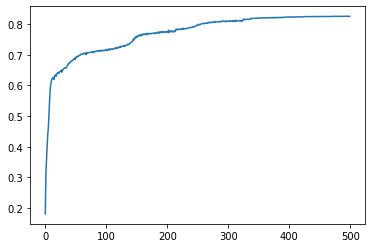

In [ ]:
import matplotlib.pyplot as plt
plt.plot(train_acc)

Unfortunately, we did not manage to overfit the dataset, even after training for over 4 hours on the premium GPU. The training accuracy reached 82.5% and stopped increasing, which means that even if we trained for longer, we would most likely not overfit the dataset. This is quite disappointing, because this means that HopGAT was not even able to match the performance of GATs reported in the paper. For this reason, we will not try higher depths.  We should still try to train a GAT on $depth = 4$ to verify the result in the paper. Since these experiments are very computationally expensive, we will train the GAT only for 100 epochs and compare the training accuracy with that of HopGAT after 100 epochs (71.7%). If the accuracy achieved by GAT is substantially higher/lower than 71.7%, we will be able to draw a conclusion. Obviously, this is not ideal and these experiments should be done thoroughly, but we don't have access to sufficient computing power. 

### Implementing a GAT for $depth = 4$

In [ ]:
e = Experiment(depth = 4, dim = 32,n_heads = 4, train_fraction = 0.8, max_epochs = 10000, batch_size = 1024, eval_every = 100,loader_workers = 7)

Starting experiment
Training examples: 12800, test examples: 3200


In [ ]:
e.model

GAT(
  (layer0_keys): Embedding(17, 32)
  (layer0_values): Embedding(17, 32)
  (layers): ModuleList(
    (0): GATConv(32, 8, heads=4)
    (1): GATConv(32, 8, heads=4)
    (2): GATConv(32, 8, heads=4)
    (3): GATConv(32, 8, heads=4)
    (4): GATConv(32, 8, heads=4)
  )
  (layer_norms): ModuleList(
    (0): LayerNorm((32,), eps=1e-05, elementwise_affine=True)
    (1): LayerNorm((32,), eps=1e-05, elementwise_affine=True)
    (2): LayerNorm((32,), eps=1e-05, elementwise_affine=True)
    (3): LayerNorm((32,), eps=1e-05, elementwise_affine=True)
    (4): LayerNorm((32,), eps=1e-05, elementwise_affine=True)
  )
  (out_layer): Linear(in_features=32, out_features=17, bias=False)
)

In [ ]:
train_acc,test_acc,loss,FourGATModel = e.run()

  0%|          | 0/100 [00:00<?, ?it/s]/usr/local/lib/python3.8/dist-packages/torch_geometric/deprecation.py:12: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Training Accuracy:0.070078125
Loss:2.7639288902282715


  1%|          | 1/100 [00:30<50:37, 30.68s/it]

Test Accuracy:0.06
Training Accuracy:0.12366328125
Loss:2.500309467315674


  2%|▏         | 2/100 [00:58<46:59, 28.77s/it]

Test Accuracy:0.1203125
Training Accuracy:0.17061640625
Loss:2.413712739944458


  3%|▎         | 3/100 [01:25<45:39, 28.24s/it]

Test Accuracy:0.1665625
Training Accuracy:0.2253046875
Loss:2.2210042476654053


  4%|▍         | 4/100 [01:53<44:37, 27.89s/it]

Test Accuracy:0.205
Training Accuracy:0.26523359375
Loss:2.16829776763916


  5%|▌         | 5/100 [02:20<43:47, 27.66s/it]

Test Accuracy:0.23875
Training Accuracy:0.3080125
Loss:2.016451597213745


  6%|▌         | 6/100 [02:47<43:11, 27.57s/it]

Test Accuracy:0.28125
Training Accuracy:0.3435453125
Loss:1.8912732601165771


  7%|▋         | 7/100 [03:15<42:46, 27.60s/it]

Test Accuracy:0.3140625
Training Accuracy:0.39661171875
Loss:1.726468563079834


  8%|▊         | 8/100 [03:42<42:14, 27.55s/it]

Test Accuracy:0.3715625
Training Accuracy:0.462434375
Loss:1.5132756233215332


  9%|▉         | 9/100 [04:10<41:36, 27.43s/it]

Test Accuracy:0.4240625
Training Accuracy:0.50285546875
Loss:1.5557409524917603


 10%|█         | 10/100 [04:37<41:05, 27.39s/it]

Test Accuracy:0.4571875
Training Accuracy:0.51781328125
Loss:1.414121389389038


 11%|█         | 11/100 [05:04<40:40, 27.42s/it]

Test Accuracy:0.4734375
Training Accuracy:0.5268078125
Loss:1.3960788249969482


 12%|█▏        | 12/100 [05:32<40:20, 27.51s/it]

Test Accuracy:0.4734375
Training Accuracy:0.5299484375
Loss:1.4166980981826782


 13%|█▎        | 13/100 [05:59<39:45, 27.42s/it]

Test Accuracy:0.4803125
Training Accuracy:0.53270546875
Loss:1.4246528148651123


 14%|█▍        | 14/100 [06:27<39:14, 27.38s/it]

Test Accuracy:0.4753125
Training Accuracy:0.53769765625
Loss:1.371509075164795


 15%|█▌        | 15/100 [06:54<38:46, 27.37s/it]

Test Accuracy:0.4709375
Training Accuracy:0.53812109375
Loss:1.4162156581878662


 16%|█▌        | 16/100 [07:21<38:13, 27.31s/it]

Test Accuracy:0.48
Training Accuracy:0.543015625
Loss:1.4011237621307373


 17%|█▋        | 17/100 [07:49<37:55, 27.42s/it]

Test Accuracy:0.485
Training Accuracy:0.54389765625
Loss:1.3923665285110474


 18%|█▊        | 18/100 [08:16<37:25, 27.39s/it]

Test Accuracy:0.4828125
Training Accuracy:0.54806640625
Loss:1.2934086322784424


 19%|█▉        | 19/100 [08:44<37:01, 27.42s/it]

Test Accuracy:0.4865625
Training Accuracy:0.55296796875
Loss:1.4053196907043457


 20%|██        | 20/100 [09:11<36:30, 27.39s/it]

Test Accuracy:0.493125
Training Accuracy:0.56445
Loss:1.2409403324127197


 21%|██        | 21/100 [09:39<36:11, 27.49s/it]

Test Accuracy:0.5078125
Training Accuracy:0.57481640625
Loss:1.2140531539916992


 22%|██▏       | 22/100 [10:06<35:37, 27.41s/it]

Test Accuracy:0.520625
Training Accuracy:0.58108984375
Loss:1.2479829788208008


 23%|██▎       | 23/100 [10:33<35:15, 27.47s/it]

Test Accuracy:0.5209375
Training Accuracy:0.58764609375
Loss:1.3469023704528809


 24%|██▍       | 24/100 [11:01<34:43, 27.42s/it]

Test Accuracy:0.5328125
Training Accuracy:0.59183359375
Loss:1.1842976808547974


 25%|██▌       | 25/100 [11:28<34:21, 27.49s/it]

Test Accuracy:0.5459375
Training Accuracy:0.59905859375
Loss:1.1448925733566284


 26%|██▌       | 26/100 [11:56<33:57, 27.54s/it]

Test Accuracy:0.5465625
Training Accuracy:0.60323125
Loss:1.172184705734253


 27%|██▋       | 27/100 [12:23<33:28, 27.52s/it]

Test Accuracy:0.5453125
Training Accuracy:0.6076328125
Loss:1.118500828742981


 28%|██▊       | 28/100 [12:51<33:04, 27.57s/it]

Test Accuracy:0.5540625
Training Accuracy:0.61220546875
Loss:1.1352324485778809


 29%|██▉       | 29/100 [13:19<32:34, 27.53s/it]

Test Accuracy:0.56125
Training Accuracy:0.61494296875
Loss:1.1258963346481323


 30%|███       | 30/100 [13:46<32:11, 27.59s/it]

Test Accuracy:0.558125
Training Accuracy:0.6172890625
Loss:1.1661593914031982


 31%|███       | 31/100 [14:14<31:41, 27.56s/it]

Test Accuracy:0.5678125
Training Accuracy:0.62256171875
Loss:1.141721487045288


 32%|███▏      | 32/100 [14:41<31:16, 27.59s/it]

Test Accuracy:0.564375
Training Accuracy:0.62324375
Loss:1.107393503189087


 33%|███▎      | 33/100 [15:09<30:51, 27.63s/it]

Test Accuracy:0.5675
Training Accuracy:0.62691328125
Loss:1.093376636505127


 34%|███▍      | 34/100 [15:37<30:23, 27.63s/it]

Test Accuracy:0.570625
Training Accuracy:0.62925390625
Loss:1.0461492538452148


 35%|███▌      | 35/100 [16:04<29:54, 27.60s/it]

Test Accuracy:0.57
Training Accuracy:0.6331921875
Loss:1.0328783988952637


 36%|███▌      | 36/100 [16:32<29:28, 27.63s/it]

Test Accuracy:0.5709375
Training Accuracy:0.6360203125
Loss:1.075906753540039


 37%|███▋      | 37/100 [16:59<28:54, 27.53s/it]

Test Accuracy:0.580625
Training Accuracy:0.636596875
Loss:1.0393942594528198


 38%|███▊      | 38/100 [17:27<28:29, 27.58s/it]

Test Accuracy:0.5821875
Training Accuracy:0.6404265625
Loss:0.9797175526618958


 39%|███▉      | 39/100 [17:55<28:01, 27.56s/it]

Test Accuracy:0.585625
Training Accuracy:0.64294140625
Loss:1.0636811256408691


 40%|████      | 40/100 [18:22<27:37, 27.63s/it]

Test Accuracy:0.58375
Training Accuracy:0.64455859375
Loss:1.0002955198287964


 41%|████      | 41/100 [18:50<27:05, 27.55s/it]

Test Accuracy:0.579375
Training Accuracy:0.64551328125
Loss:0.9979546666145325


 42%|████▏     | 42/100 [19:17<26:34, 27.48s/it]

Test Accuracy:0.588125
Training Accuracy:0.64691015625
Loss:1.0631093978881836


 43%|████▎     | 43/100 [19:45<26:09, 27.53s/it]

Test Accuracy:0.5778125
Training Accuracy:0.6495796875
Loss:1.0286632776260376


 44%|████▍     | 44/100 [20:13<25:49, 27.67s/it]

Test Accuracy:0.59375
Training Accuracy:0.66321484375
Loss:0.9520031213760376


 45%|████▌     | 45/100 [20:41<25:25, 27.73s/it]

Test Accuracy:0.6071875
Training Accuracy:0.6711984375
Loss:0.9640074968338013


 46%|████▌     | 46/100 [21:08<24:51, 27.62s/it]

Test Accuracy:0.6171875
Training Accuracy:0.679734375
Loss:0.9159924387931824


 47%|████▋     | 47/100 [21:36<24:26, 27.67s/it]

Test Accuracy:0.618125
Training Accuracy:0.68508203125
Loss:0.8506476283073425


 48%|████▊     | 48/100 [22:04<24:03, 27.76s/it]

Test Accuracy:0.615
Training Accuracy:0.68791484375
Loss:0.8770341873168945


 49%|████▉     | 49/100 [22:31<23:35, 27.75s/it]

Test Accuracy:0.6290625
Training Accuracy:0.6934796875
Loss:1.000299096107483


 50%|█████     | 50/100 [22:59<23:05, 27.71s/it]

Test Accuracy:0.6271875
Training Accuracy:0.69520234375
Loss:0.9231511354446411


 51%|█████     | 51/100 [23:27<22:38, 27.73s/it]

Test Accuracy:0.625625
Training Accuracy:0.6979171875
Loss:0.9041821956634521


 52%|█████▏    | 52/100 [23:54<22:05, 27.61s/it]

Test Accuracy:0.63
Training Accuracy:0.6977578125
Loss:0.9195408225059509


 53%|█████▎    | 53/100 [24:22<21:38, 27.62s/it]

Test Accuracy:0.631875
Training Accuracy:0.7015171875
Loss:0.9221778512001038


 54%|█████▍    | 54/100 [24:49<21:09, 27.59s/it]

Test Accuracy:0.6346875
Training Accuracy:0.7023859375
Loss:0.8681639432907104


 55%|█████▌    | 55/100 [25:17<20:45, 27.67s/it]

Test Accuracy:0.630625
Training Accuracy:0.70086953125
Loss:0.8281090259552002


 56%|█████▌    | 56/100 [25:45<20:15, 27.62s/it]

Test Accuracy:0.6378125
Training Accuracy:0.7040453125
Loss:0.9224706888198853


 57%|█████▋    | 57/100 [26:12<19:48, 27.63s/it]

Test Accuracy:0.6328125
Training Accuracy:0.7032375
Loss:0.8802251815795898


 58%|█████▊    | 58/100 [26:40<19:22, 27.67s/it]

Test Accuracy:0.630625
Training Accuracy:0.7054796875
Loss:0.8452771902084351


 59%|█████▉    | 59/100 [27:08<18:57, 27.75s/it]

Test Accuracy:0.63875
Training Accuracy:0.7049265625
Loss:0.8399112224578857


 60%|██████    | 60/100 [27:36<18:32, 27.82s/it]

Test Accuracy:0.6428125
Training Accuracy:0.7079734375
Loss:0.8555845618247986


 61%|██████    | 61/100 [28:03<17:59, 27.68s/it]

Test Accuracy:0.6365625
Training Accuracy:0.70674609375
Loss:0.8702402114868164


 62%|██████▏   | 62/100 [28:31<17:28, 27.60s/it]

Test Accuracy:0.625
Training Accuracy:0.70767578125
Loss:0.7956888675689697


 63%|██████▎   | 63/100 [28:58<16:58, 27.52s/it]

Test Accuracy:0.643125
Training Accuracy:0.71017890625
Loss:0.8376885652542114


 64%|██████▍   | 64/100 [29:25<16:28, 27.47s/it]

Test Accuracy:0.641875
Training Accuracy:0.70897578125
Loss:0.8084524273872375


 65%|██████▌   | 65/100 [29:53<16:00, 27.45s/it]

Test Accuracy:0.6396875
Training Accuracy:0.710190625
Loss:0.8144720792770386


 66%|██████▌   | 66/100 [30:21<15:37, 27.57s/it]

Test Accuracy:0.645
Training Accuracy:0.7084671875
Loss:0.8919827938079834


 67%|██████▋   | 67/100 [30:48<15:08, 27.54s/it]

Test Accuracy:0.6309375
Training Accuracy:0.711240625
Loss:0.8611124753952026


 68%|██████▊   | 68/100 [31:16<14:40, 27.50s/it]

Test Accuracy:0.646875
Training Accuracy:0.71240625
Loss:0.8912211060523987


 69%|██████▉   | 69/100 [31:43<14:10, 27.43s/it]

Test Accuracy:0.6471875
Training Accuracy:0.71367890625
Loss:0.8383476138114929


 70%|███████   | 70/100 [32:10<13:43, 27.45s/it]

Test Accuracy:0.64875
Training Accuracy:0.71202890625
Loss:0.896801233291626


 71%|███████   | 71/100 [32:38<13:15, 27.43s/it]

Test Accuracy:0.64875
Training Accuracy:0.7133796875
Loss:0.8180475831031799


 72%|███████▏  | 72/100 [33:05<12:48, 27.45s/it]

Test Accuracy:0.6465625
Training Accuracy:0.7149890625
Loss:0.856645405292511


 73%|███████▎  | 73/100 [33:33<12:19, 27.40s/it]

Test Accuracy:0.6484375
Training Accuracy:0.713321875
Loss:0.8042376637458801


 74%|███████▍  | 74/100 [34:01<11:57, 27.60s/it]

Test Accuracy:0.650625
Training Accuracy:0.716521875
Loss:0.874293863773346


 75%|███████▌  | 75/100 [34:28<11:27, 27.51s/it]

Test Accuracy:0.646875
Training Accuracy:0.71562890625
Loss:0.87973552942276


 76%|███████▌  | 76/100 [34:56<11:02, 27.60s/it]

Test Accuracy:0.6496875
Training Accuracy:0.71611953125
Loss:0.8001338243484497


 77%|███████▋  | 77/100 [35:23<10:33, 27.54s/it]

Test Accuracy:0.650625
Training Accuracy:0.716503125
Loss:0.885817289352417


 78%|███████▊  | 78/100 [35:51<10:07, 27.61s/it]

Test Accuracy:0.650625
Training Accuracy:0.71708359375
Loss:0.8148669004440308


 79%|███████▉  | 79/100 [36:18<09:39, 27.61s/it]

Test Accuracy:0.6471875
Training Accuracy:0.71773828125
Loss:0.8218814134597778


 80%|████████  | 80/100 [36:46<09:10, 27.54s/it]

Test Accuracy:0.655625
Training Accuracy:0.71639921875
Loss:0.8169317841529846


 81%|████████  | 81/100 [37:13<08:41, 27.46s/it]

Test Accuracy:0.6575
Training Accuracy:0.71996796875
Loss:0.8993884325027466


 82%|████████▏ | 82/100 [37:40<08:13, 27.42s/it]

Test Accuracy:0.650625
Training Accuracy:0.718825
Loss:0.8109745383262634


 83%|████████▎ | 83/100 [38:08<07:46, 27.42s/it]

Test Accuracy:0.65125
Training Accuracy:0.718196875
Loss:0.8249468207359314


 84%|████████▍ | 84/100 [38:36<07:20, 27.50s/it]

Test Accuracy:0.648125
Training Accuracy:0.72127734375
Loss:0.8527429699897766


 85%|████████▌ | 85/100 [39:03<06:54, 27.63s/it]

Test Accuracy:0.65
Training Accuracy:0.71910859375
Loss:0.8660142421722412


 86%|████████▌ | 86/100 [39:31<06:26, 27.63s/it]

Test Accuracy:0.6578125
Training Accuracy:0.721065625
Loss:0.8221685290336609


 87%|████████▋ | 87/100 [39:59<05:58, 27.61s/it]

Test Accuracy:0.6521875
Training Accuracy:0.72039921875
Loss:0.9214335680007935


 88%|████████▊ | 88/100 [40:26<05:30, 27.54s/it]

Test Accuracy:0.6484375
Training Accuracy:0.721034375
Loss:0.7673380970954895


 89%|████████▉ | 89/100 [40:54<05:03, 27.62s/it]

Test Accuracy:0.651875
Training Accuracy:0.7216703125
Loss:0.7680387496948242


 90%|█████████ | 90/100 [41:21<04:35, 27.55s/it]

Test Accuracy:0.6446875
Training Accuracy:0.72245859375
Loss:0.8104004859924316


 91%|█████████ | 91/100 [41:49<04:08, 27.64s/it]

Test Accuracy:0.649375
Training Accuracy:0.7236046875
Loss:0.7454925775527954


 92%|█████████▏| 92/100 [42:17<03:41, 27.69s/it]

Test Accuracy:0.6496875
Training Accuracy:0.72399296875
Loss:0.7880260944366455


 93%|█████████▎| 93/100 [42:46<03:16, 28.13s/it]

Test Accuracy:0.6503125
Training Accuracy:0.72356328125
Loss:0.8109486103057861


 94%|█████████▍| 94/100 [43:15<02:49, 28.26s/it]

Test Accuracy:0.6509375
Training Accuracy:0.72577890625
Loss:0.785355806350708


 95%|█████████▌| 95/100 [43:43<02:21, 28.36s/it]

Test Accuracy:0.654375
Training Accuracy:0.72460703125
Loss:0.8074881434440613


 96%|█████████▌| 96/100 [44:12<01:53, 28.39s/it]

Test Accuracy:0.6484375
Training Accuracy:0.72576875
Loss:0.7876691818237305


 97%|█████████▋| 97/100 [44:40<01:25, 28.43s/it]

Test Accuracy:0.6528125
Training Accuracy:0.72828203125
Loss:0.8272513151168823


 98%|█████████▊| 98/100 [45:09<00:56, 28.50s/it]

Test Accuracy:0.653125
Training Accuracy:0.7280921875
Loss:0.8340852856636047


 99%|█████████▉| 99/100 [45:37<00:28, 28.35s/it]

Test Accuracy:0.6503125
Training Accuracy:0.7278734375
Loss:0.8265258073806763


100%|██████████| 100/100 [46:05<00:00, 27.66s/it]

Test Accuracy:0.64875


ValueError: ignored

The GAT has managed to achieve a slightly higher training accuracy (72.8%) than HopGAT (71.7%) after 100 epochs of training. This means that we definitely CANNOT conclude that HopGAT is more resistant to oversquashing. If anything, this experiment suggests the opposite. 


In my opinion, this is a surprising result, because HopGAT was designed to allow for better information flow, with the hope that it will alleviate oversquashing. This experiment tells us that the connection is not immediate. Even though direct communication between leaves and the root is enabled, this doesn't imply that oversquashing is alleviated. For some reason, the model is struggling to understand that the only relevant information is coming from the last layer. 

There are two ways we can fix this. The first is to treat the neighborhoods over which we aggregate as hyperparameters and choose a better configuration. The second is to increase the output dimension of the last layer while decreasing the other dimensions, in order to keep the number of parameters the same. This ensures information from the leaves layer is not squashed and the last GAT layer has a bigger expressive power. This way, we can achieve drastically better performance while using the same number of parameters. 

Both ideas are implemented in the appendix and please check them out.  

# Summary and Outlook

In this notebook, we introduced graph attention networks (GATs) and designed a new model inspired by GATs and shortest path message passing neural networks (SPMPNNs), which we called HopGAT. The motivation behind our model was that we wanted to experiment with aggregation over $k$-hop neighborhoods. We hoped that this would improve the performance of GATs and alleviate some of their limitations, especially oversquashing.

To test our model, we examined its performance on the Cora dataset, where we matched the performance of GATs. Then, we experimentally proved that GATs suffer from oversmoothing and observed that our model does not. To explain that, we concluded that our model is similar to Jumping Knowledge Connections, which are known to tackle oversmoothing. To deepen our understanding of HopGAT, we decided to shift our focus to oversquashing.

To do that, we decided to conduct experiments on TreeNeighborsMatch, a synthetic task designed to highlight oversquashing. As a first step, we reimplemented results from [Alon and Yahav](https://arxiv.org/pdf/2006.05205.pdf) for standard graph attention networks and $depths = 2,3$. Then we implemented our model on this dataset and observed that it matches the performance of GATs for $depth = 2,3$. 


Next, we observed that HopGAT did not even overfit the dataset for $depth = 4$. This was surprising - I expected that HopGAT would easily match the performance of GATs on TreeNeighborsMatch, but we found that this is not the case. To make things worse, HopGAT was using more parameters than the standard GAT. This allows us to conclude that HopGAT aggregating over all layers is simply inferior to a standard GAT, since it does not even tackle oversquashing and uses more parameters. 

However, by incorporating strong inductive bias into our model, we can fix this problem. In the appendix we showed that when HopGAT aggregates only over the $depth$-hop neighborhood, it easily outperforms all models reported in the paper even for $depth = 5$, while using a similar amount of parameters. This supports our initial hypothesis that direct communication between nodes alleviates oversquashing. Alternatively, one can still aggregate over all hops, but can increase the dimensions of the final GATConv layer (and decrease the dimension of the other layers) to drastically improve performance while keeping the number of parameters the same. We must bear in mind that we are cheating a little bit -  we know exactly over which neighborhoods we should aggregate. In practice, this is not known and should be treated as a hyperparameter.  

Further experiments must be conducted to explore the class of models described in the first section. In particular, it would be interesting to experiment with different architectures, bigger depths of TreeNeighborsMatch and also other datasets. Unfortunately, due to insufficient computational resources, this was impossible to do. Additionally, it would be interesting to see if aggregating with attention for each neighborhood actually increases performance on datasets where oversquashing/oversmoothing is not an issue (on tasks which can be solved with a small number of layers). We did not observe an increase in performance on Cora/Citeseer. Perhaps one could construct datasets where such an aggregation scheme is crucial. Another direction would be to further modify the aggregation scheme we proposed in order to improve performance. 



# Self-evaluation

The question states that self-evaluation is part of the marking criteria, so I thought I would include that. In general, I am neither happy nor unhappy with what I did in this question. I think the idea that I explored was not bad, because it connected ideas from two papers, it was closely related to what we did in the lectures and it was a little creative. However, the experiments did not work as well as I expected. I considered completely changing my idea several times but decided against doing so because I had already invested a lot of time into this (which I don't think is adequately reflected in this notebook). Also, I think there are interesting results in this work. We found that HopGAT is resistant to oversmoothing and possibly to oversquashing, provided we choose the right hyperparameters (such as the neighborhoods over which we aggregate). I was simply hoping that the difference would be bigger, especially in TreeNeighborsMatch, but that was not the case. 

# Appendix 

## HopGAT with one attention layer

Here we implement the version of HopGAT which aggregates only over the depth layer. 

In [ ]:
from torch import nn
from torch.nn import functional as F
from torch_geometric.nn import GATConv

class HopGAT(torch.nn.Module):
    def __init__(self, depth, dim0, h_dim, out_dim, n_heads, layer_norm = True):
        super(HopGAT, self).__init__()
  
        self.device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

        self.layer0_keys = nn.Embedding(num_embeddings=dim0 + 1, embedding_dim=h_dim)
        self.layer0_values = nn.Embedding(num_embeddings=dim0 + 1, embedding_dim=h_dim)
        self.depth = depth
        self.out_dim = out_dim
       
        self.gat = GATConv(h_dim,h_dim//n_heads,heads = n_heads)
        self.mlp = nn.Linear(2*h_dim,h_dim)
        self.layer_norm = layer_norm
        if layer_norm:
          self.layer_norms = nn.LayerNorm(h_dim)
        self.out_layer = nn.Linear(in_features=h_dim, out_features=out_dim + 1, bias=False)

    def forward(self, data):
        x, edge_index1, batch, roots,edge_index2 = data.x, data.edge_index1, data.batch, data.root_mask,data.edge_index2

      
        x_key, x_val = x[:, 0], x[:, 1]
        x_key_embed = self.layer0_keys(x_key)
        x_val_embed = self.layer0_values(x_val)
        x = x_key_embed + x_val_embed
        
        if self.depth == 2:
          x = torch.cat((x,self.gat(x,edge_index2)),dim = 1)
        elif self.depth == 3:
          x = torch.cat((x,self.gat(x,data.edge_index3)),dim = 1)
        elif self.depth == 4:
          x = torch.cat((x,self.gat(x,data.edge_index4)),dim = 1)
        elif self.depth == 5:
          x = torch.cat((x,self.gat(x,data.edge_index5)),dim = 1)
        
        x = self.mlp(x)
        if self.layer_norm:
          x = self.layer_norms(x)
            

        root_nodes = x[roots]
        logits = self.out_layer(root_nodes)
        return logits

In [ ]:
e = HopExperiment(depth = 3,dim = 32,n_heads = 4, train_fraction = 0.8, max_epochs = 1200, batch_size = 64, eval_every = 10,loader_workers = 2)

Starting experiment
Training examples: 6400, test examples: 1600


In [ ]:
e.model

HopGAT(
  (layer0_keys): Embedding(9, 32)
  (layer0_values): Embedding(9, 32)
  (gat): GATConv(32, 8, heads=4)
  (mlp): Linear(in_features=64, out_features=32, bias=True)
  (layer_norms): LayerNorm((32,), eps=1e-05, elementwise_affine=True)
  (out_layer): Linear(in_features=32, out_features=9, bias=False)
)

In [ ]:
train_acc,test_acc,loss,ThreeHopModel = e.run()

  0%|          | 0/120 [00:00<?, ?it/s]/usr/local/lib/python3.8/dist-packages/torch_geometric/deprecation.py:12: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Training Accuracy:0.30103125
Loss:1.1682132482528687


  1%|          | 1/120 [00:11<22:33, 11.37s/it]

Test Accuracy:0.454375
Training Accuracy:0.598765625
Loss:0.7452203035354614


  2%|▏         | 2/120 [00:22<22:14, 11.31s/it]

Test Accuracy:0.653125
Training Accuracy:0.76421875
Loss:0.43015193939208984


  2%|▎         | 3/120 [00:33<21:51, 11.21s/it]

Test Accuracy:0.78875
Training Accuracy:0.835875
Loss:0.24402378499507904


  3%|▎         | 4/120 [00:44<21:40, 11.21s/it]

Test Accuracy:0.84125
Training Accuracy:0.896390625
Loss:0.18353931605815887


  4%|▍         | 5/120 [00:56<21:35, 11.27s/it]

Test Accuracy:0.87
Training Accuracy:0.979671875
Loss:0.005567936226725578


  5%|▌         | 6/120 [01:07<21:34, 11.35s/it]

Test Accuracy:1.0
Training Accuracy:1.0
Loss:0.0024306336417794228


  5%|▌         | 6/120 [01:19<25:06, 13.21s/it]

Test Accuracy:1.0


Easy! Let's try bigger depths. 

In [ ]:
e = HopExperiment(depth = 4,dim = 32,n_heads = 4, train_fraction = 0.8, max_epochs = 50000, batch_size = 1024, eval_every = 100,loader_workers = 7)

Starting experiment
Training examples: 12800, test examples: 3200


In [ ]:
e.model

HopGAT(
  (layer0_keys): Embedding(17, 32)
  (layer0_values): Embedding(17, 32)
  (gat): GATConv(32, 8, heads=4)
  (mlp): Linear(in_features=64, out_features=32, bias=True)
  (layer_norms): LayerNorm((32,), eps=1e-05, elementwise_affine=True)
  (out_layer): Linear(in_features=32, out_features=17, bias=False)
)

In [ ]:
train_acc,test_acc,loss,FourHopModel = e.run()

  0%|          | 0/500 [00:00<?, ?it/s]/usr/local/lib/python3.8/dist-packages/torch_geometric/deprecation.py:12: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Training Accuracy:0.1771859375
Loss:2.1592729091644287


  0%|          | 1/500 [00:27<3:49:27, 27.59s/it]

Test Accuracy:0.2171875
Training Accuracy:0.29089921875
Loss:1.9458181858062744


  0%|          | 2/500 [00:54<3:45:03, 27.12s/it]

Test Accuracy:0.3
Training Accuracy:0.4038234375
Loss:1.5390088558197021


  1%|          | 3/500 [01:21<3:44:46, 27.14s/it]

Test Accuracy:0.4146875
Training Accuracy:0.4973671875
Loss:1.3112024068832397


  1%|          | 4/500 [01:49<3:45:40, 27.30s/it]

Test Accuracy:0.4825
Training Accuracy:0.54671640625
Loss:1.2337186336517334


  1%|          | 5/500 [02:16<3:45:24, 27.32s/it]

Test Accuracy:0.5303125
Training Accuracy:0.57504375
Loss:1.204176664352417


  1%|          | 6/500 [02:43<3:44:50, 27.31s/it]

Test Accuracy:0.555625
Training Accuracy:0.5903890625
Loss:1.1986359357833862


  1%|▏         | 7/500 [03:11<3:44:18, 27.30s/it]

Test Accuracy:0.5546875
Training Accuracy:0.5981875
Loss:1.1128283739089966


  2%|▏         | 8/500 [03:38<3:43:38, 27.27s/it]

Test Accuracy:0.56625
Training Accuracy:0.603903125
Loss:1.0622676610946655


  2%|▏         | 9/500 [04:05<3:43:43, 27.34s/it]

Test Accuracy:0.5684375
Training Accuracy:0.6071203125
Loss:1.0462455749511719


  2%|▏         | 10/500 [04:33<3:43:17, 27.34s/it]

Test Accuracy:0.5790625
Training Accuracy:0.6148046875
Loss:1.0869553089141846


  2%|▏         | 11/500 [05:00<3:42:34, 27.31s/it]

Test Accuracy:0.5890625
Training Accuracy:0.62650234375
Loss:0.981914758682251


  2%|▏         | 12/500 [05:27<3:41:52, 27.28s/it]

Test Accuracy:0.600625
Training Accuracy:0.63353515625
Loss:0.9741618633270264


  3%|▎         | 13/500 [05:55<3:42:07, 27.37s/it]

Test Accuracy:0.6146875
Training Accuracy:0.6512734375
Loss:0.897200882434845


  3%|▎         | 14/500 [06:22<3:42:24, 27.46s/it]

Test Accuracy:0.619375
Training Accuracy:0.66683984375
Loss:0.8703389167785645


  3%|▎         | 15/500 [06:50<3:41:51, 27.45s/it]

Test Accuracy:0.648125
Training Accuracy:0.70351640625
Loss:0.7656790614128113


  3%|▎         | 16/500 [07:17<3:41:28, 27.46s/it]

Test Accuracy:0.68125
Training Accuracy:0.7513546875
Loss:0.5774926543235779


  3%|▎         | 17/500 [07:45<3:41:16, 27.49s/it]

Test Accuracy:0.723125
Training Accuracy:0.78257421875
Loss:0.5238744616508484


  4%|▎         | 18/500 [08:13<3:42:14, 27.66s/it]

Test Accuracy:0.7571875
Training Accuracy:0.8012890625
Loss:0.4849911034107208


  4%|▍         | 19/500 [08:42<3:45:42, 28.15s/it]

Test Accuracy:0.7753125
Training Accuracy:0.8100875
Loss:0.5389187932014465


  4%|▍         | 20/500 [09:11<3:46:47, 28.35s/it]

Test Accuracy:0.7646875
Training Accuracy:0.817075
Loss:0.5050325393676758


  4%|▍         | 21/500 [09:39<3:45:46, 28.28s/it]

Test Accuracy:0.7746875
Training Accuracy:0.82213828125
Loss:0.4100628197193146


  4%|▍         | 22/500 [10:07<3:44:42, 28.21s/it]

Test Accuracy:0.794375
Training Accuracy:0.82654296875
Loss:0.5004947185516357


  5%|▍         | 23/500 [10:35<3:44:47, 28.28s/it]

Test Accuracy:0.799375
Training Accuracy:0.8308359375
Loss:0.47583886981010437


  5%|▍         | 24/500 [11:03<3:43:27, 28.17s/it]

Test Accuracy:0.7903125
Training Accuracy:0.8322859375
Loss:0.40868476033210754


  5%|▌         | 25/500 [11:32<3:43:21, 28.21s/it]

Test Accuracy:0.801875
Training Accuracy:0.8355578125
Loss:0.3903540372848511


  5%|▌         | 26/500 [12:00<3:43:16, 28.26s/it]

Test Accuracy:0.804375
Training Accuracy:0.83691484375
Loss:0.4167853891849518


  5%|▌         | 27/500 [12:29<3:43:17, 28.32s/it]

Test Accuracy:0.7940625
Training Accuracy:0.84025859375
Loss:0.4889824092388153


  6%|▌         | 28/500 [12:57<3:42:28, 28.28s/it]

Test Accuracy:0.8075
Training Accuracy:0.8412828125
Loss:0.4255432188510895


  6%|▌         | 29/500 [13:25<3:41:43, 28.25s/it]

Test Accuracy:0.8075
Training Accuracy:0.843428125
Loss:0.4158554971218109


  6%|▌         | 30/500 [13:53<3:40:32, 28.15s/it]

Test Accuracy:0.7915625
Training Accuracy:0.8461546875
Loss:0.425487220287323


  6%|▌         | 31/500 [14:21<3:40:28, 28.21s/it]

Test Accuracy:0.801875
Training Accuracy:0.84756015625
Loss:0.39732134342193604


  6%|▋         | 32/500 [14:49<3:39:34, 28.15s/it]

Test Accuracy:0.803125
Training Accuracy:0.847603125
Loss:0.374329149723053


  7%|▋         | 33/500 [15:17<3:39:19, 28.18s/it]

Test Accuracy:0.8065625
Training Accuracy:0.85068828125
Loss:0.4343472123146057


  7%|▋         | 34/500 [15:46<3:39:06, 28.21s/it]

Test Accuracy:0.80625
Training Accuracy:0.85187265625
Loss:0.33705130219459534


  7%|▋         | 35/500 [16:14<3:39:23, 28.31s/it]

Test Accuracy:0.81
Training Accuracy:0.851971875
Loss:0.3846283257007599


  7%|▋         | 36/500 [16:43<3:39:44, 28.41s/it]

Test Accuracy:0.8128125
Training Accuracy:0.85366640625
Loss:0.40513867139816284


  7%|▋         | 37/500 [17:11<3:38:30, 28.32s/it]

Test Accuracy:0.8115625
Training Accuracy:0.854484375
Loss:0.4190959334373474


  8%|▊         | 38/500 [17:39<3:36:57, 28.18s/it]

Test Accuracy:0.820625
Training Accuracy:0.8552703125
Loss:0.3927638828754425


  8%|▊         | 39/500 [18:07<3:36:03, 28.12s/it]

Test Accuracy:0.8209375
Training Accuracy:0.85596953125
Loss:0.39891868829727173


  8%|▊         | 40/500 [18:35<3:35:01, 28.05s/it]

Test Accuracy:0.82625
Training Accuracy:0.85703046875
Loss:0.3768899142742157


  8%|▊         | 41/500 [19:03<3:34:33, 28.05s/it]

Test Accuracy:0.7959375
Training Accuracy:0.85889375
Loss:0.3434680998325348


  8%|▊         | 42/500 [19:31<3:34:28, 28.10s/it]

Test Accuracy:0.8246875
Training Accuracy:0.858940625
Loss:0.3743100166320801


  9%|▊         | 43/500 [19:59<3:34:56, 28.22s/it]

Test Accuracy:0.805
Training Accuracy:0.85948515625
Loss:0.35816797614097595


  9%|▉         | 44/500 [20:28<3:35:10, 28.31s/it]

Test Accuracy:0.810625
Training Accuracy:0.86090859375
Loss:0.3805479407310486


  9%|▉         | 45/500 [20:56<3:34:54, 28.34s/it]

Test Accuracy:0.8259375
Training Accuracy:0.85986328125
Loss:0.33253538608551025


  9%|▉         | 46/500 [21:24<3:33:17, 28.19s/it]

Test Accuracy:0.805625
Training Accuracy:0.8624203125
Loss:0.3684585988521576


  9%|▉         | 47/500 [21:52<3:32:39, 28.17s/it]

Test Accuracy:0.808125
Training Accuracy:0.8625671875
Loss:0.29765135049819946


 10%|▉         | 48/500 [22:20<3:31:37, 28.09s/it]

Test Accuracy:0.8159375
Training Accuracy:0.86358046875
Loss:0.4011606276035309


 10%|▉         | 49/500 [22:48<3:30:11, 27.96s/it]

Test Accuracy:0.82375
Training Accuracy:0.86393203125
Loss:0.4351026117801666


 10%|█         | 50/500 [23:16<3:29:43, 27.96s/it]

Test Accuracy:0.835625
Training Accuracy:0.8654875
Loss:0.3632935583591461


 10%|█         | 51/500 [23:44<3:29:34, 28.00s/it]

Test Accuracy:0.829375
Training Accuracy:0.864796875
Loss:0.3403397798538208


 10%|█         | 52/500 [24:12<3:28:46, 27.96s/it]

Test Accuracy:0.83125
Training Accuracy:0.86574609375
Loss:0.35159480571746826


 11%|█         | 53/500 [24:41<3:30:15, 28.22s/it]

Test Accuracy:0.8046875
Training Accuracy:0.86562734375
Loss:0.33311545848846436


 11%|█         | 54/500 [25:09<3:28:54, 28.10s/it]

Test Accuracy:0.8271875
Training Accuracy:0.86718125
Loss:0.3451385498046875


 11%|█         | 55/500 [25:37<3:28:26, 28.11s/it]

Test Accuracy:0.8253125
Training Accuracy:0.8664328125
Loss:0.3315121829509735


 11%|█         | 56/500 [26:04<3:27:12, 28.00s/it]

Test Accuracy:0.8228125
Training Accuracy:0.86702421875
Loss:0.3477943539619446


 11%|█▏        | 57/500 [26:33<3:27:18, 28.08s/it]

Test Accuracy:0.840625
Training Accuracy:0.86863828125
Loss:0.2973903715610504


 12%|█▏        | 58/500 [27:00<3:26:08, 27.98s/it]

Test Accuracy:0.809375
Training Accuracy:0.868565625
Loss:0.3244832456111908


 12%|█▏        | 59/500 [27:28<3:24:48, 27.86s/it]

Test Accuracy:0.8359375
Training Accuracy:0.8698625
Loss:0.30341190099716187


 12%|█▏        | 60/500 [27:56<3:23:51, 27.80s/it]

Test Accuracy:0.8084375
Training Accuracy:0.86850859375
Loss:0.32712069153785706


 12%|█▏        | 61/500 [28:23<3:22:44, 27.71s/it]

Test Accuracy:0.815625
Training Accuracy:0.86958984375
Loss:0.3351703882217407


 12%|█▏        | 62/500 [28:51<3:22:35, 27.75s/it]

Test Accuracy:0.8325
Training Accuracy:0.86952109375
Loss:0.39975130558013916


 13%|█▎        | 63/500 [29:18<3:21:12, 27.63s/it]

Test Accuracy:0.8184375
Training Accuracy:0.86925859375
Loss:0.32338857650756836


 13%|█▎        | 64/500 [29:45<3:19:16, 27.42s/it]

Test Accuracy:0.83125
Training Accuracy:0.87025234375
Loss:0.3380317986011505


 13%|█▎        | 65/500 [30:13<3:19:02, 27.45s/it]

Test Accuracy:0.8171875
Training Accuracy:0.8698578125
Loss:0.32155027985572815


 13%|█▎        | 66/500 [30:41<3:19:06, 27.53s/it]

Test Accuracy:0.825625
Training Accuracy:0.871984375
Loss:0.33263564109802246


 13%|█▎        | 67/500 [31:08<3:18:35, 27.52s/it]

Test Accuracy:0.836875
Training Accuracy:0.87099375
Loss:0.3437001705169678


 14%|█▎        | 68/500 [31:36<3:18:06, 27.52s/it]

Test Accuracy:0.8225
Training Accuracy:0.8707296875
Loss:0.28282690048217773


 14%|█▍        | 69/500 [32:03<3:16:46, 27.39s/it]

Test Accuracy:0.8290625
Training Accuracy:0.8733578125
Loss:0.25627264380455017


 14%|█▍        | 70/500 [32:30<3:15:35, 27.29s/it]

Test Accuracy:0.83
Training Accuracy:0.8725125
Loss:0.29705917835235596


 14%|█▍        | 71/500 [32:57<3:16:08, 27.43s/it]

Test Accuracy:0.8271875
Training Accuracy:0.87252578125
Loss:0.3871229887008667


 14%|█▍        | 72/500 [33:27<3:19:18, 27.94s/it]

Test Accuracy:0.831875
Training Accuracy:0.87401015625
Loss:0.3449316620826721


 15%|█▍        | 73/500 [33:55<3:19:04, 27.97s/it]

Test Accuracy:0.8296875
Training Accuracy:0.87429375
Loss:0.34101131558418274


 15%|█▍        | 74/500 [34:23<3:18:39, 27.98s/it]

Test Accuracy:0.82625
Training Accuracy:0.87402890625
Loss:0.3403691053390503


 15%|█▌        | 75/500 [34:51<3:18:55, 28.08s/it]

Test Accuracy:0.816875
Training Accuracy:0.87382578125
Loss:0.31021690368652344


 15%|█▌        | 76/500 [35:20<3:20:06, 28.32s/it]

Test Accuracy:0.823125
Training Accuracy:0.87455859375
Loss:0.3560726046562195


 15%|█▌        | 77/500 [35:49<3:21:00, 28.51s/it]

Test Accuracy:0.826875
Training Accuracy:0.8736078125
Loss:0.30956530570983887


 16%|█▌        | 78/500 [36:16<3:18:44, 28.26s/it]

Test Accuracy:0.8415625
Training Accuracy:0.87396484375
Loss:0.2680249512195587


 16%|█▌        | 79/500 [36:45<3:18:27, 28.28s/it]

Test Accuracy:0.829375
Training Accuracy:0.874746875
Loss:0.29908743500709534


 16%|█▌        | 80/500 [37:13<3:18:04, 28.30s/it]

Test Accuracy:0.8315625
Training Accuracy:0.8763359375
Loss:0.35970842838287354


 16%|█▌        | 81/500 [37:41<3:16:38, 28.16s/it]

Test Accuracy:0.82125
Training Accuracy:0.875415625
Loss:0.26452934741973877


 16%|█▋        | 82/500 [38:09<3:15:54, 28.12s/it]

Test Accuracy:0.8434375
Training Accuracy:0.8770234375
Loss:0.28386521339416504


 17%|█▋        | 83/500 [38:37<3:14:43, 28.02s/it]

Test Accuracy:0.835
Training Accuracy:0.87796953125
Loss:0.32128244638442993


 17%|█▋        | 84/500 [39:04<3:12:54, 27.82s/it]

Test Accuracy:0.823125
Training Accuracy:0.87454375
Loss:0.378894180059433


 17%|█▋        | 85/500 [39:32<3:13:06, 27.92s/it]

Test Accuracy:0.8365625
Training Accuracy:0.87798515625
Loss:0.298843652009964


 17%|█▋        | 86/500 [39:59<3:11:00, 27.68s/it]

Test Accuracy:0.8415625
Training Accuracy:0.87669921875
Loss:0.31374937295913696


 17%|█▋        | 87/500 [40:27<3:10:24, 27.66s/it]

Test Accuracy:0.8228125
Training Accuracy:0.8780625
Loss:0.3299410045146942


 18%|█▊        | 88/500 [40:54<3:08:50, 27.50s/it]

Test Accuracy:0.8225
Training Accuracy:0.87733828125
Loss:0.31865164637565613


 18%|█▊        | 89/500 [41:22<3:09:42, 27.69s/it]

Test Accuracy:0.838125
Training Accuracy:0.87827265625
Loss:0.3380531370639801


 18%|█▊        | 90/500 [41:50<3:09:02, 27.66s/it]

Test Accuracy:0.833125
Training Accuracy:0.878390625
Loss:0.3659883737564087


 18%|█▊        | 91/500 [42:17<3:08:25, 27.64s/it]

Test Accuracy:0.82375
Training Accuracy:0.878390625
Loss:0.3123917877674103


 18%|█▊        | 92/500 [42:45<3:07:19, 27.55s/it]

Test Accuracy:0.8234375
Training Accuracy:0.878021875
Loss:0.3277294337749481


 19%|█▊        | 93/500 [43:12<3:06:06, 27.44s/it]

Test Accuracy:0.8378125
Training Accuracy:0.87774921875
Loss:0.2920461893081665


 19%|█▉        | 94/500 [43:39<3:05:36, 27.43s/it]

Test Accuracy:0.839375
Training Accuracy:0.879609375
Loss:0.2554289400577545


 19%|█▉        | 95/500 [44:08<3:07:14, 27.74s/it]

Test Accuracy:0.834375
Training Accuracy:0.8787109375
Loss:0.28698939085006714


 19%|█▉        | 96/500 [44:36<3:06:49, 27.75s/it]

Test Accuracy:0.836875
Training Accuracy:0.8806453125
Loss:0.3429131507873535


 19%|█▉        | 97/500 [45:03<3:05:29, 27.62s/it]

Test Accuracy:0.825
Training Accuracy:0.8796046875
Loss:0.29067298769950867


 20%|█▉        | 98/500 [45:31<3:06:54, 27.90s/it]

Test Accuracy:0.8440625
Training Accuracy:0.8784359375
Loss:0.2932887077331543


 20%|█▉        | 99/500 [46:00<3:08:05, 28.14s/it]

Test Accuracy:0.8353125
Training Accuracy:0.8798921875
Loss:0.288528174161911


 20%|██        | 100/500 [46:28<3:06:39, 28.00s/it]

Test Accuracy:0.82125


 20%|██        | 100/500 [46:31<3:06:07, 27.92s/it]


KeyboardInterrupt: ignored

The training accuracy after 100 epochs was around 88% which is much better than both GAT (72.8%) or HopGAT (71.7%), even though this model uses only 1 attention layer. Thus, we can conclude that it is likely that this model would perform better, but we do not train for longer because of insufficient computational resources. 

What about $depth = 5$? Can we get close to 41% training accuracy in 50 epochs?

In [ ]:
e = HopExperiment(depth = 5,dim = 32,n_heads = 4, train_fraction = 0.8, max_epochs = 5000, batch_size = 1024, eval_every = 100,loader_workers = 7)

Traceback (most recent call last):
  File "/usr/lib/python3.8/multiprocessing/queues.py", line 245, in _feed
    send_bytes(obj)
  File "/usr/lib/python3.8/multiprocessing/connection.py", line 200, in send_bytes
    self._send_bytes(m[offset:offset + size])
  File "/usr/lib/python3.8/multiprocessing/connection.py", line 411, in _send_bytes
    self._send(header + buf)
  File "/usr/lib/python3.8/multiprocessing/connection.py", line 368, in _send
    n = write(self._handle, buf)
BrokenPipeError: [Errno 32] Broken pipe
Traceback (most recent call last):
  File "/usr/lib/python3.8/multiprocessing/queues.py", line 235, in _feed
    close()
  File "/usr/lib/python3.8/multiprocessing/connection.py", line 177, in close
    self._close()
  File "/usr/lib/python3.8/multiprocessing/connection.py", line 361, in _close
    _close(self._handle)
OSError: [Errno 9] Bad file descriptor


Starting experiment
Training examples: 25600, test examples: 6400


In [ ]:
e.model

HopGAT(
  (layer0_keys): Embedding(33, 32)
  (layer0_values): Embedding(33, 32)
  (gat): GATConv(32, 8, heads=4)
  (mlp): Linear(in_features=64, out_features=32, bias=True)
  (layer_norms): LayerNorm((32,), eps=1e-05, elementwise_affine=True)
  (out_layer): Linear(in_features=32, out_features=33, bias=False)
)

In [ ]:
train_acc,test_acc,loss,FiveHopModel = e.run()

  0%|          | 0/50 [00:00<?, ?it/s]/usr/local/lib/python3.8/dist-packages/torch_geometric/deprecation.py:12: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Training Accuracy:0.075157421875
Loss:3.2267239093780518


  2%|▏         | 1/50 [01:07<55:31, 67.98s/it]

Test Accuracy:0.08640625
Training Accuracy:0.116116015625
Loss:3.1485230922698975


  4%|▍         | 2/50 [02:17<55:05, 68.87s/it]

Test Accuracy:0.1040625
Training Accuracy:0.126196484375
Loss:3.175271987915039


  6%|▌         | 3/50 [03:26<54:08, 69.11s/it]

Test Accuracy:0.10515625
Training Accuracy:0.130846875
Loss:3.109874963760376


  8%|▊         | 4/50 [04:35<52:51, 68.95s/it]

Test Accuracy:0.10859375
Training Accuracy:0.13380546875
Loss:3.1132445335388184


 10%|█         | 5/50 [05:44<51:37, 68.84s/it]

Test Accuracy:0.1159375
Training Accuracy:0.147405859375
Loss:3.0962958335876465


 12%|█▏        | 6/50 [06:52<50:27, 68.81s/it]

Test Accuracy:0.12453125
Training Accuracy:0.15473671875
Loss:3.0562233924865723


 14%|█▍        | 7/50 [08:00<49:03, 68.45s/it]

Test Accuracy:0.131875
Training Accuracy:0.16001640625
Loss:3.048693895339966


 16%|█▌        | 8/50 [09:09<47:58, 68.54s/it]

Test Accuracy:0.13484375
Training Accuracy:0.16268984375
Loss:2.997687816619873


 18%|█▊        | 9/50 [10:17<46:40, 68.30s/it]

Test Accuracy:0.13859375
Training Accuracy:0.165320703125
Loss:3.035759449005127


 20%|██        | 10/50 [11:24<45:20, 68.02s/it]

Test Accuracy:0.13703125
Training Accuracy:0.1676078125
Loss:3.020993709564209


 22%|██▏       | 11/50 [12:31<44:01, 67.74s/it]

Test Accuracy:0.1446875
Training Accuracy:0.169930078125
Loss:2.970327377319336


 24%|██▍       | 12/50 [13:39<42:57, 67.84s/it]

Test Accuracy:0.14421875
Training Accuracy:0.17159453125
Loss:3.035801887512207


 26%|██▌       | 13/50 [14:46<41:40, 67.58s/it]

Test Accuracy:0.1478125
Training Accuracy:0.177159375
Loss:2.894272565841675


 28%|██▊       | 14/50 [15:54<40:35, 67.66s/it]

Test Accuracy:0.16015625
Training Accuracy:0.1892703125
Loss:2.9642975330352783


 30%|███       | 15/50 [17:00<39:12, 67.23s/it]

Test Accuracy:0.165
Training Accuracy:0.197719140625
Loss:2.9712562561035156


 32%|███▏      | 16/50 [18:09<38:15, 67.52s/it]

Test Accuracy:0.17515625
Training Accuracy:0.205825390625
Loss:2.8110806941986084


 34%|███▍      | 17/50 [19:16<37:10, 67.59s/it]

Test Accuracy:0.19015625
Training Accuracy:0.21420390625
Loss:2.8321104049682617


 36%|███▌      | 18/50 [20:23<35:52, 67.26s/it]

Test Accuracy:0.2025
Training Accuracy:0.2282546875
Loss:2.7799341678619385


 38%|███▊      | 19/50 [21:29<34:38, 67.04s/it]

Test Accuracy:0.218125
Training Accuracy:0.244476953125
Loss:2.676579236984253


 40%|████      | 20/50 [22:36<33:27, 66.91s/it]

Test Accuracy:0.23984375
Training Accuracy:0.25916640625
Loss:2.6630172729492188


 42%|████▏     | 21/50 [23:43<32:23, 67.02s/it]

Test Accuracy:0.2490625
Training Accuracy:0.27133046875
Loss:2.6089749336242676


 44%|████▍     | 22/50 [24:51<31:25, 67.33s/it]

Test Accuracy:0.25890625
Training Accuracy:0.278617578125
Loss:2.5039994716644287


 46%|████▌     | 23/50 [25:58<30:12, 67.13s/it]

Test Accuracy:0.27109375
Training Accuracy:0.2834921875
Loss:2.5339159965515137


 48%|████▊     | 24/50 [27:05<29:03, 67.04s/it]

Test Accuracy:0.27
Training Accuracy:0.28618984375
Loss:2.668153762817383


 50%|█████     | 25/50 [28:11<27:54, 66.96s/it]

Test Accuracy:0.264375
Training Accuracy:0.288651953125
Loss:2.4574127197265625


 52%|█████▏    | 26/50 [29:18<26:46, 66.94s/it]

Test Accuracy:0.278125
Training Accuracy:0.290272265625
Loss:2.453320264816284


 54%|█████▍    | 27/50 [30:25<25:37, 66.85s/it]

Test Accuracy:0.2834375
Training Accuracy:0.292430859375
Loss:2.564469337463379


 56%|█████▌    | 28/50 [31:32<24:31, 66.88s/it]

Test Accuracy:0.27078125
Training Accuracy:0.294154296875
Loss:2.441526412963867


 58%|█████▊    | 29/50 [32:38<23:21, 66.75s/it]

Test Accuracy:0.27984375
Training Accuracy:0.29451015625
Loss:2.3733460903167725


 60%|██████    | 30/50 [33:47<22:23, 67.18s/it]

Test Accuracy:0.28375
Training Accuracy:0.29602109375
Loss:2.4387896060943604


 62%|██████▏   | 31/50 [34:55<21:21, 67.45s/it]

Test Accuracy:0.27984375
Training Accuracy:0.29806953125
Loss:2.4780690670013428


 64%|██████▍   | 32/50 [36:04<20:23, 67.96s/it]

Test Accuracy:0.28671875
Training Accuracy:0.299405859375
Loss:2.486966609954834


 66%|██████▌   | 33/50 [37:14<19:28, 68.71s/it]

Test Accuracy:0.259375
Training Accuracy:0.30115
Loss:2.436953067779541


 68%|██████▊   | 34/50 [38:22<18:13, 68.33s/it]

Test Accuracy:0.29125
Training Accuracy:0.302585546875
Loss:2.365751028060913


 70%|███████   | 35/50 [39:29<16:59, 67.97s/it]

Test Accuracy:0.2878125
Training Accuracy:0.303687109375
Loss:2.3669674396514893


 72%|███████▏  | 36/50 [40:38<15:56, 68.32s/it]

Test Accuracy:0.29296875
Training Accuracy:0.30483671875
Loss:2.4472241401672363


 74%|███████▍  | 37/50 [41:46<14:48, 68.34s/it]

Test Accuracy:0.28765625
Training Accuracy:0.30665703125
Loss:2.410217761993408


 76%|███████▌  | 38/50 [42:55<13:41, 68.48s/it]

Test Accuracy:0.29203125
Training Accuracy:0.30737890625
Loss:2.354470729827881


 78%|███████▊  | 39/50 [44:04<12:34, 68.57s/it]

Test Accuracy:0.29859375
Training Accuracy:0.308903515625
Loss:2.388068914413452


 80%|████████  | 40/50 [45:13<11:27, 68.75s/it]

Test Accuracy:0.2996875
Training Accuracy:0.309576171875
Loss:2.399477005004883


 82%|████████▏ | 41/50 [46:23<10:22, 69.13s/it]

Test Accuracy:0.29625
Training Accuracy:0.31124375
Loss:2.305375814437866


 84%|████████▍ | 42/50 [47:32<09:12, 69.08s/it]

Test Accuracy:0.29796875
Training Accuracy:0.3124578125
Loss:2.941711902618408


 86%|████████▌ | 43/50 [48:41<08:02, 69.00s/it]

Test Accuracy:0.28375
Training Accuracy:0.312944140625
Loss:2.3712873458862305


 88%|████████▊ | 44/50 [49:50<06:54, 69.01s/it]

Test Accuracy:0.30265625
Training Accuracy:0.31432734375
Loss:2.3928911685943604


 90%|█████████ | 45/50 [50:59<05:45, 69.07s/it]

Test Accuracy:0.2965625
Training Accuracy:0.316258203125
Loss:2.3716442584991455


 92%|█████████▏| 46/50 [52:06<04:34, 68.51s/it]

Test Accuracy:0.30921875
Training Accuracy:0.3192296875
Loss:2.329721450805664


 94%|█████████▍| 47/50 [53:18<03:28, 69.35s/it]

Test Accuracy:0.30859375
Training Accuracy:0.319980859375
Loss:2.4383656978607178


 96%|█████████▌| 48/50 [54:25<02:17, 68.89s/it]

Test Accuracy:0.305
Training Accuracy:0.321885546875
Loss:2.296278953552246


 98%|█████████▊| 49/50 [55:35<01:08, 68.93s/it]

Test Accuracy:0.31234375
Training Accuracy:0.32281953125
Loss:2.3087265491485596


100%|██████████| 50/50 [56:45<00:00, 68.10s/it]

Test Accuracy:0.31234375


Even though we have only reached a training accuracy of 32%, training is much faster than for GAT or HopGAT aggregating over all hops. In my opinion, it is likely that this model would reach a higher training accuracy than 41%, but we would need to train it much longer. 

However, since we are only using 1 layer, we can afford to use a bigger hidden dimension. 

In [ ]:
#here we change the hidden dimension of the GATConv layer from 8 to 24. Feel free to skip. 
from torch import nn
from torch.nn import functional as F
from torch_geometric.nn import GATConv

class HopGAT(torch.nn.Module):
    def __init__(self, depth, dim0, h_dim, out_dim, n_heads, layer_norm = True):
        super(HopGAT, self).__init__()
  
        self.device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

        self.layer0_keys = nn.Embedding(num_embeddings=dim0 + 1, embedding_dim=h_dim)
        self.layer0_values = nn.Embedding(num_embeddings=dim0 + 1, embedding_dim=h_dim)
        self.depth = depth
        self.out_dim = out_dim
       
        self.gat = GATConv(h_dim,3*h_dim//n_heads,heads = n_heads) 
        
        self.mlp = nn.Linear(4*h_dim,h_dim)
        self.layer_norm = layer_norm
        if layer_norm:
          self.layer_norms = nn.LayerNorm(h_dim)
        self.out_layer = nn.Linear(in_features=h_dim, out_features=out_dim + 1, bias=False)

    def forward(self, data):
        x, edge_index1, batch, roots,edge_index2 = data.x, data.edge_index1, data.batch, data.root_mask,data.edge_index2

      
        x_key, x_val = x[:, 0], x[:, 1]
        x_key_embed = self.layer0_keys(x_key)
        x_val_embed = self.layer0_values(x_val)
        x = x_key_embed + x_val_embed
        
        
        x = torch.cat((x,self.gat(x,data.edge_index5)),dim = 1)
        
        x = self.mlp(x)
        if self.layer_norm:
          x = self.layer_norms(x)
            

        root_nodes = x[roots]
        logits = self.out_layer(root_nodes)
        return logits

In [ ]:
e = HopExperiment(depth = 5,dim = 32,n_heads = 4, train_fraction = 0.8, max_epochs = 5000, batch_size = 1024, eval_every = 100,loader_workers = 7)

Starting experiment
Training examples: 25600, test examples: 6400


In [ ]:
e.model

HopGAT(
  (layer0_keys): Embedding(33, 32)
  (layer0_values): Embedding(33, 32)
  (gat): GATConv(32, 24, heads=4)
  (mlp): Linear(in_features=128, out_features=32, bias=True)
  (layer_norms): LayerNorm((32,), eps=1e-05, elementwise_affine=True)
  (out_layer): Linear(in_features=32, out_features=33, bias=False)
)

In [ ]:
sum(p.numel() for p in e.model.parameters())

10720

In [ ]:
train_acc,test_acc,loss,FiveHopModel = e.run()

  0%|          | 0/50 [00:00<?, ?it/s]/usr/local/lib/python3.8/dist-packages/torch_geometric/deprecation.py:12: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Training Accuracy:0.106824609375
Loss:2.8658053874969482


  2%|▏         | 1/50 [01:13<59:41, 73.10s/it]

Test Accuracy:0.130625
Training Accuracy:0.221867578125
Loss:2.433382272720337


  4%|▍         | 2/50 [02:23<57:12, 71.50s/it]

Test Accuracy:0.2140625
Training Accuracy:0.30435390625
Loss:2.2298505306243896


  6%|▌         | 3/50 [03:32<55:15, 70.53s/it]

Test Accuracy:0.2875
Training Accuracy:0.3738609375
Loss:1.9653974771499634


  8%|▊         | 4/50 [04:43<54:15, 70.76s/it]

Test Accuracy:0.36515625
Training Accuracy:0.453255078125
Loss:1.6071726083755493


 10%|█         | 5/50 [05:53<52:41, 70.25s/it]

Test Accuracy:0.4596875
Training Accuracy:0.61934140625
Loss:0.8167888522148132


 12%|█▏        | 6/50 [07:03<51:25, 70.13s/it]

Test Accuracy:0.67484375
Training Accuracy:0.72878046875
Loss:0.7861765623092651


 14%|█▍        | 7/50 [08:12<50:09, 69.98s/it]

Test Accuracy:0.71171875
Training Accuracy:0.75913515625
Loss:0.6635803580284119


 16%|█▌        | 8/50 [09:24<49:16, 70.40s/it]

Test Accuracy:0.7346875
Training Accuracy:0.77573359375
Loss:0.7372090816497803


 18%|█▊        | 9/50 [10:33<47:47, 69.94s/it]

Test Accuracy:0.725625
Training Accuracy:0.784419921875
Loss:0.5910364389419556


 20%|██        | 10/50 [11:43<46:42, 70.06s/it]

Test Accuracy:0.75453125
Training Accuracy:0.790095703125
Loss:0.5742252469062805


 22%|██▏       | 11/50 [12:52<45:22, 69.81s/it]

Test Accuracy:0.76140625
Training Accuracy:0.796508203125
Loss:0.5926598310470581


 24%|██▍       | 12/50 [14:03<44:21, 70.05s/it]

Test Accuracy:0.7503125
Training Accuracy:0.80008828125
Loss:0.5112065076828003


 26%|██▌       | 13/50 [15:13<43:12, 70.06s/it]

Test Accuracy:0.75921875


 26%|██▌       | 13/50 [15:15<43:24, 70.39s/it]


KeyboardInterrupt: ignored

We easily achieved a training accuracy of 80% which is much much better than any model reported in the paper! We managed to do it using only slightly more parameters than the GAT implemented in the paper (10720 vs 10272). To see that:

In [ ]:
e = Experiment(depth = 5,dim = 32,n_heads = 4, train_fraction = 0.8, max_epochs = 5000, batch_size = 1024, eval_every = 100,loader_workers = 7)

Starting experiment
Training examples: 25600, test examples: 6400


In [ ]:
e.model

GAT(
  (layer0_keys): Embedding(33, 32)
  (layer0_values): Embedding(33, 32)
  (layers): ModuleList(
    (0): GATConv(32, 8, heads=4)
    (1): GATConv(32, 8, heads=4)
    (2): GATConv(32, 8, heads=4)
    (3): GATConv(32, 8, heads=4)
    (4): GATConv(32, 8, heads=4)
    (5): GATConv(32, 8, heads=4)
  )
  (layer_norms): ModuleList(
    (0): LayerNorm((32,), eps=1e-05, elementwise_affine=True)
    (1): LayerNorm((32,), eps=1e-05, elementwise_affine=True)
    (2): LayerNorm((32,), eps=1e-05, elementwise_affine=True)
    (3): LayerNorm((32,), eps=1e-05, elementwise_affine=True)
    (4): LayerNorm((32,), eps=1e-05, elementwise_affine=True)
    (5): LayerNorm((32,), eps=1e-05, elementwise_affine=True)
  )
  (out_layer): Linear(in_features=32, out_features=33, bias=False)
)

In [ ]:
sum(p.numel() for p in e.model.parameters())

10272

Also note that we could reduce the number of parameters if we did not concatenate $x$ with the output of the layer. This is redundant in this problem. 

## Changing sizes of vectors

Here we increase the dimension of the last GATConv layer and decrease the dimension of the other layers. This ensures the number of paramaters is unchanged but performance is improved. 

In [ ]:
from torch import nn
from torch.nn import functional as F
from torch_geometric.nn import GATConv
#this implementation is tailored for this case and is not general. Ignore this cell and scroll down to see the model

class HopGAT(torch.nn.Module):
    def __init__(self, depth, dim0, h_dim, out_dim, n_heads, layer_norm = True):
        super(HopGAT, self).__init__()
  
        self.device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

        self.layer0_keys = nn.Embedding(num_embeddings=dim0 + 1, embedding_dim=h_dim)
        self.layer0_values = nn.Embedding(num_embeddings=dim0 + 1, embedding_dim=h_dim)
        self.depth = depth
        self.out_dim = out_dim
       
        self.gat1 = GATConv(h_dim,h_dim//(2*n_heads),heads = n_heads)
        self.gat2 = GATConv(h_dim,h_dim//(2*n_heads),heads = n_heads)
        self.gat3 = GATConv(h_dim,h_dim//(2*n_heads),heads = n_heads)
        self.gat4 = GATConv(h_dim,int(2.5*h_dim//n_heads),heads = n_heads)
        
        self.mlp = nn.Linear(h_dim//2*(depth-1)+int(h_dim*2.5)+h_dim,h_dim)
        self.layer_norm = layer_norm
        if layer_norm:
          self.layer_norms = nn.LayerNorm(h_dim)
        self.out_layer = nn.Linear(in_features=h_dim, out_features=out_dim + 1, bias=False)

    def forward(self, data):
        x, edge_index1, batch, roots,edge_index2 = data.x, data.edge_index1, data.batch, data.root_mask,data.edge_index2

      
        x_key, x_val = x[:, 0], x[:, 1]
        x_key_embed = self.layer0_keys(x_key)
        x_val_embed = self.layer0_values(x_val)
        x = x_key_embed + x_val_embed
        
        if self.depth == 2:
          x = torch.cat((x,self.gat1(x,edge_index1),self.gat2(x,edge_index2)),dim = 1)
        elif self.depth == 3:
          x = torch.cat((x,self.gat1(x,edge_index1),self.gat2(x,edge_index2),self.gat3(x,data.edge_index3)),dim = 1)
        elif self.depth == 4:
          x = torch.cat((x,self.gat1(x,edge_index1),self.gat2(x,edge_index2),self.gat3(x,data.edge_index3),self.gat4(x,data.edge_index4)),dim = 1)
        elif self.depth == 5:
          x = torch.cat((x,self.gat1(x,edge_index1),self.gat2(x,edge_index2),self.gat3(x,data.edge_index3), self.gat4(x,data.edge_index4), self.gat5(x,data.edge_index5)),dim = 1)
        
        x = self.mlp(x)
        if self.layer_norm:
          x = self.layer_norms(x)
            

        root_nodes = x[roots]
        logits = self.out_layer(root_nodes)
        return logits

In [ ]:
e = HopExperiment(depth = 4,dim = 32,n_heads = 4, train_fraction = 0.8, max_epochs = 10000, batch_size = 1024, eval_every = 100,loader_workers = 7)

Starting experiment
Training examples: 12800, test examples: 3200


In [ ]:
e.model

HopGAT(
  (layer0_keys): Embedding(17, 32)
  (layer0_values): Embedding(17, 32)
  (gat1): GATConv(32, 4, heads=4)
  (gat2): GATConv(32, 4, heads=4)
  (gat3): GATConv(32, 4, heads=4)
  (gat4): GATConv(32, 20, heads=4)
  (mlp): Linear(in_features=160, out_features=32, bias=True)
  (layer_norms): LayerNorm((32,), eps=1e-05, elementwise_affine=True)
  (out_layer): Linear(in_features=32, out_features=17, bias=False)
)

We change the embedding dimension for gat4 to 20 (before it was 8) and the other to 4 (before it was 8) which results in a model with the same number of parameters (11328). 

In [ ]:
sum(p.numel() for p in e.model.parameters())

11328

In [ ]:
train_acc,test_acc,loss,FourHopModel = e.run()

  0%|          | 0/100 [00:00<?, ?it/s]/usr/local/lib/python3.8/dist-packages/torch_geometric/deprecation.py:12: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Training Accuracy:0.23481015625
Loss:1.772482991218567


  1%|          | 1/100 [00:32<53:15, 32.27s/it]

Test Accuracy:0.3921875
Training Accuracy:0.58936171875
Loss:0.6585370898246765


  2%|▏         | 2/100 [01:04<52:59, 32.44s/it]

Test Accuracy:0.75
Training Accuracy:0.903640625
Loss:0.1275700330734253


  3%|▎         | 3/100 [01:37<52:29, 32.47s/it]

Test Accuracy:0.9575
Training Accuracy:0.97998125
Loss:0.023076815530657768


  4%|▍         | 4/100 [02:10<52:25, 32.76s/it]

Test Accuracy:0.993125
Training Accuracy:0.97679609375
Loss:0.005474170669913292


  5%|▌         | 5/100 [02:42<51:35, 32.59s/it]

Test Accuracy:0.9990625
Training Accuracy:0.99404296875
Loss:0.0026260707527399063


  5%|▌         | 5/100 [03:15<1:01:47, 39.03s/it]

Test Accuracy:0.9984375


Now the model converges extremely quickly. After 5 epochs we completely overfit the dataset. Previously it was around 70% for GAT after 100 epochs, and HopGAT stopped learning at 82.5% after 500 epochs. 